# Anomaly Detection of Vehicle Claims
- fraudulent insurance claims for automotive repairs

### Load and clean data
- 268 255 rows before filtering values that does not make any sense
- 267 107 rows after filtering values

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import multivariate_normal, chisquare, pearsonr
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import auc, plot_precision_recall_curve, precision_recall_curve, average_precision_score
from PIL import Image

# print(os.listdir("../Datasets"))
INPUT_DATASET_NAME = '4_vehicleclaims.csv'
INPUT_PATH = f'../Datasets/{INPUT_DATASET_NAME}'

df = pd.read_csv(INPUT_PATH)

# Preprocessing
df['Class'] = df['Label']
df["Engin_size"] = df["Engin_size"].str.rstrip('L').astype(float)
df.drop(columns=["Label", "issue_id", " Genmodel", " Genmodel_ID"], inplace=True)

df["breakdown_date"] = pd.to_datetime(df["breakdown_date"])
df["repair_date"] = pd.to_datetime(df["repair_date"])
df["days_between_breakdown_and_reparation"] = (df["repair_date"] - df["breakdown_date"]).dt.days

# Filter values that does not make any sense
df = df[
    (df["Reg_year"] <= 2022) 
    & (df["Adv_year"] <= 2022)
    & (df["days_between_breakdown_and_reparation"] >= 0)
    & (df["Price"] > 0) & (df["repair_cost"] > 0)
    & (df["Adv_month"] <= 12)
    & (df["Adv_month"] >= 1)
    & (df["Adv_day"] <= 31)
    & (df["Adv_day"] >= 1)
]

# Replace string values to underscores (used when using dummy varialbes -> values become columns)
df.replace(' ', '_', regex=True, inplace=True)
df.head(n=10)

Maker  Adv_year  Adv_month   Color  Reg_year Bodytype  Runned_Miles  \
0  Bentley      2018          4  Silver    2000.0   Saloon         60000   
1  Bentley      2018          6    Grey    2002.0   Saloon         44000   
2  Bentley      2017         11    Blue    2002.0   Saloon         55000   
3  Bentley      2018          4   Green    2003.0   Saloon         14000   
4  Bentley      2017         11    Grey    2003.0   Saloon         61652   
5  Bentley      2017         12    Blue    2002.0   Saloon         55000   
6  Bentley      2018          8   Green    2002.0   Saloon         67000   
7  Bentley      2018          4   Black    2003.0   Saloon         99200   
8  Bentley      2018          2  Silver    2003.0   Saloon         27541   
9  Bentley      2017         11  Silver    2003.0   Saloon         38000   

   Engin_size    Gearbox Fuel_type  ...                   issue  Adv_day  \
0         6.8  Automatic    Petrol  ...     Starter_Motor_Issue       19   
1         6.8  Automatic    Petrol  ...        Radiator_Leaking       15   
2         6.8  Automatic    Petrol  ...  Steering_Wheel_Shaking       10   
3         6.8  Automatic    Petrol  ...        Electrical_Issue       14   
4         6.8  Automatic    Petrol  ...        Windscreen_Crack        6   
5         6.8  Automatic    Petrol  ...          Tyre_Alignment        6   
6         6.8  Automatic    Petrol  ...      Sensor_Malfunction        2   
7         6.8  Automatic    Petrol  ...      Sensor_Malfunction        3   
8         6.8  Automatic    Petrol  ...        Windscreen_Crack       18   
9         6.8  Automatic    Petrol  ...              Flat_Tyres        3   

   breakdown_date repair_complexity  repair_cost repair_hours  \
0      2018-04-19                 3   395.000000          9.0   
1      2018-06-15                 3   695.000000          6.0   
2      2017-11-10                 3    89.999000          3.0   
3      2018-04-14                 3   224.844000          6.0   
4      2017-11-06                 3    75.933000          3.0   
5      2017-12-06                 3    32.495000          1.5   
6      2018-08-02                 3  1679.750000          9.0   
7      2018-04-03                 3  1302.500000          9.0   
8      2018-02-18                 3    76.194000          3.0   
9      2017-11-03                 3   244.987219          3.0   

   category_anomaly  repair_date  Class  days_between_breakdown_and_reparation  
0                 0   2018-04-21      0                                      2  
1                 0   2018-06-16      0                                      1  
2                 0   2017-11-10      0                                      0  
3                 0   2018-04-15      0                                      1  
4                 0   2017-11-06      0                                      0  
5                 0   2017-12-06      0                                      0  
6                 0   2018-08-04      0                                      2  
7                 0   2018-04-05      0                                      2  
8                 0   2018-02-18      0                                      0  
9                 0   2017-11-03      1                                      0  

[10 rows x 23 columns]

### Split variables to categorical, numerical discrete and numerical continuous

In [4]:
NUMERIC_THRESH = 100

cols_targets = ['Class']
cols_variables = list(set(df.columns).difference(set(cols_targets)))

cols_datetime = [
    'breakdown_date',
    'repair_date'
]
cols_categorical = [
    'Maker',
    'Color',
    'Bodytype',
    'Gearbox',
    'Fuel_type',
    'issue'
]
cols_numerical = set(cols_variables).difference(set(cols_categorical).union(cols_datetime))
cols_numerical_continuous, cols_numerical_discrete = [], []

print('Number of unique values for numerical columns:')
for col in cols_numerical:
    print(f'-> {col}: {len(np.unique(df[f"{col}"].to_numpy()))}')
print()


for col in cols_numerical:
    if len(np.unique(df[f'{col}'].to_numpy())) > NUMERIC_THRESH:
        cols_numerical_continuous.append(col)
    else:
        cols_numerical_discrete.append(col)

print('Continuous numerical features:', cols_numerical_continuous)
print('Discrete numerical features:', cols_numerical_discrete)

Number of unique values for numerical columns:
-> repair_hours: 13380
-> Adv_day: 28
-> days_between_breakdown_and_reparation: 31
-> Runned_Miles: 73326
-> repair_cost: 85370
-> Adv_month: 12
-> Adv_year: 9
-> repair_complexity: 4
-> Reg_year: 26
-> Door_num: 7
-> Seat_num: 20
-> category_anomaly: 2
-> Price: 20455
-> Engin_size: 75

Continuous numerical features: ['repair_hours', 'Runned_Miles', 'repair_cost', 'Price']
Discrete numerical features: ['Adv_day', 'days_between_breakdown_and_reparation', 'Adv_month', 'Adv_year', 'repair_complexity', 'Reg_year', 'Door_num', 'Seat_num', 'category_anomaly', 'Engin_size']


In [5]:
df.describe()

Adv_year      Adv_month       Reg_year  Runned_Miles  \
count  267107.000000  267107.000000  267107.000000  2.671070e+05   
mean     2018.129443       5.631294    2012.705552  4.792407e+04   
min      2013.000000       1.000000    1900.000000 -1.996600e+04   
25%      2018.000000       4.000000    2010.000000  1.400000e+04   
50%      2018.000000       5.000000    2014.000000  3.900000e+04   
75%      2018.000000       7.000000    2016.000000  7.500000e+04   
max      2021.000000      12.000000    2019.000000  6.363342e+06   
std         0.747801       2.083867       4.467540  4.193812e+04   

          Engin_size         Price       Seat_num       Door_num  \
count  267107.000000  2.671070e+05  267107.000000  267107.000000   
mean        9.595588  1.475596e+04       5.148525       4.302340   
min         0.100000  1.000000e+02       1.000000       0.000000   
25%         1.400000  4.990000e+03       5.000000       4.000000   
50%         1.800000  9.299000e+03       5.000000       5.000000   
75%         2.000000  1.715000e+04       5.000000       5.000000   
max      3500.000000  9.999999e+06      20.000000       7.000000   
std        87.427914  3.232048e+04       1.840449       1.146131   

             Adv_day                 breakdown_date  repair_complexity  \
count  267107.000000                         267107      267107.000000   
mean       14.527496  2018-07-20 11:17:48.717779968           1.363042   
min         1.000000            2013-08-25 00:00:00           1.000000   
25%         8.000000            2018-04-16 00:00:00           1.000000   
50%        15.000000            2018-05-24 00:00:00           1.000000   
75%        22.000000            2018-07-28 00:00:00           1.000000   
max        28.000000            2021-06-28 00:00:00           4.000000   
std         8.070404                            NaN           0.726756   

         repair_cost   repair_hours  category_anomaly  \
count  267107.000000  267107.000000     267107.000000   
mean      453.126952      62.327672          0.093367   
min        10.015000       0.500000          0.000000   
25%        40.990000       1.000000          0.000000   
50%       122.804000       2.000000          0.000000   
75%       335.000000       6.000000          0.000000   
max    259480.000000  180985.493395          1.000000   
std      1805.022730     805.410121          0.290947   

                         repair_date          Class  \
count                         267107  267107.000000   
mean   2018-07-21 20:17:47.060017408       0.208168   
min              2013-08-25 00:00:00       0.000000   
25%              2018-04-17 00:00:00       0.000000   
50%              2018-05-25 00:00:00       0.000000   
75%              2018-08-01 00:00:00       0.000000   
max              2021-07-26 00:00:00       1.000000   
std                              NaN       0.405998   

       days_between_breakdown_and_reparation  
count                          267107.000000  
mean                                1.374981  
min                                 0.000000  
25%                                 0.000000  
50%                                 0.000000  
75%                                 1.000000  
max                                30.000000  
std                                 3.903684

### Percentage of Anomaly Examples

In [6]:
CONTAMINATION = df['Class'].sum()/df.shape[0]
f"Percentage of anomaly examples: {CONTAMINATION * 100} %"

'Percentage of anomaly examples: 20.816751339350898 %'

## 1. Data Analysis & Visualisation
- Feature density based on classes
- Feature transformation
- Explained variance ratio for PCA
- PCA & tSNE without prior knowledge

### Visualisation of Categorical Variables

/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figur

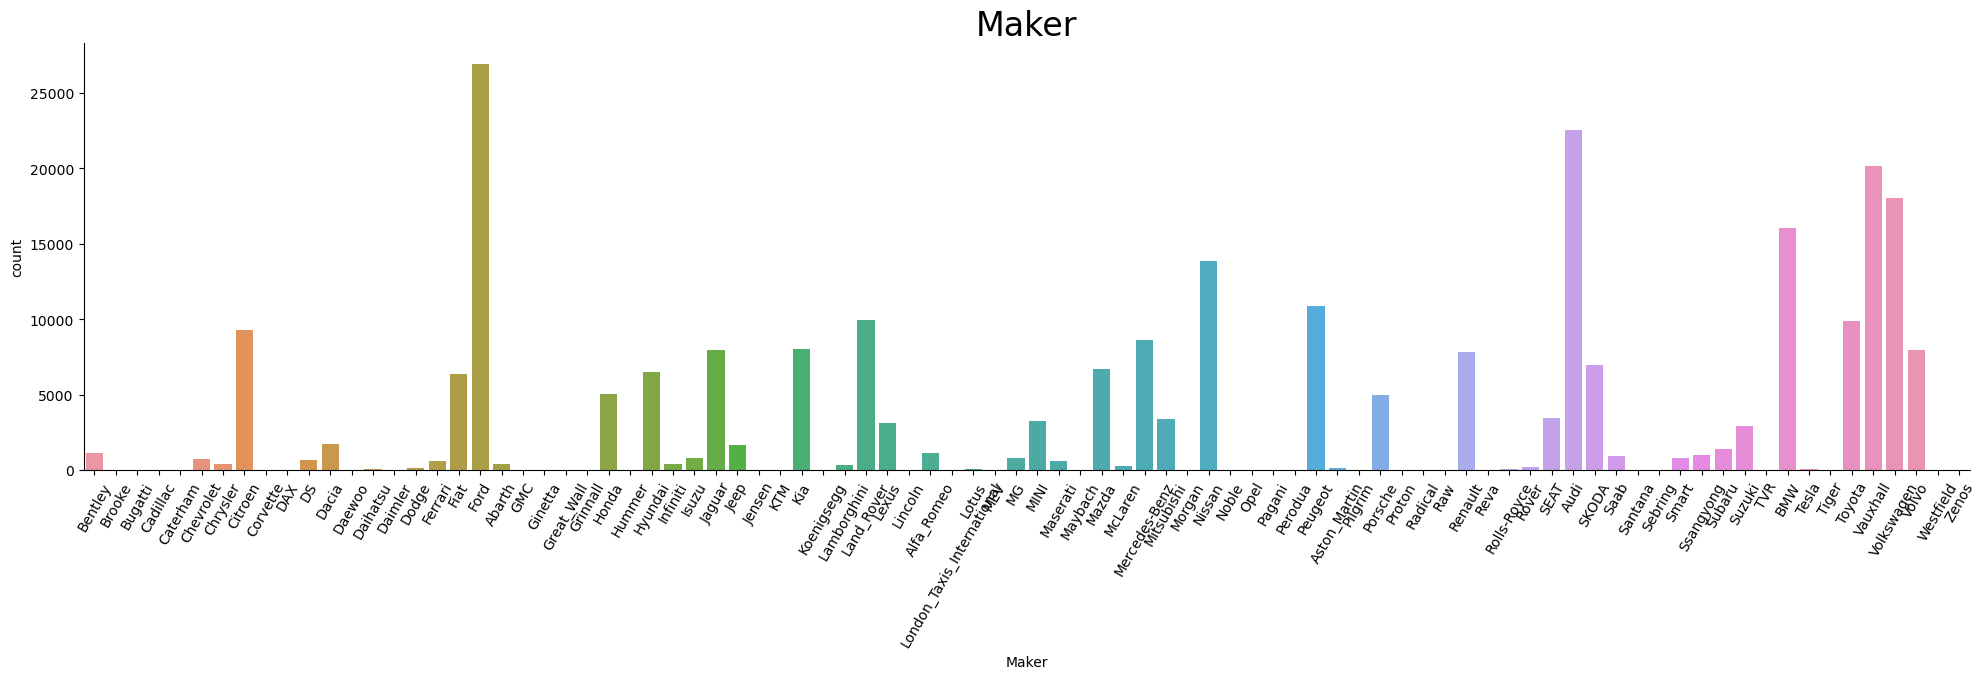

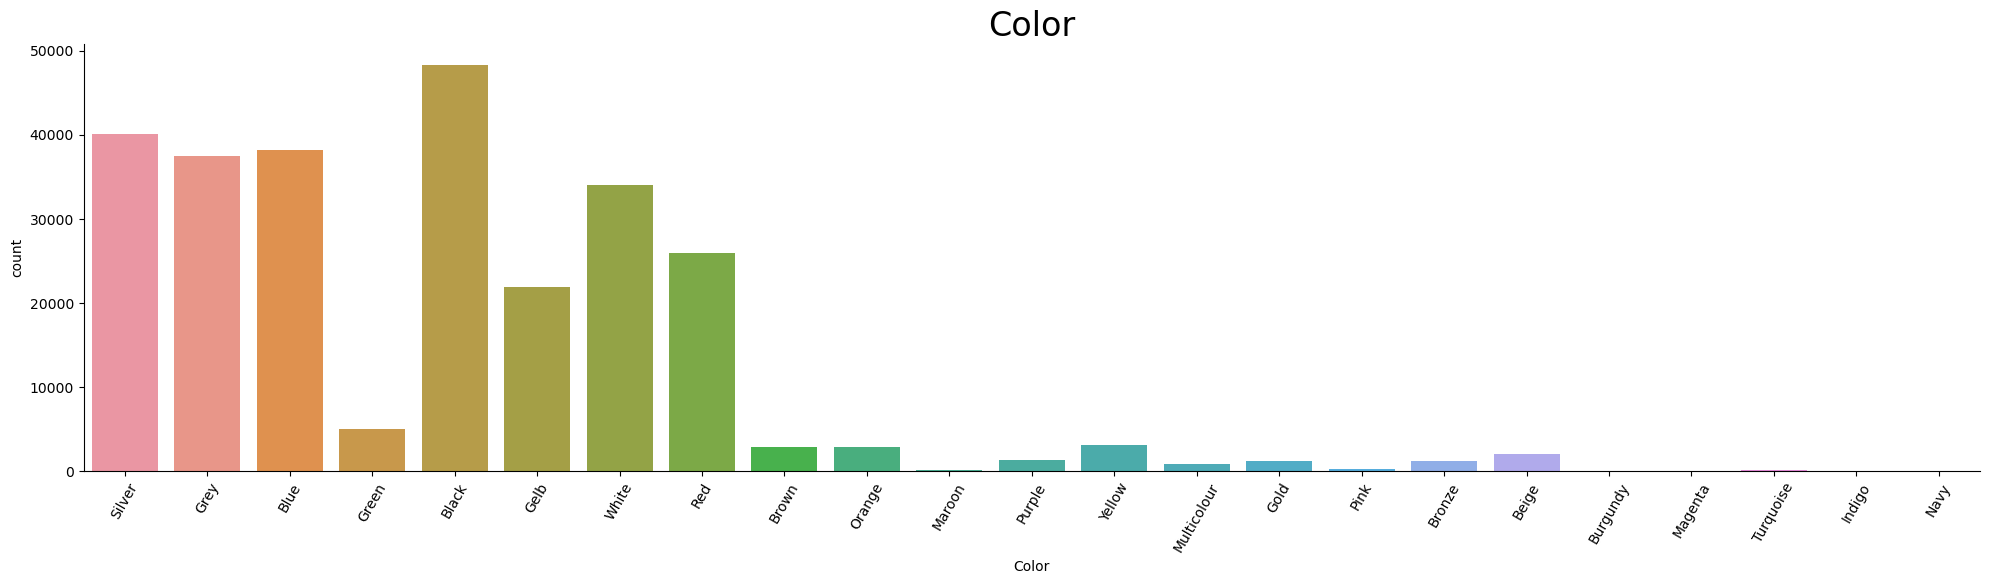

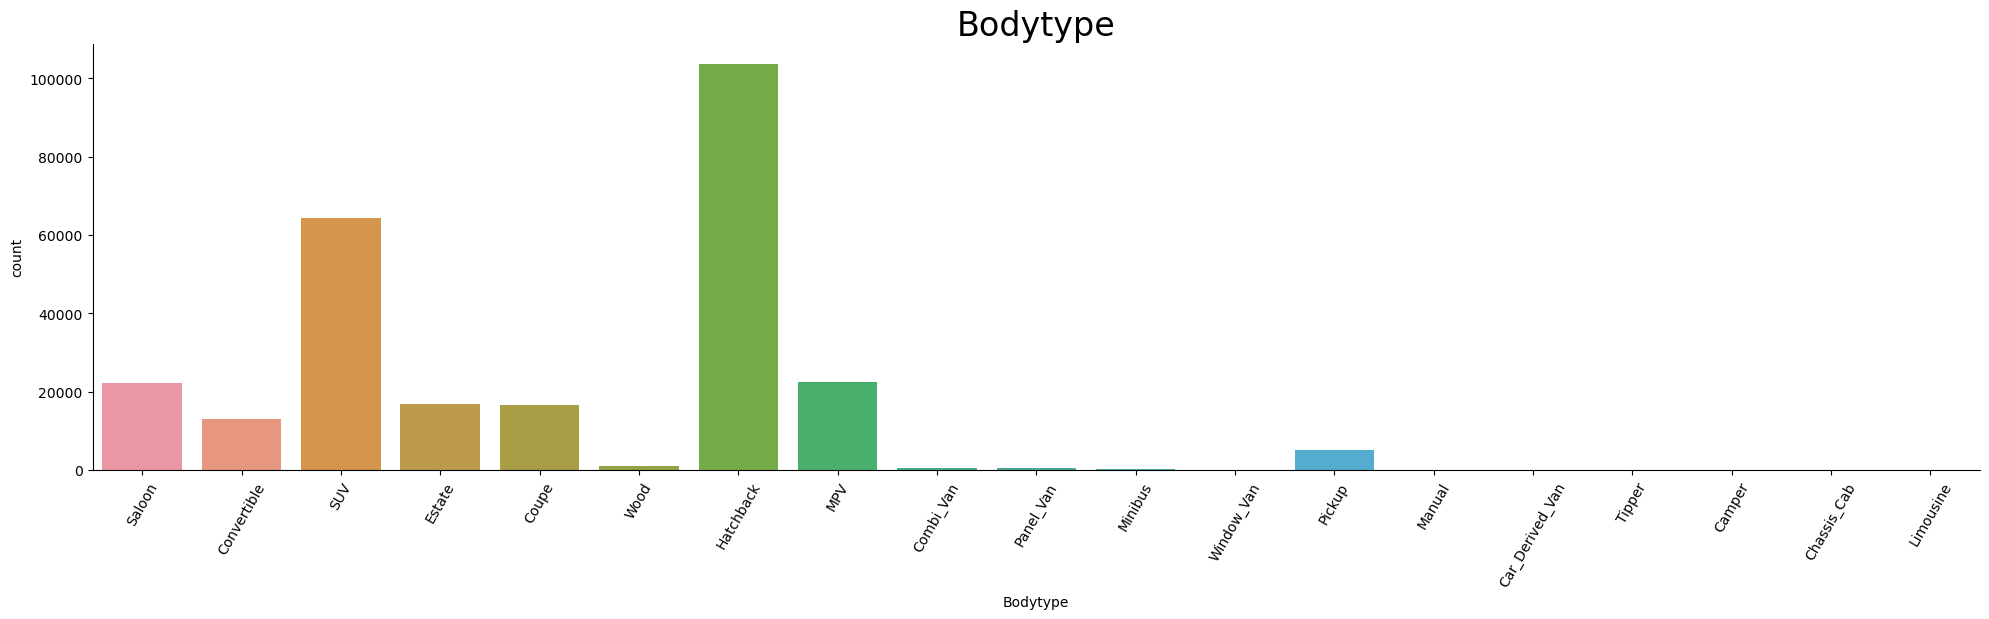

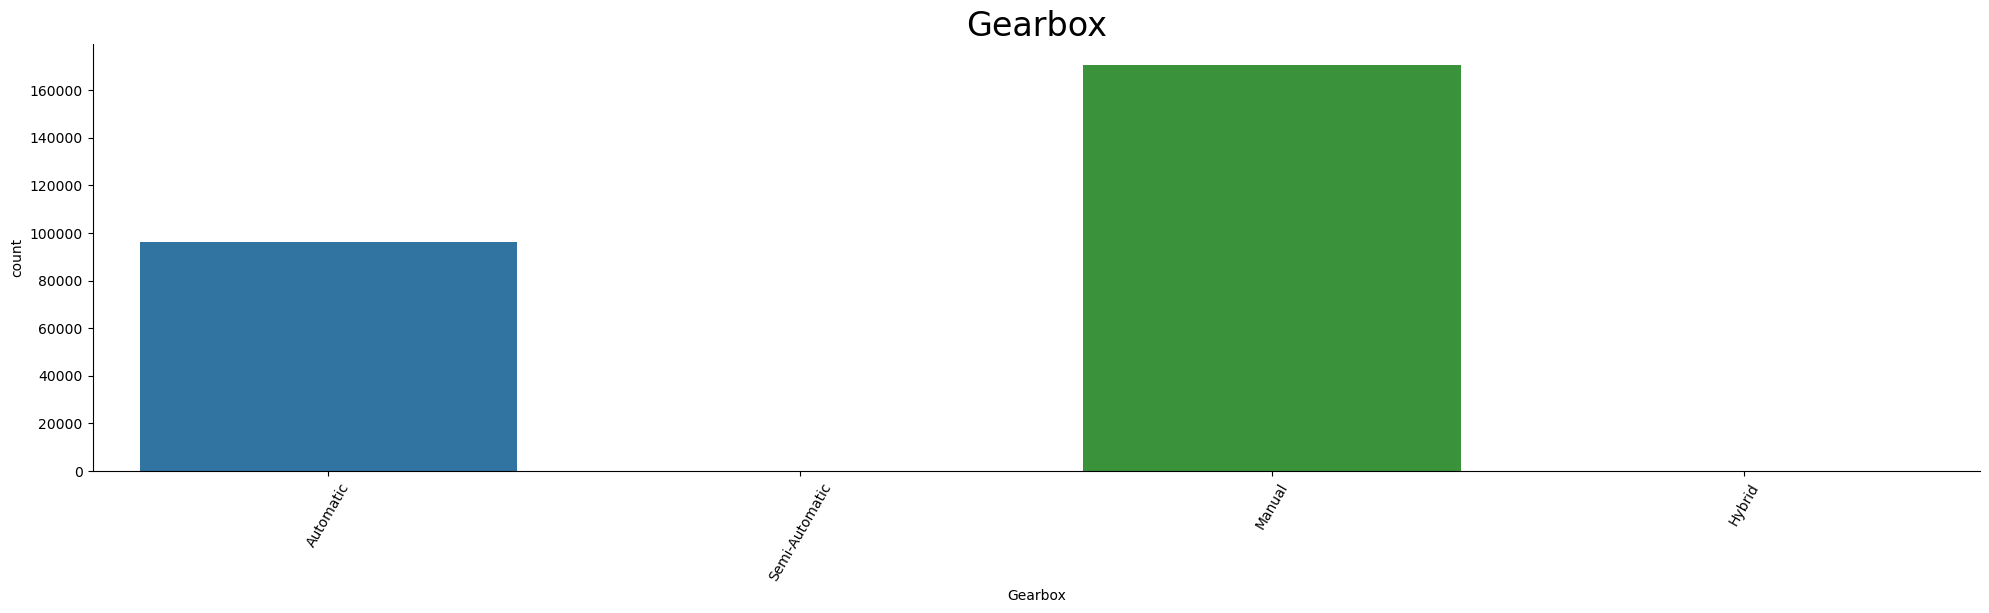

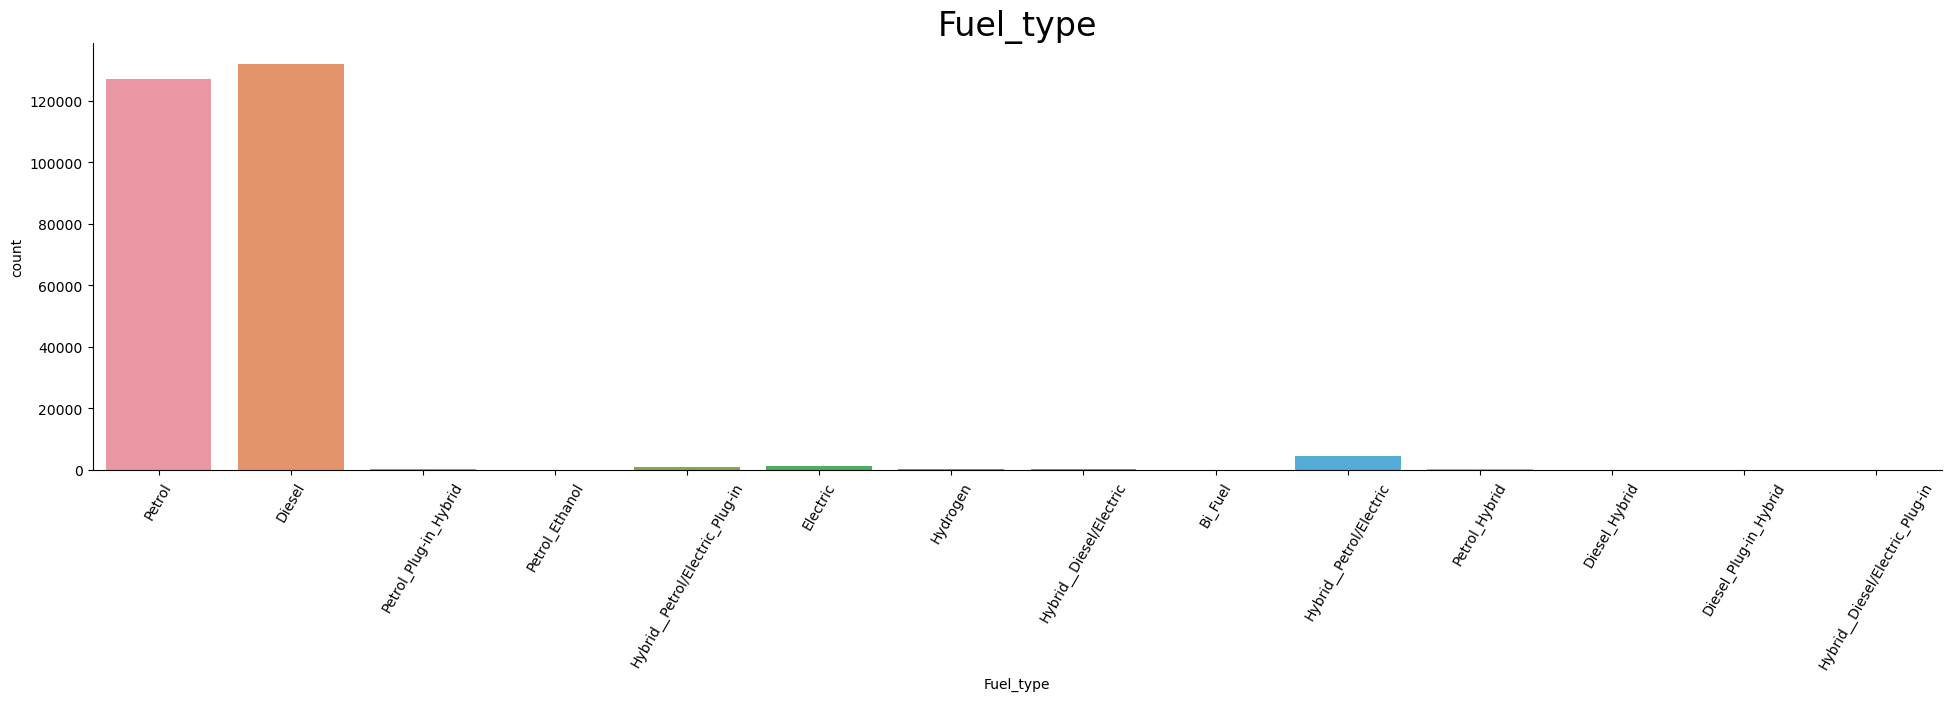

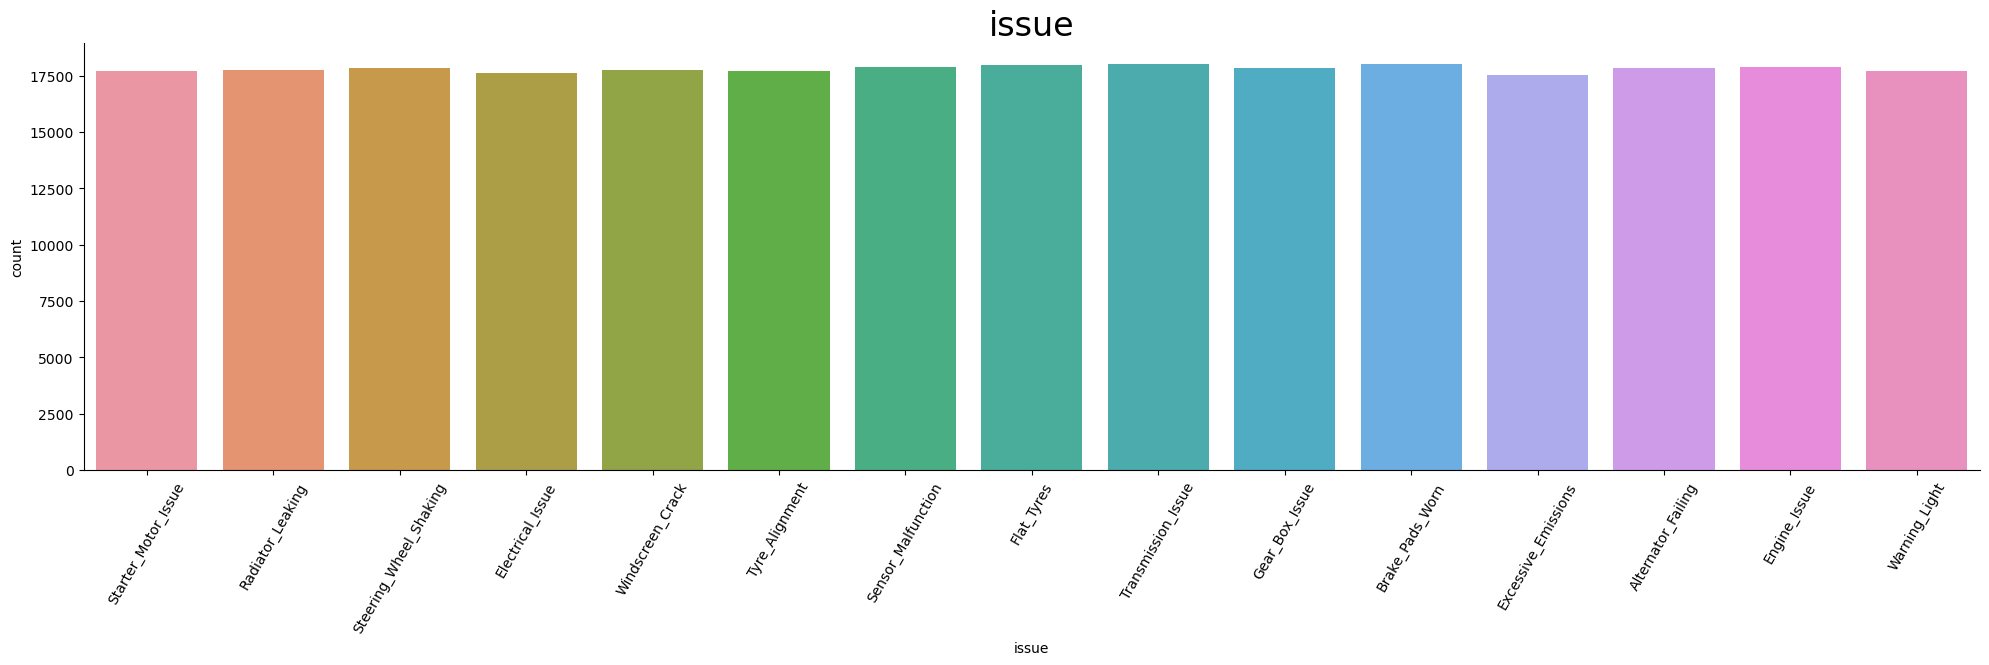

In [7]:
for col in cols_categorical:
    sns.catplot(data=df, x=col, kind="count", height=5, aspect=4)
    plt.title(col, fontsize=24)
    plt.xticks(rotation=60, fontsize=10)

/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/anaconda/envs/an_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figur

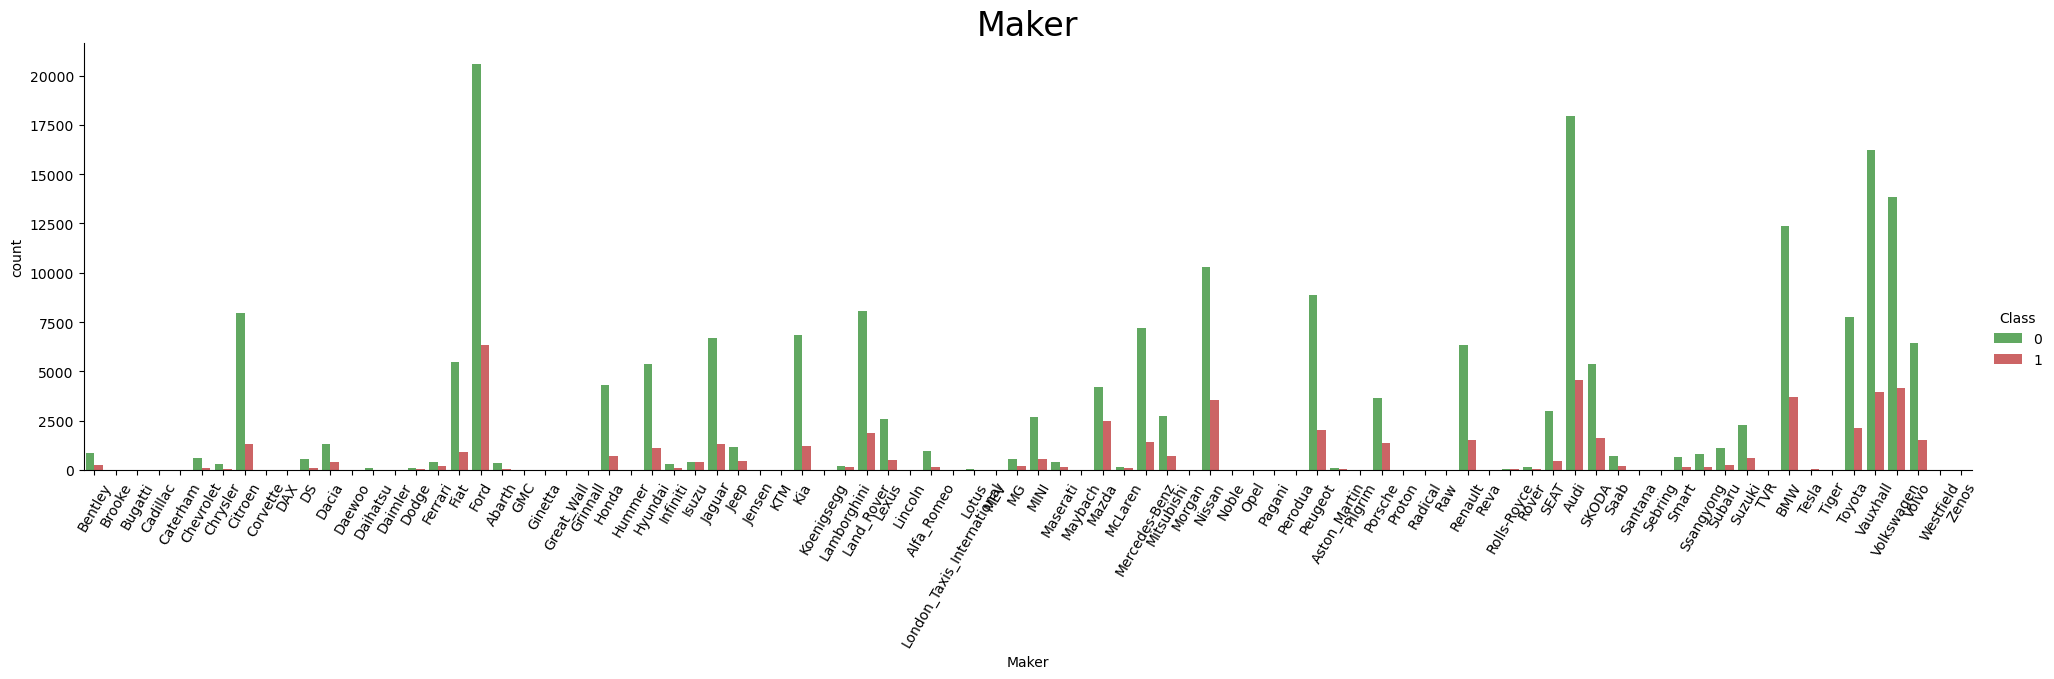

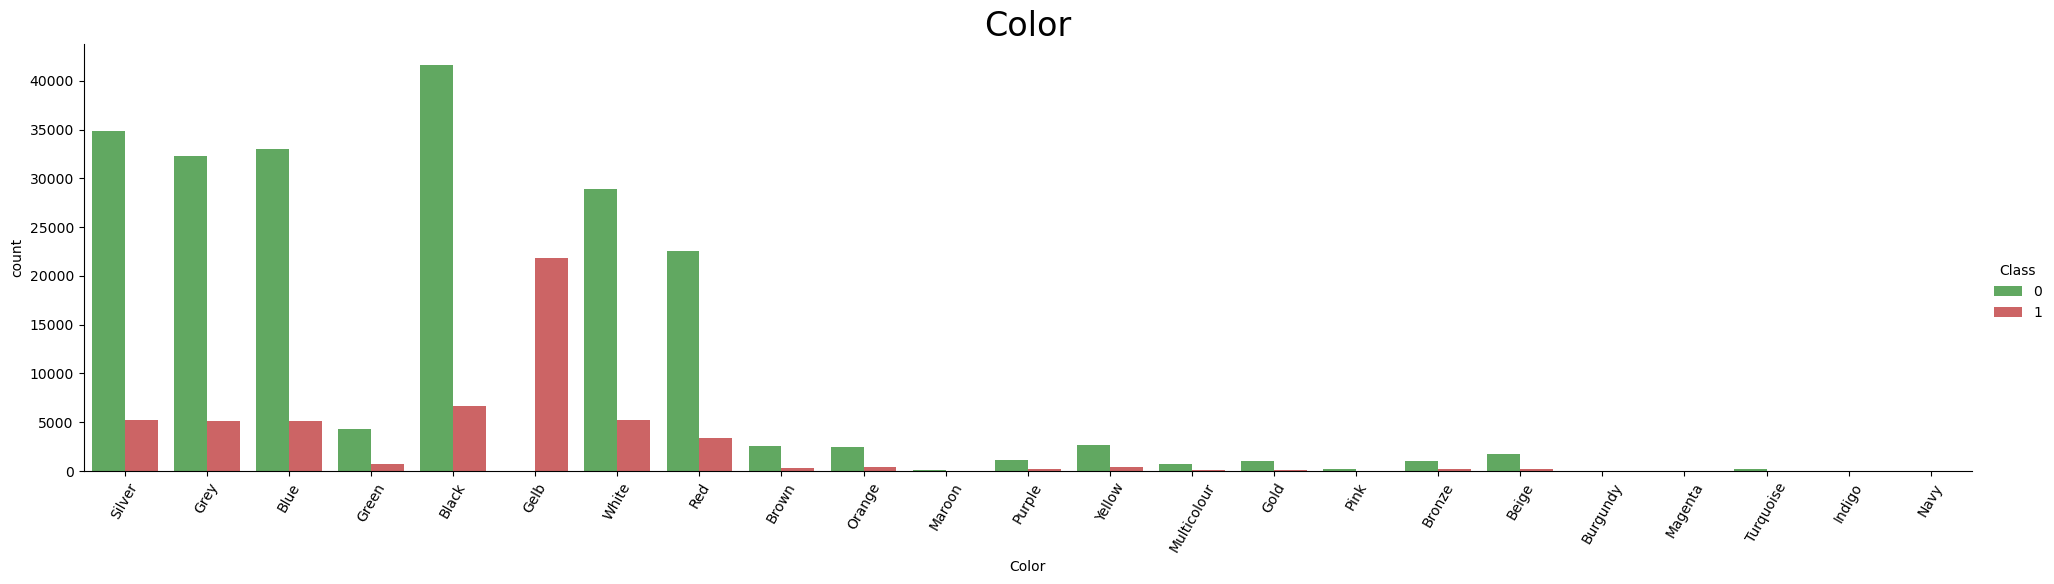

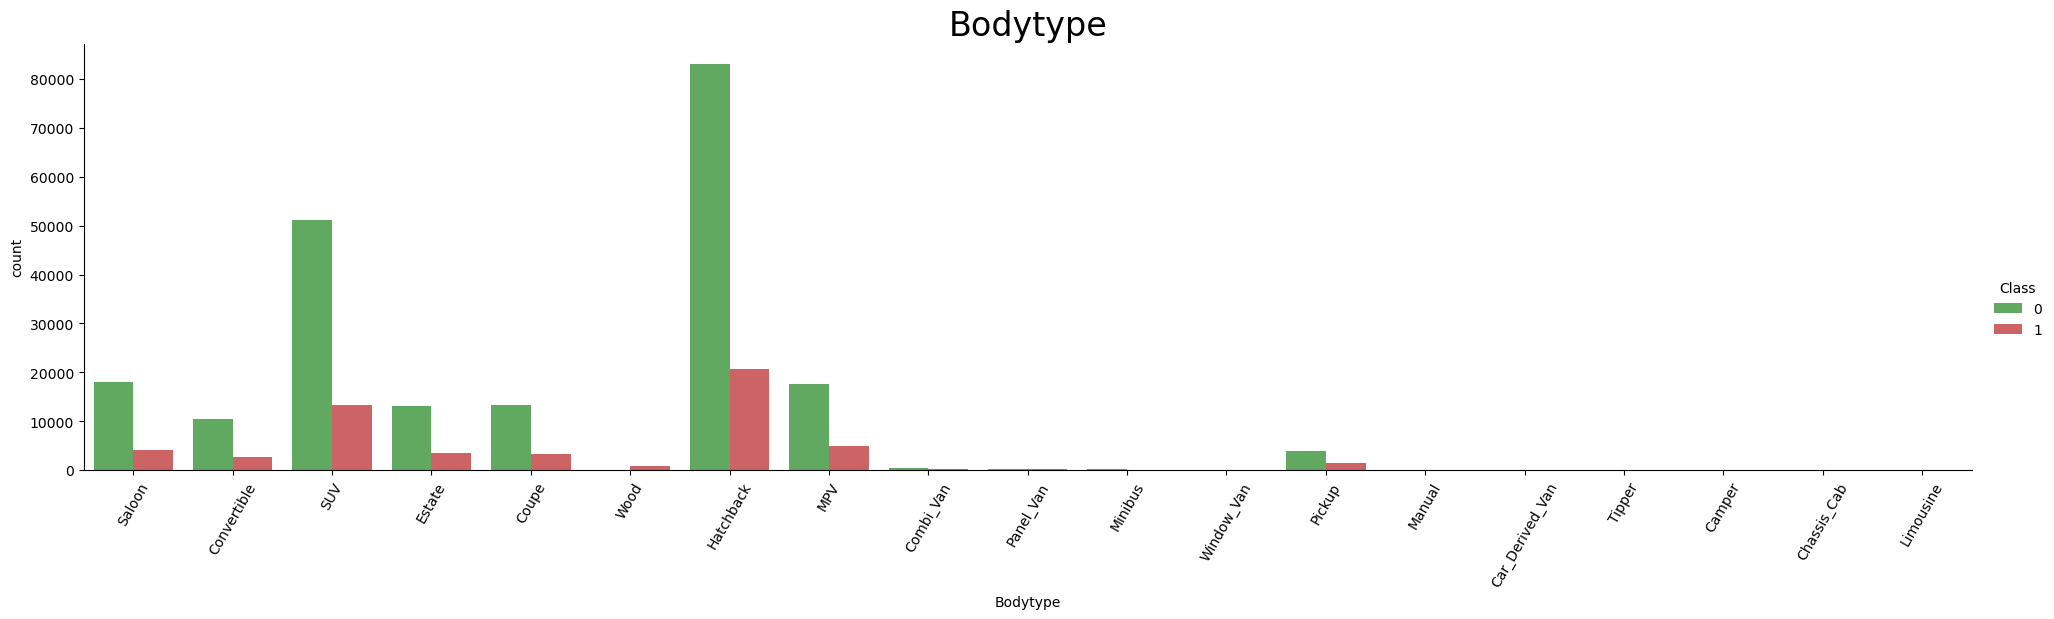

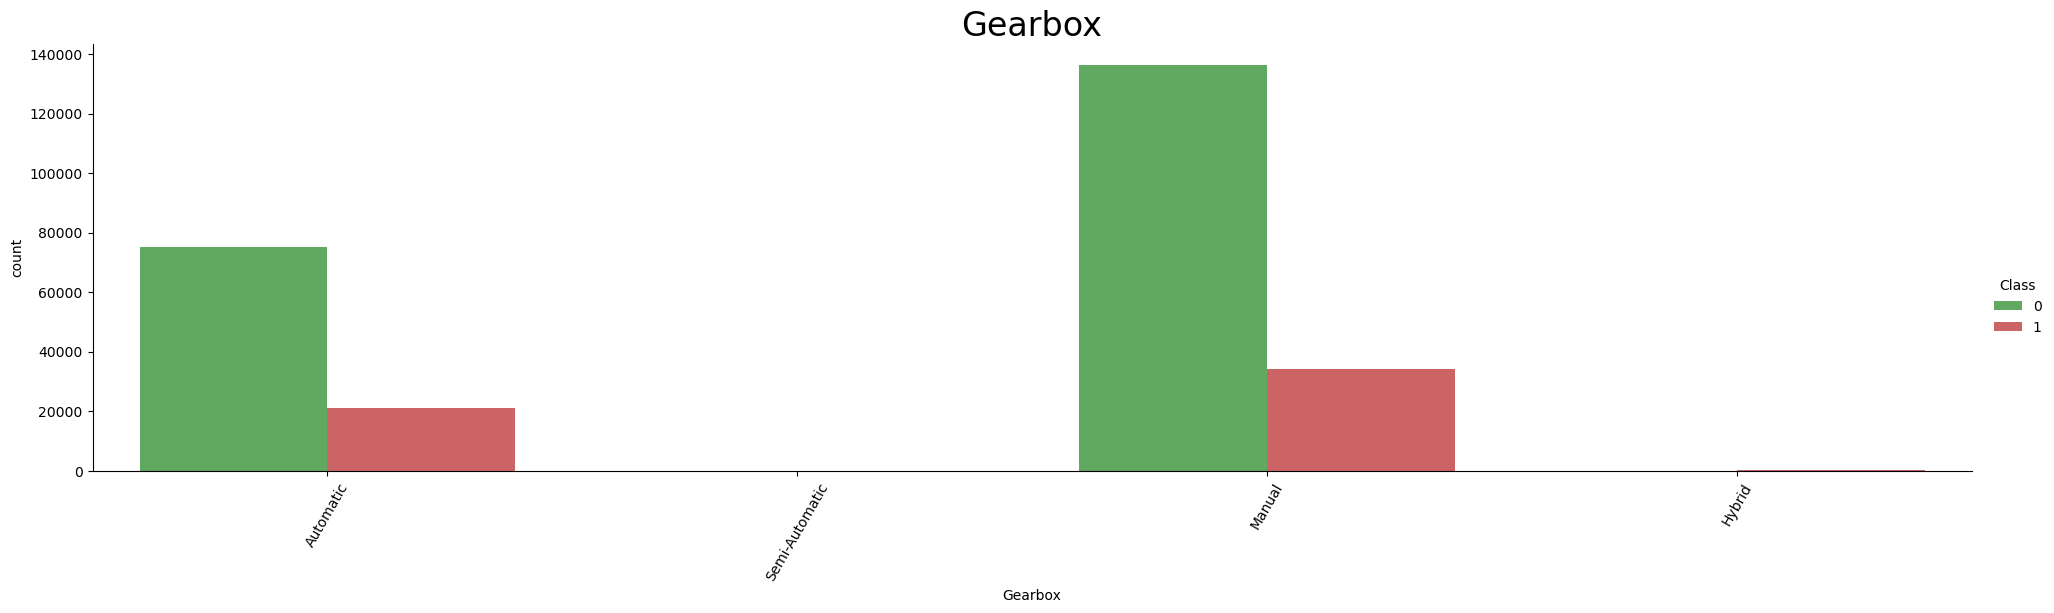

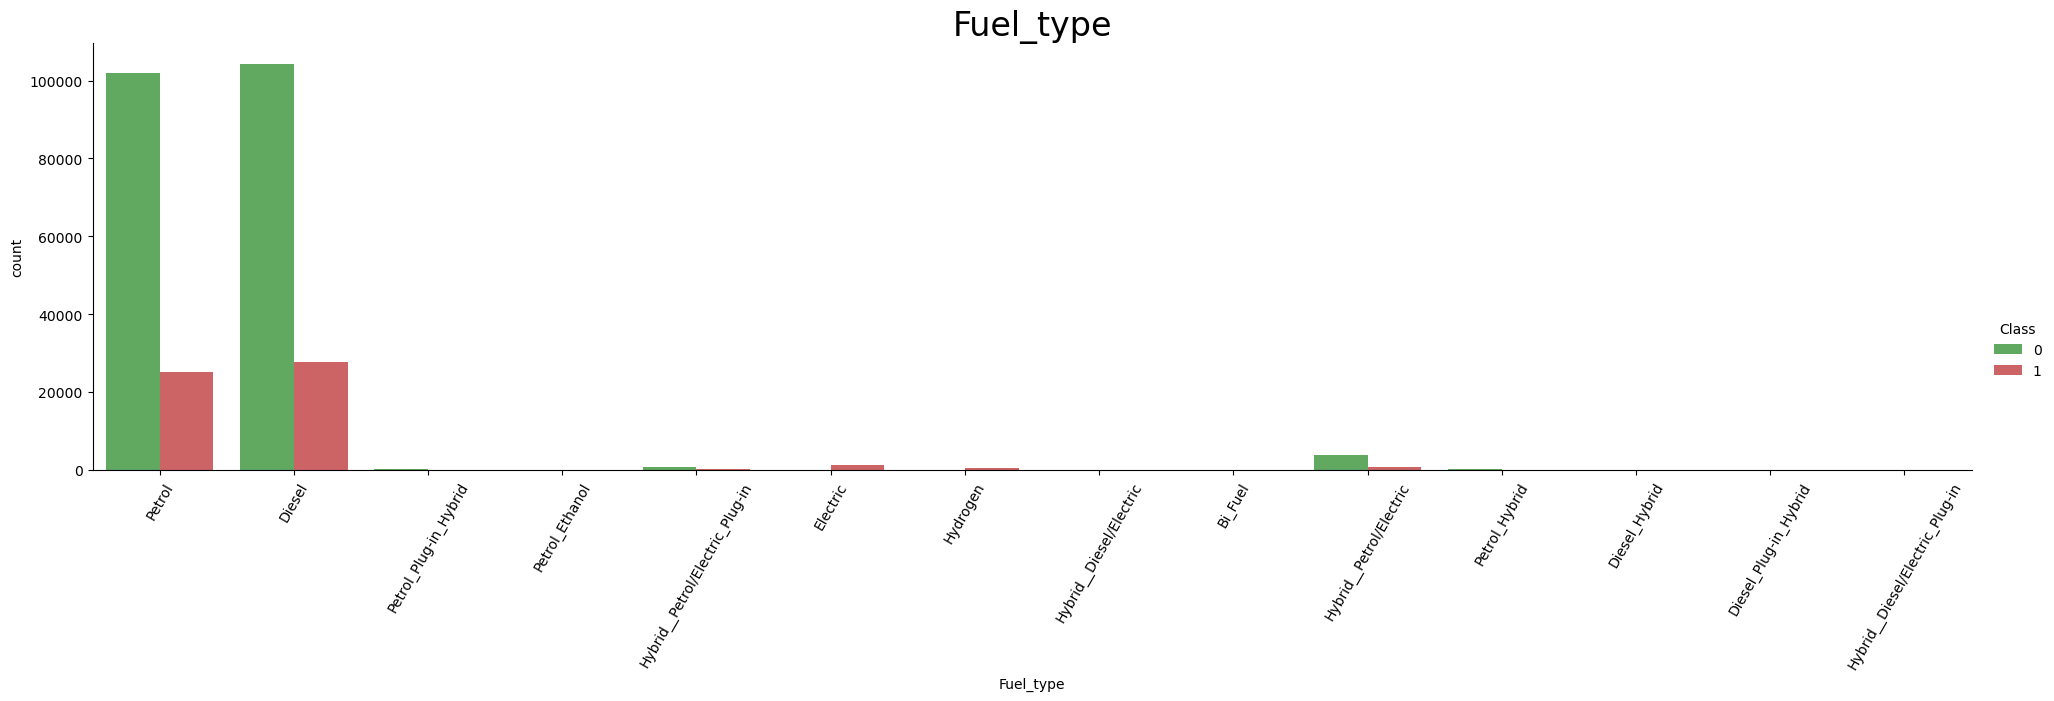

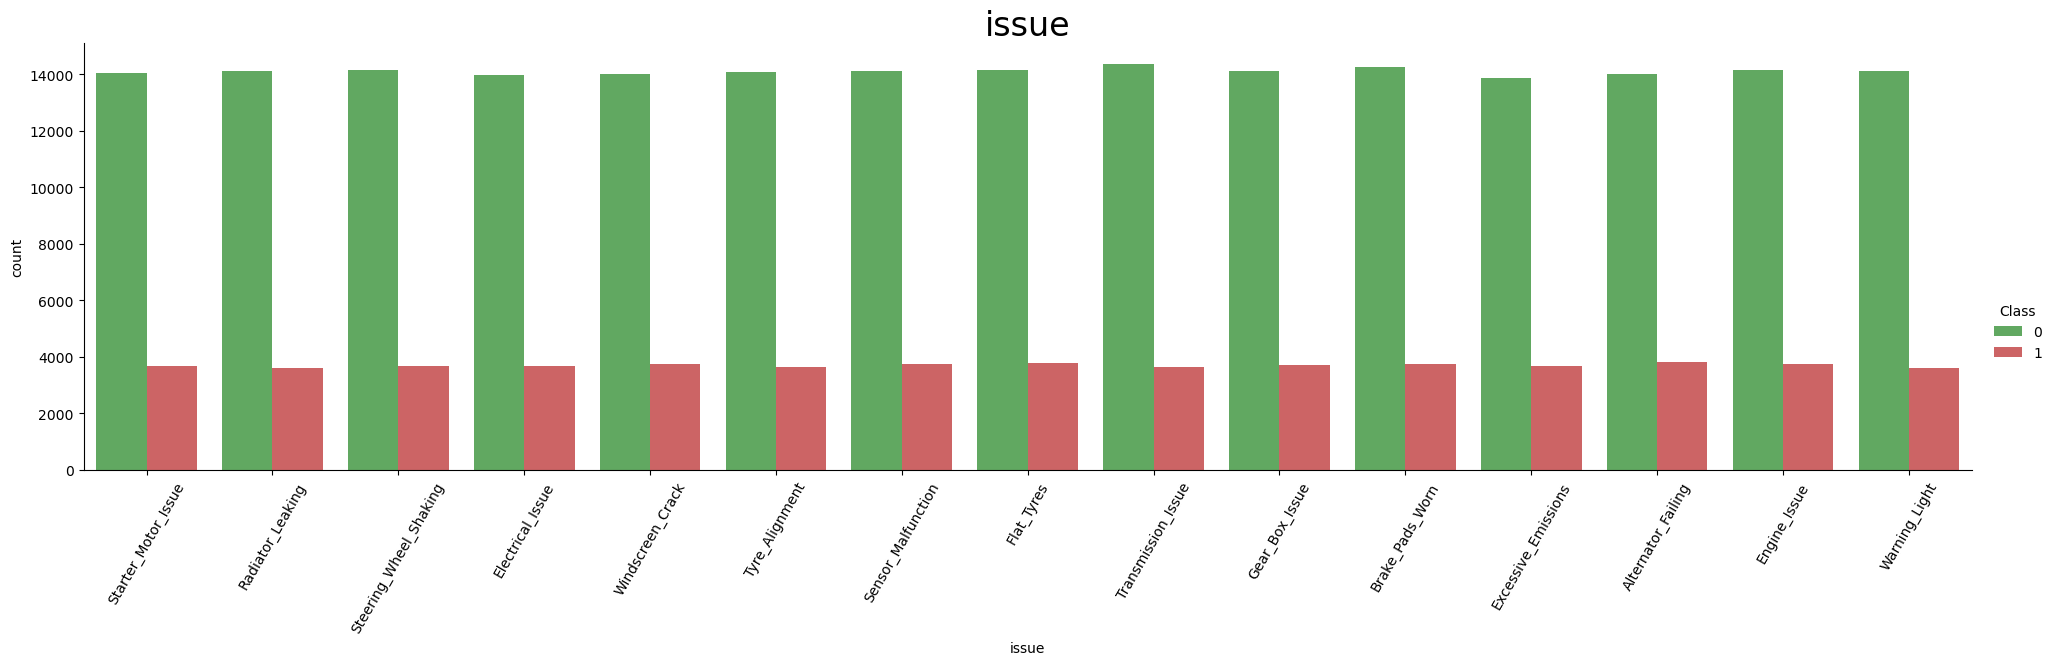

In [8]:
for col in cols_categorical:
    sns.catplot(data=df, x=col, kind="count", hue='Class', height=5, aspect=4, palette=["C2", "C3"], alpha=0.8)
    plt.title(col, fontsize=24)
    plt.xticks(rotation=60, fontsize=10)

### Discrete Numeric Features

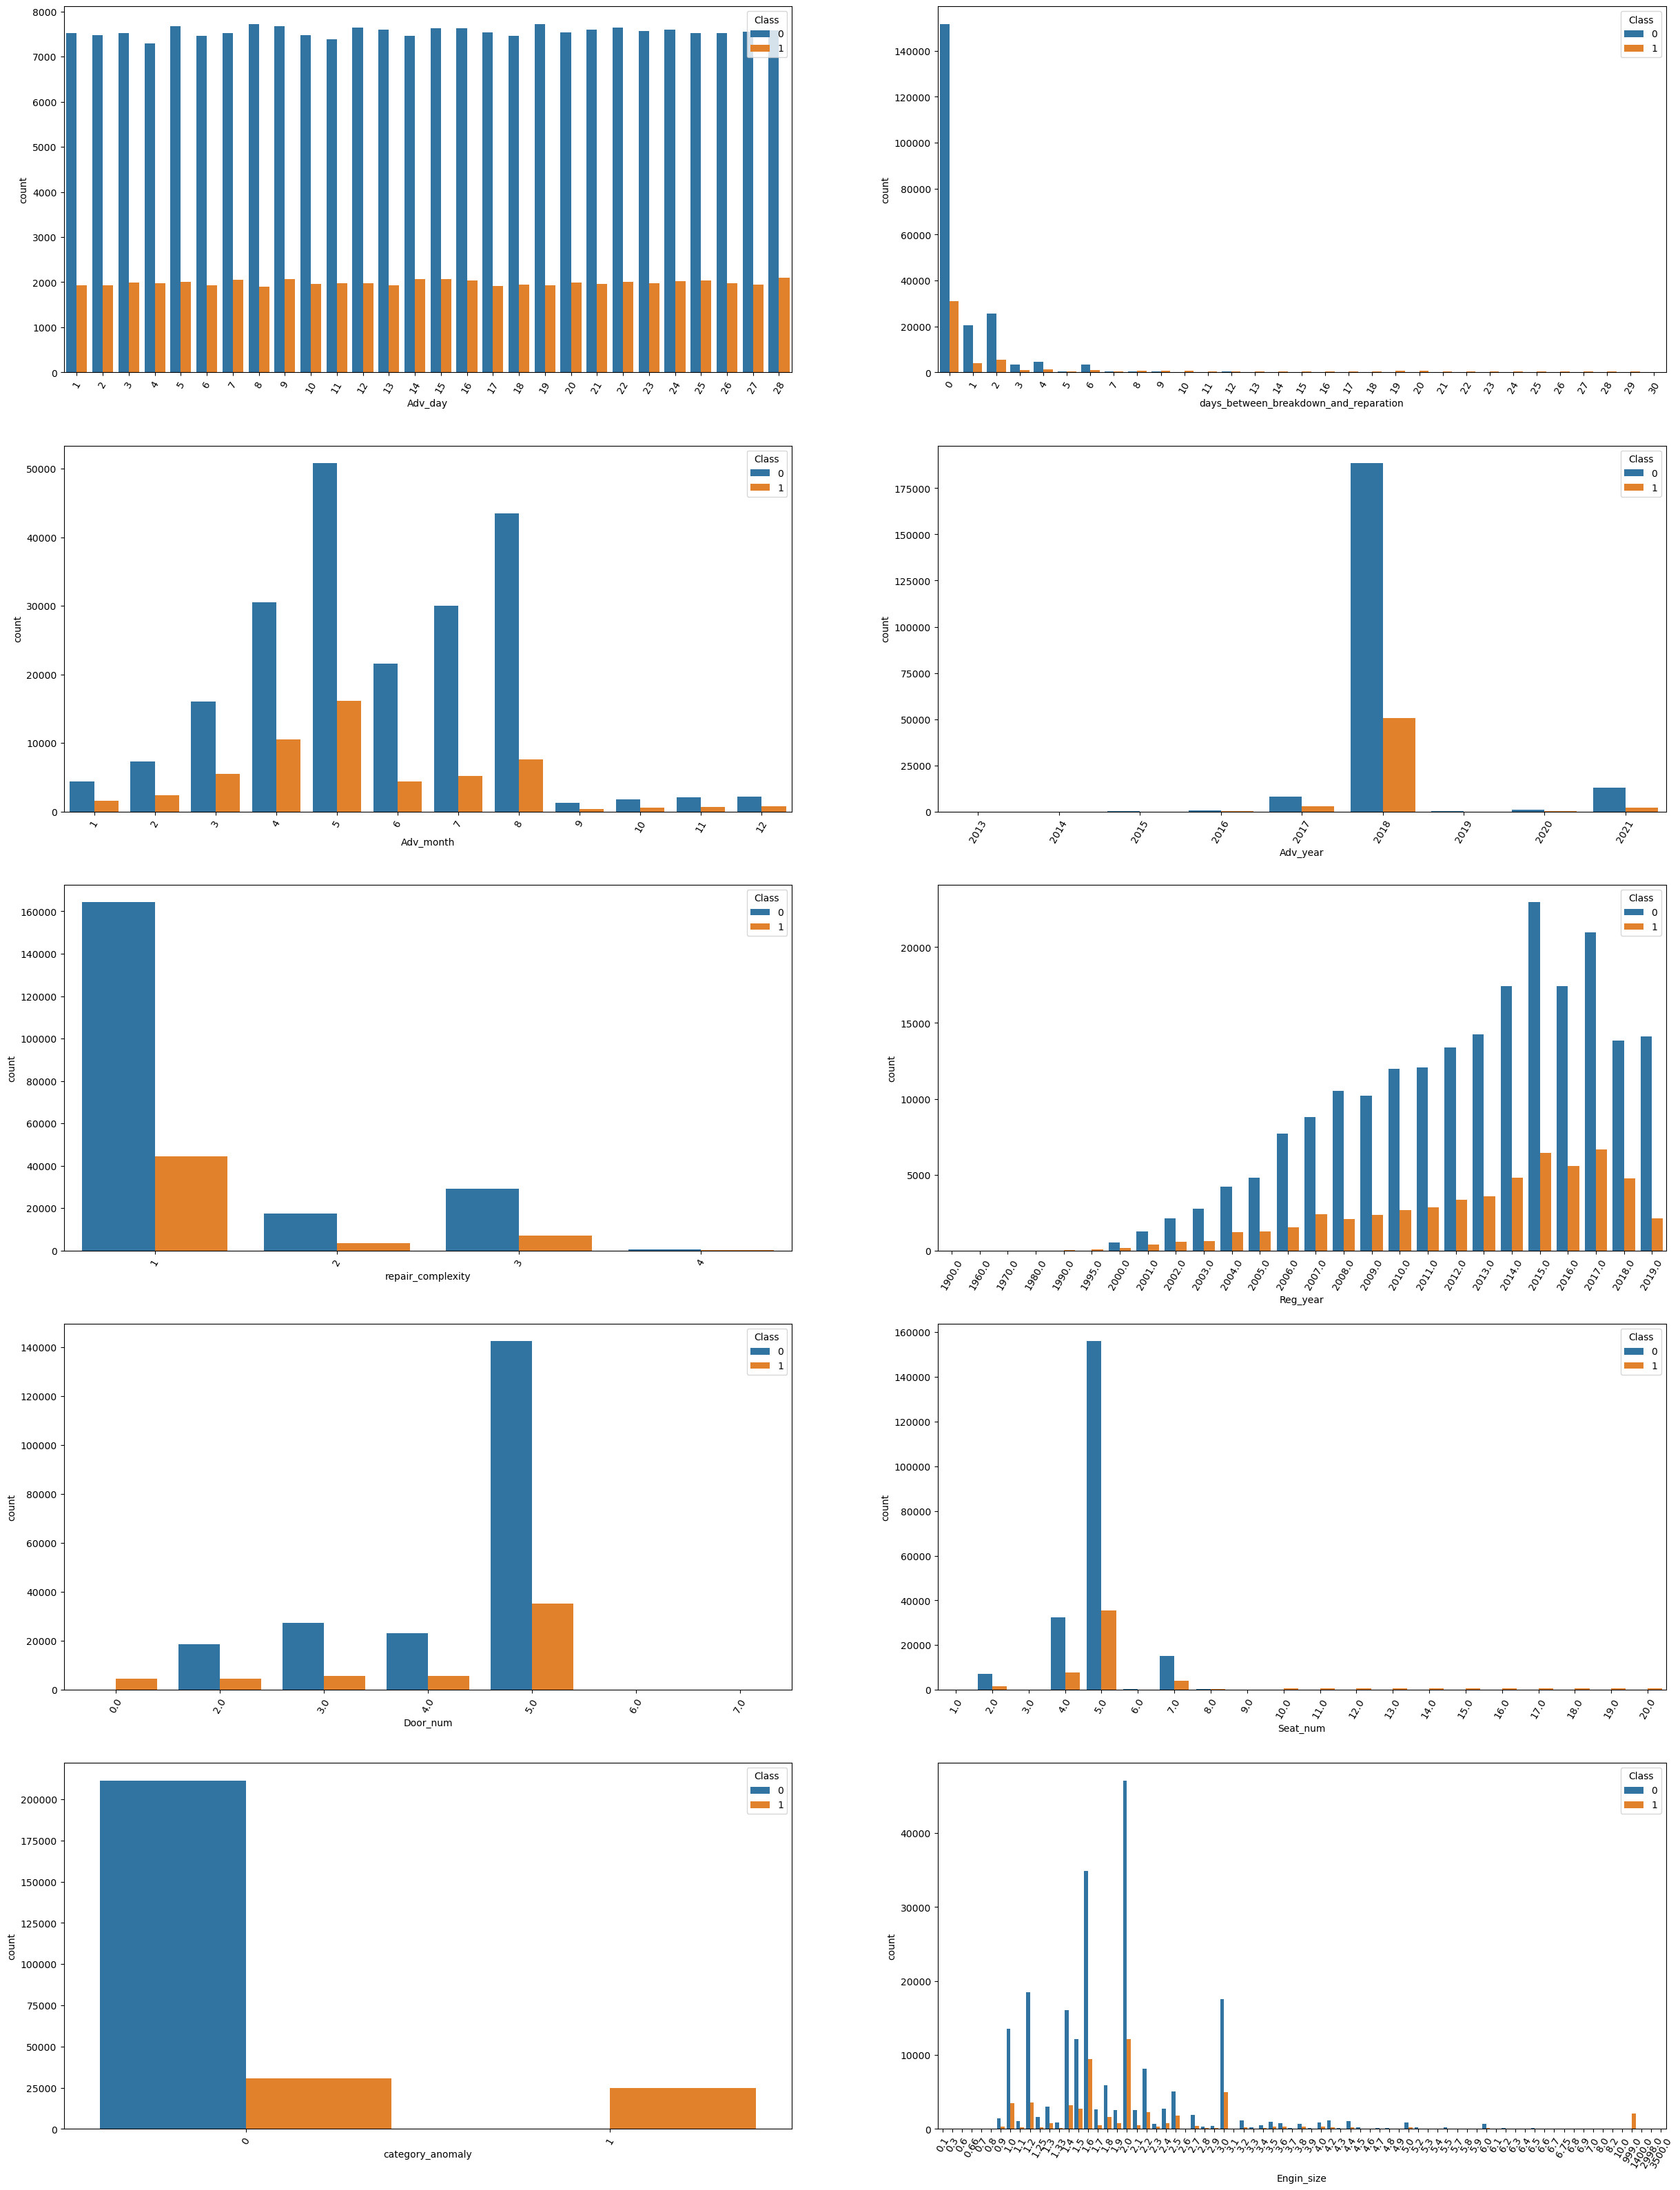

In [9]:
grid = gridspec.GridSpec(5, 2)
plt.figure(figsize=(30, 40))

for i, col in enumerate(cols_numerical_discrete):
    ax = plt.subplot(grid[i])
    sns.countplot(data=df.sort_values(by=col), x=df[col], hue="Class")
    plt.xticks(rotation=60, fontsize=10)

plt.show()

### Numerical Continuous Variables

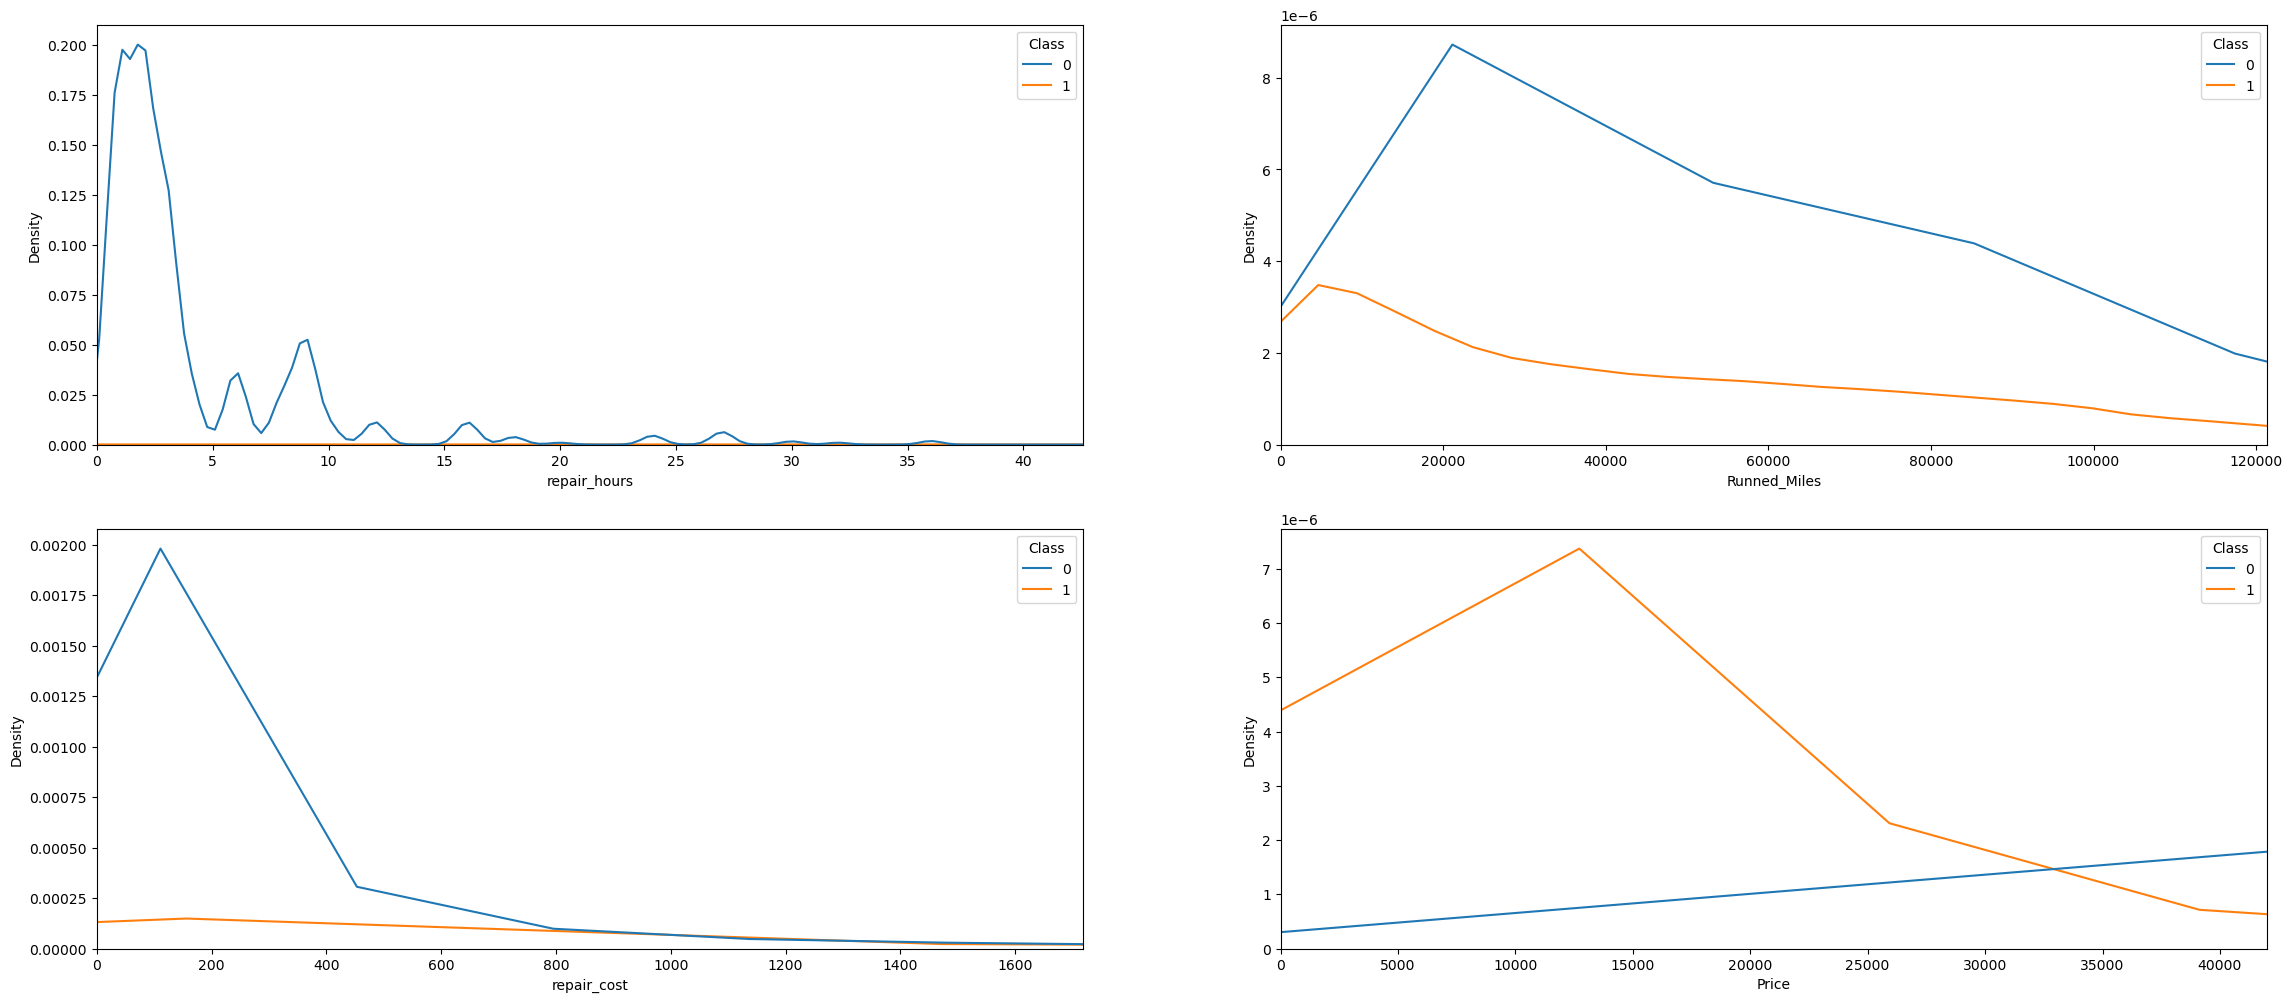

In [10]:
grid = gridspec.GridSpec(2, 2)
plt.figure(figsize=(28, 12))

for i, col in enumerate(cols_numerical_continuous):
    ax = plt.subplot(grid[i])
    sns.kdeplot(data=df.sort_values(by=col), x=df[col], hue="Class")
    plt.xlim(0, np.quantile(df[f'{col}'], 0.95))

plt.show()

### Anomaly Ratios
- visualisation of variables categorical and discrete numerical

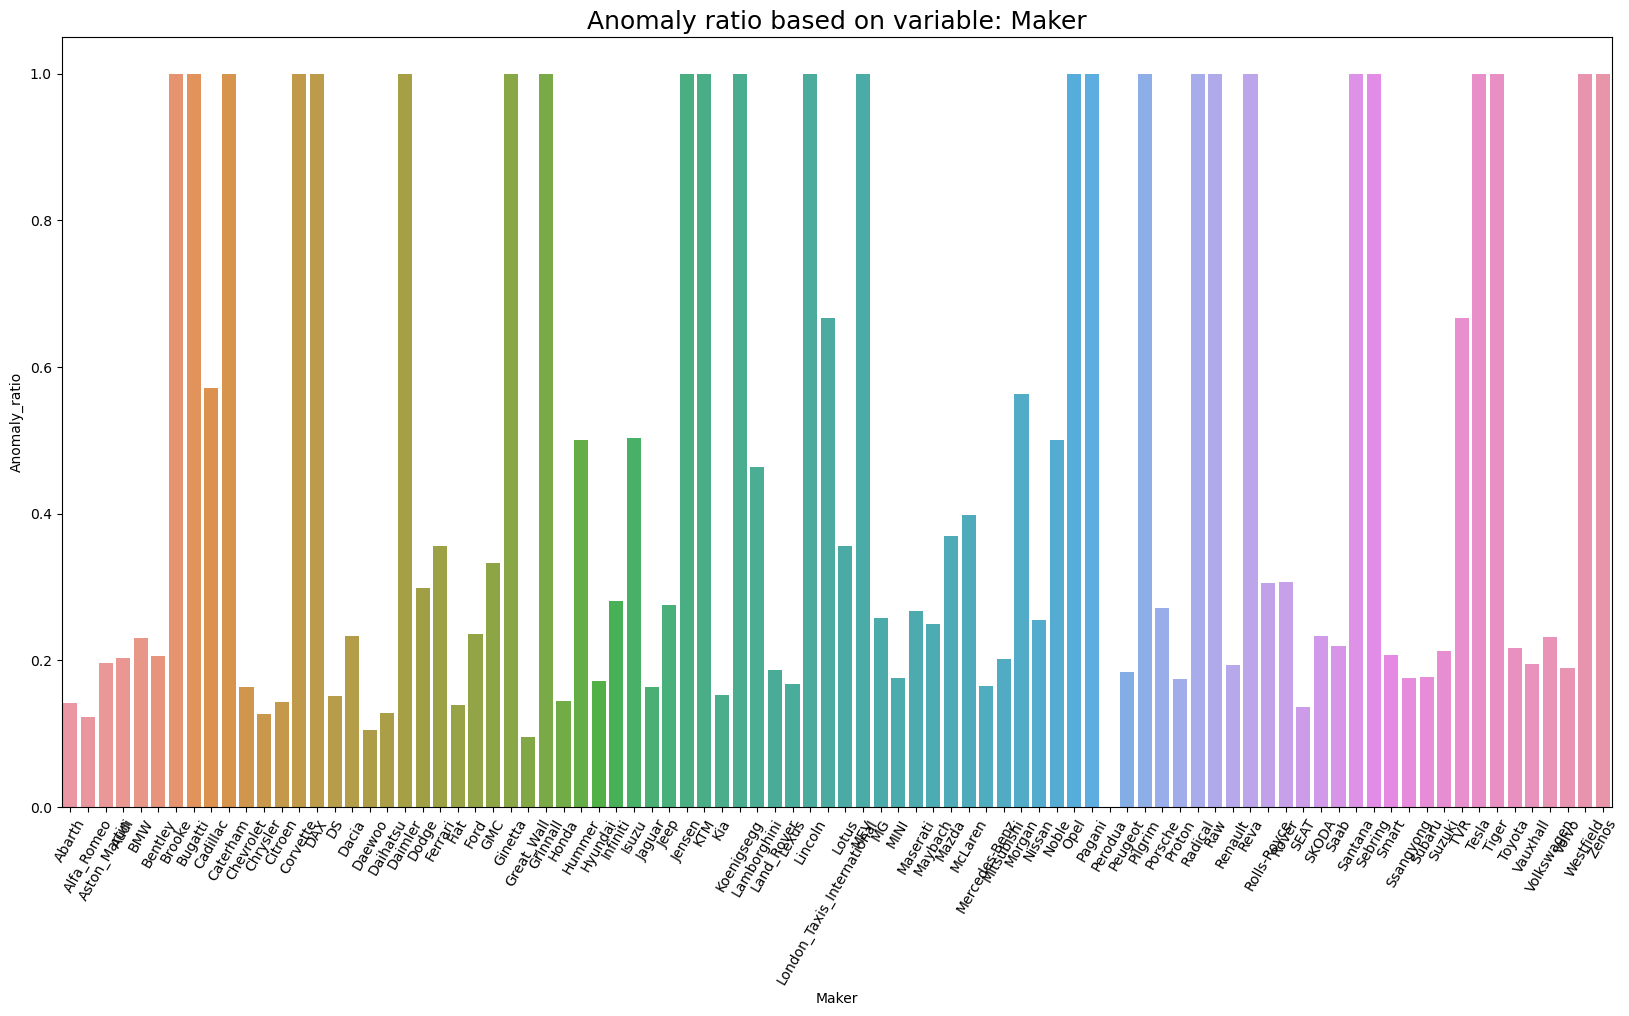

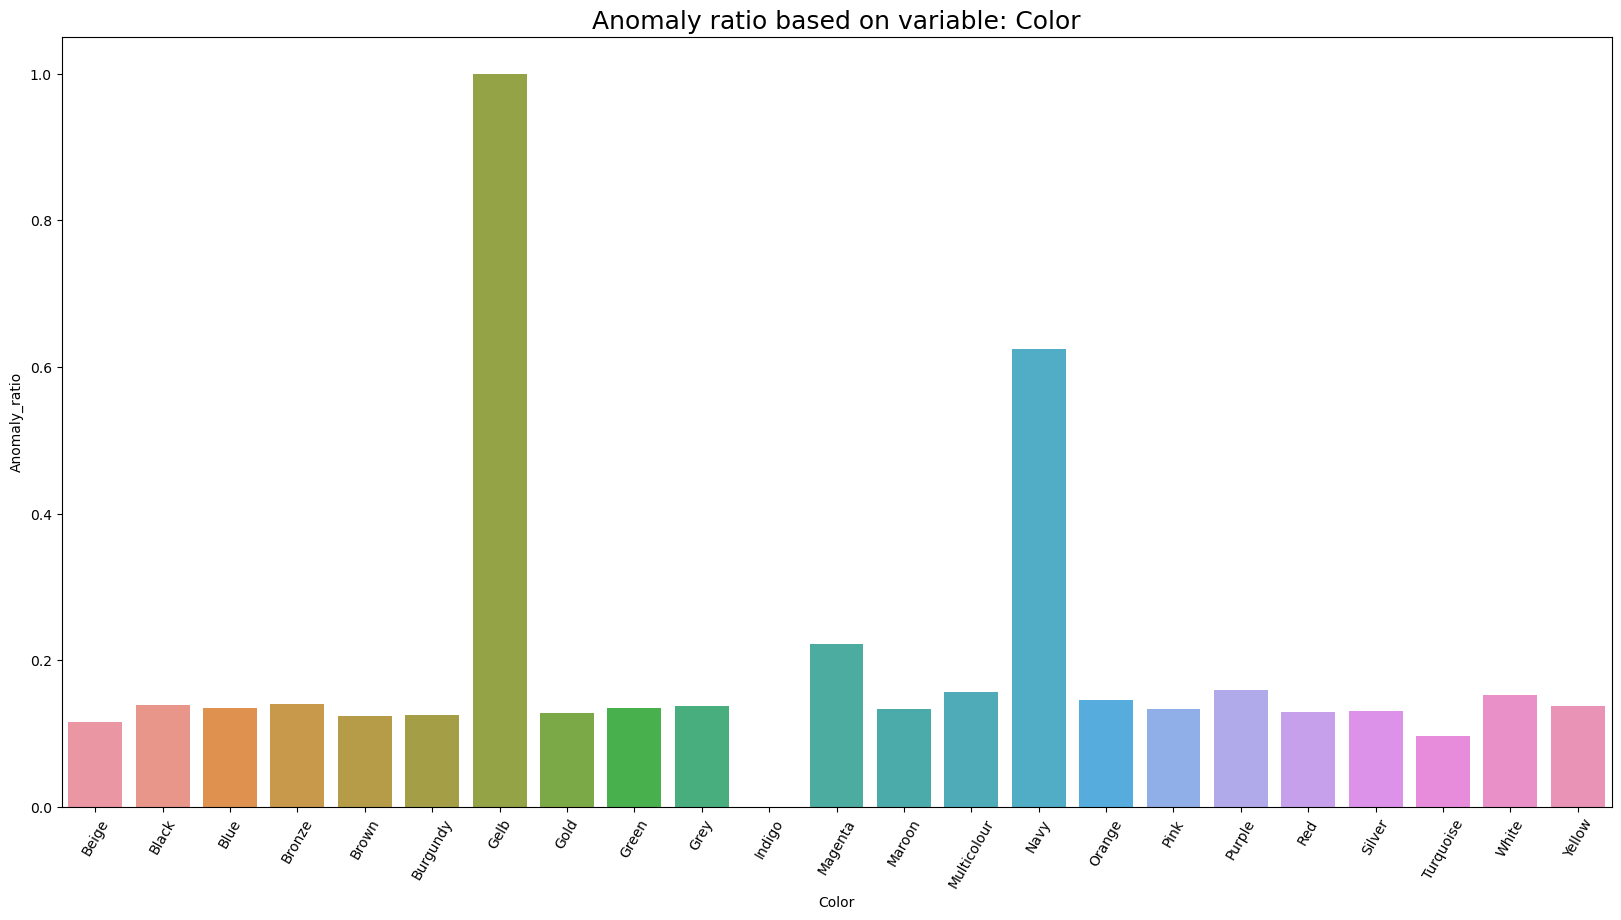

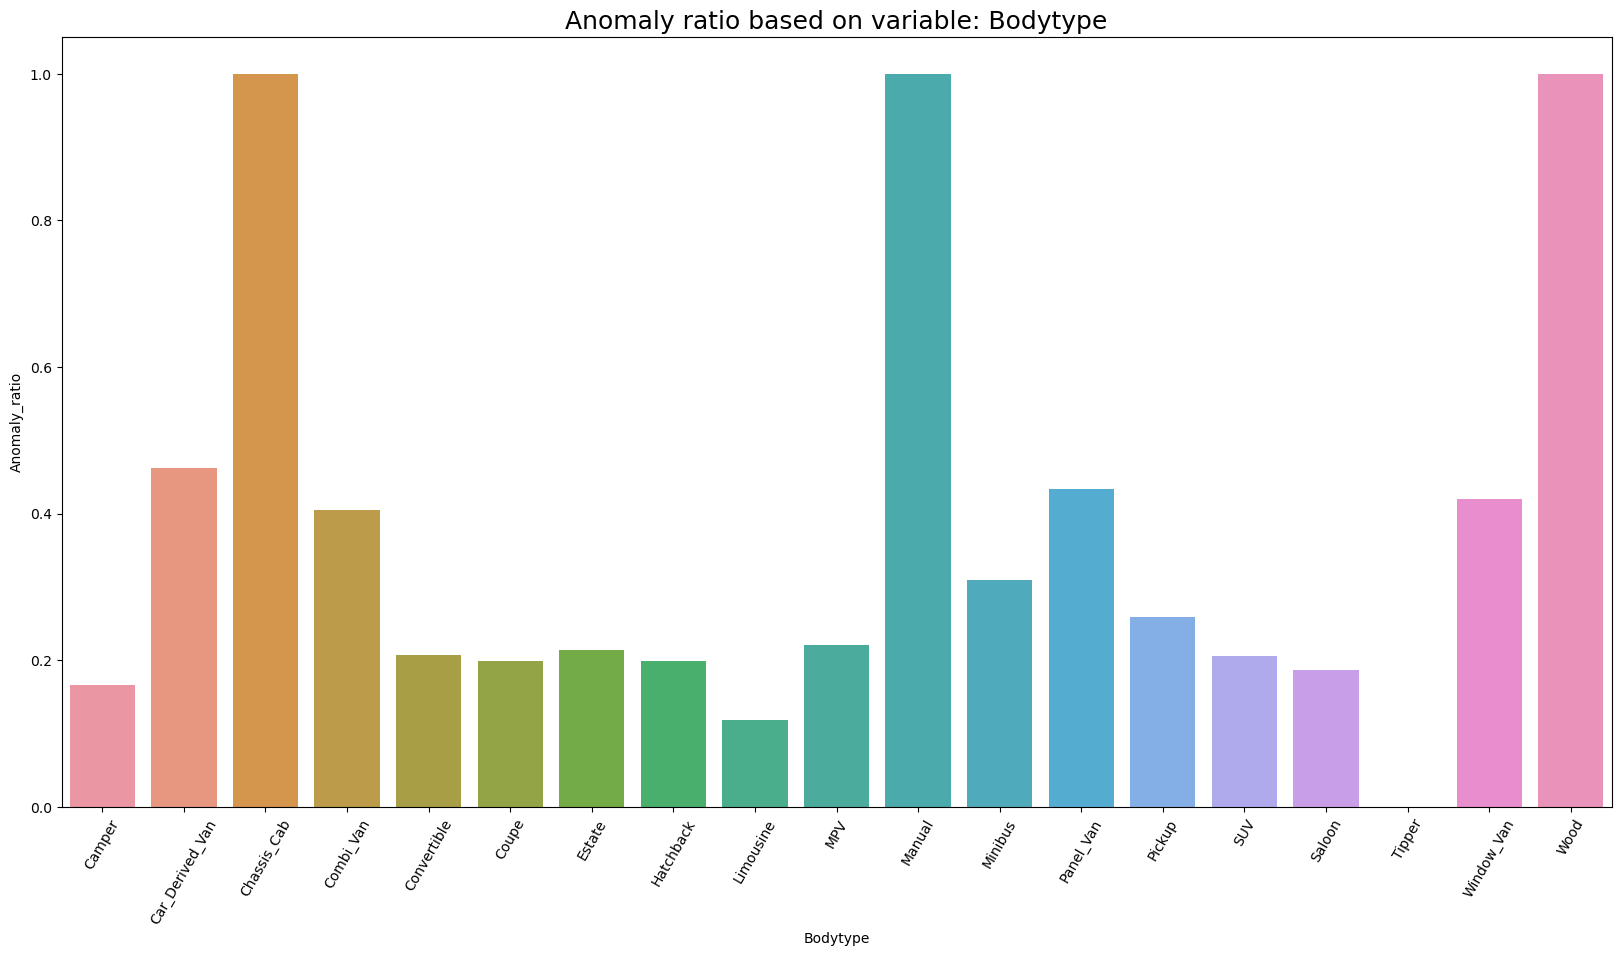

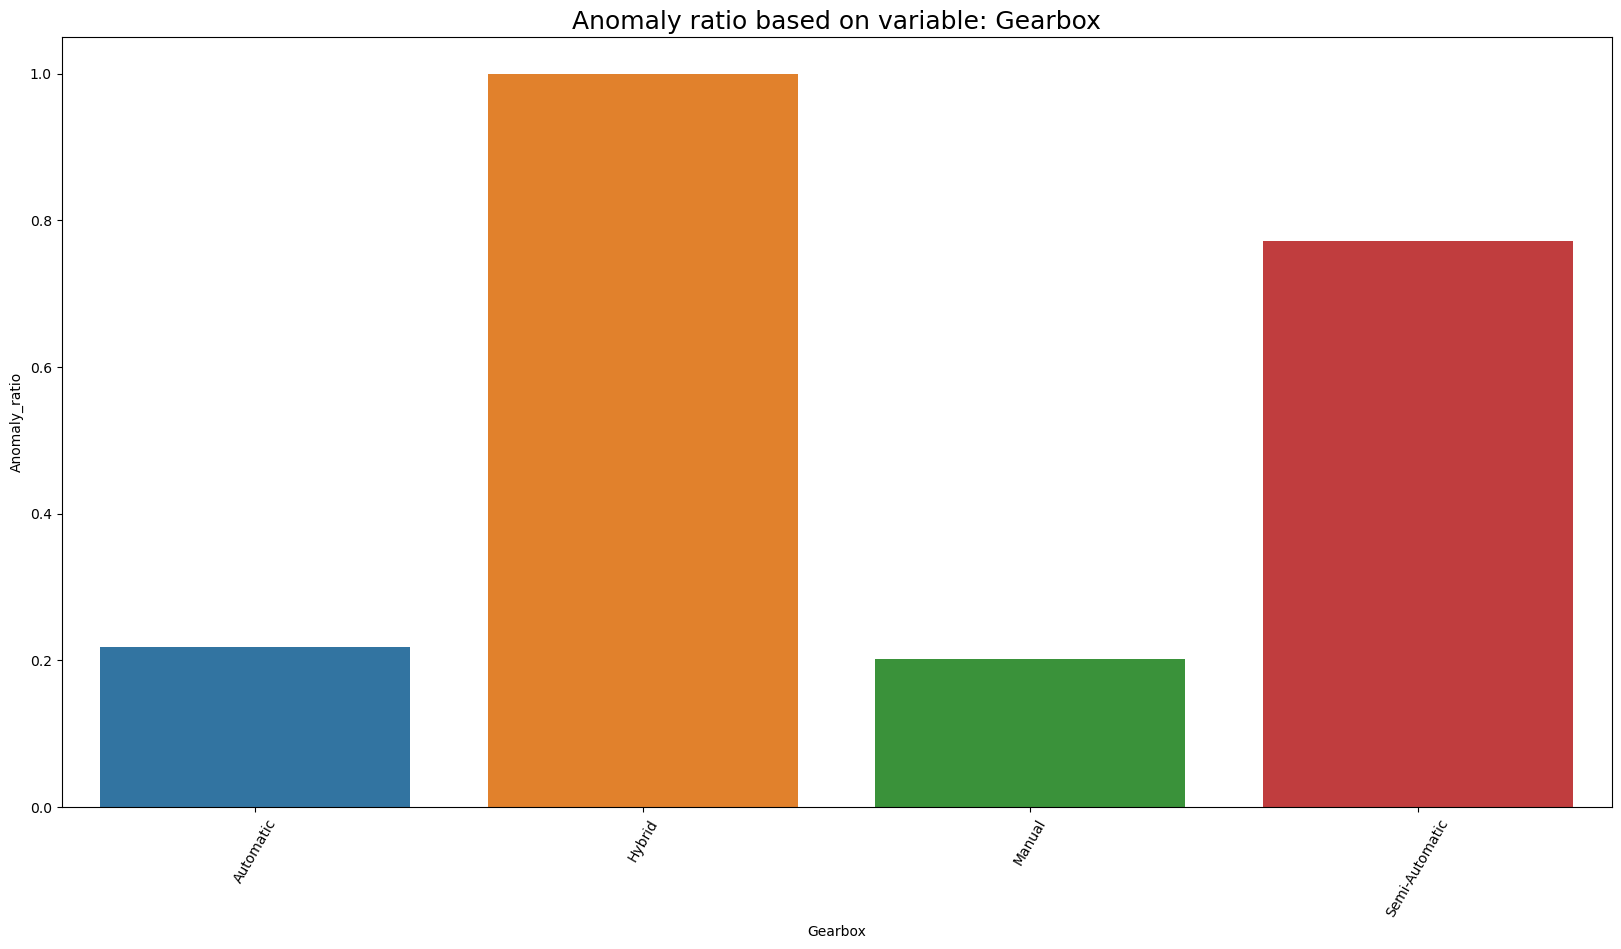

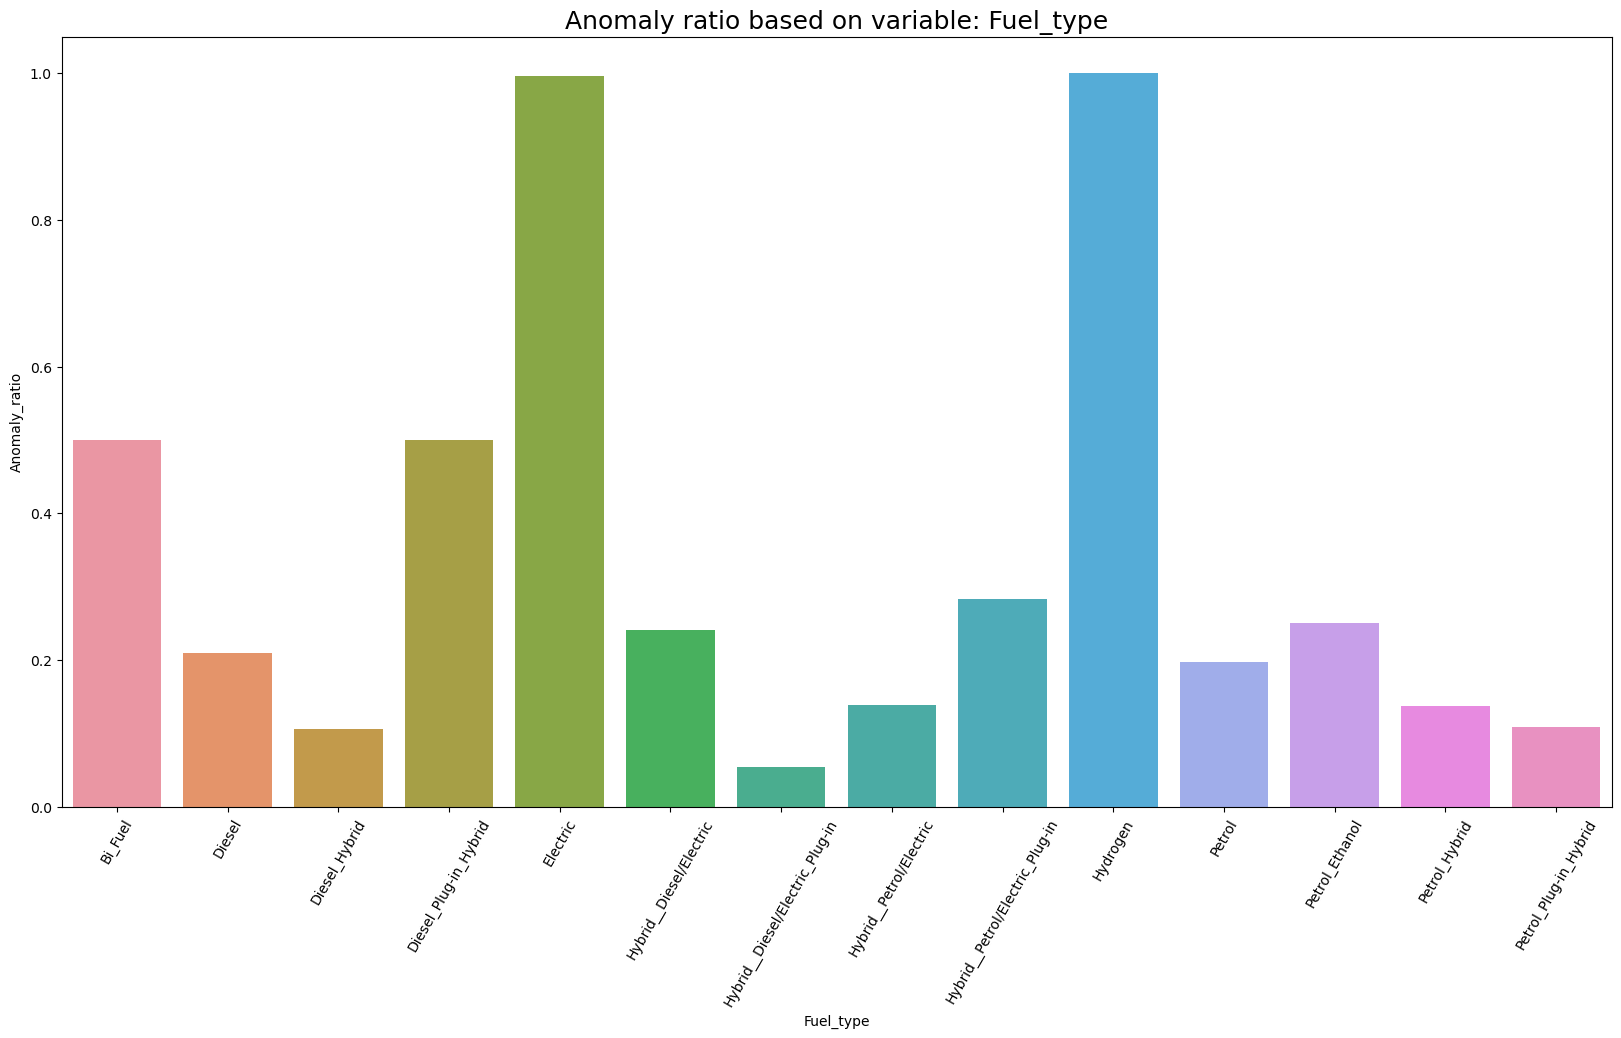

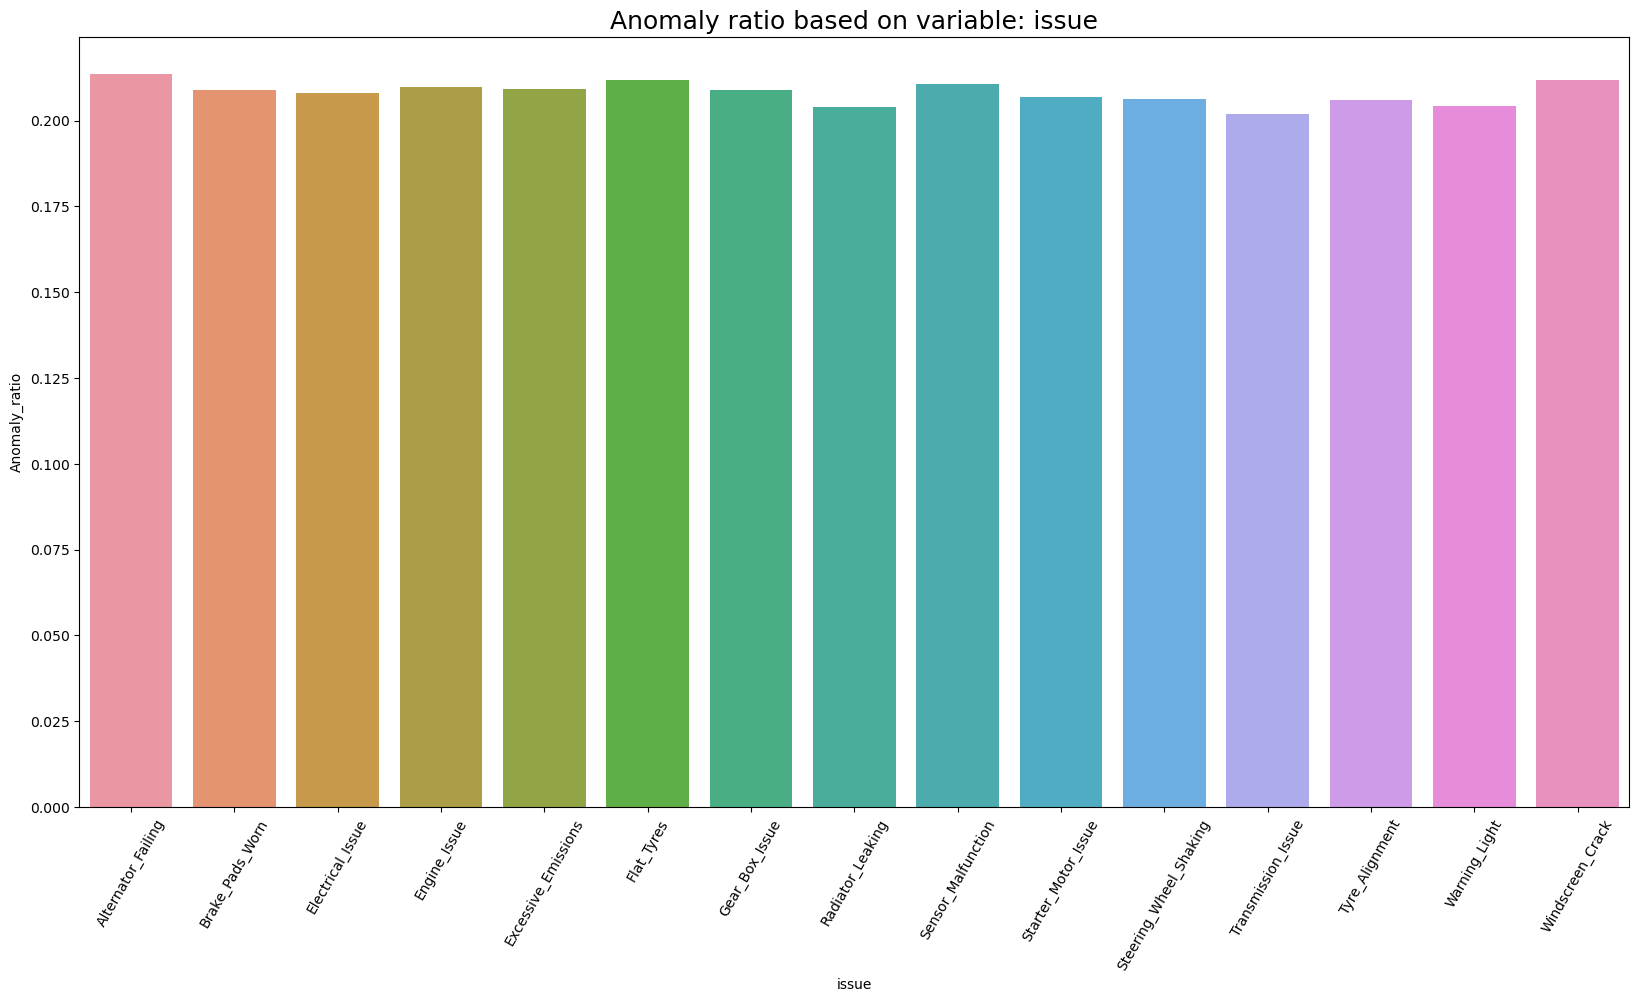

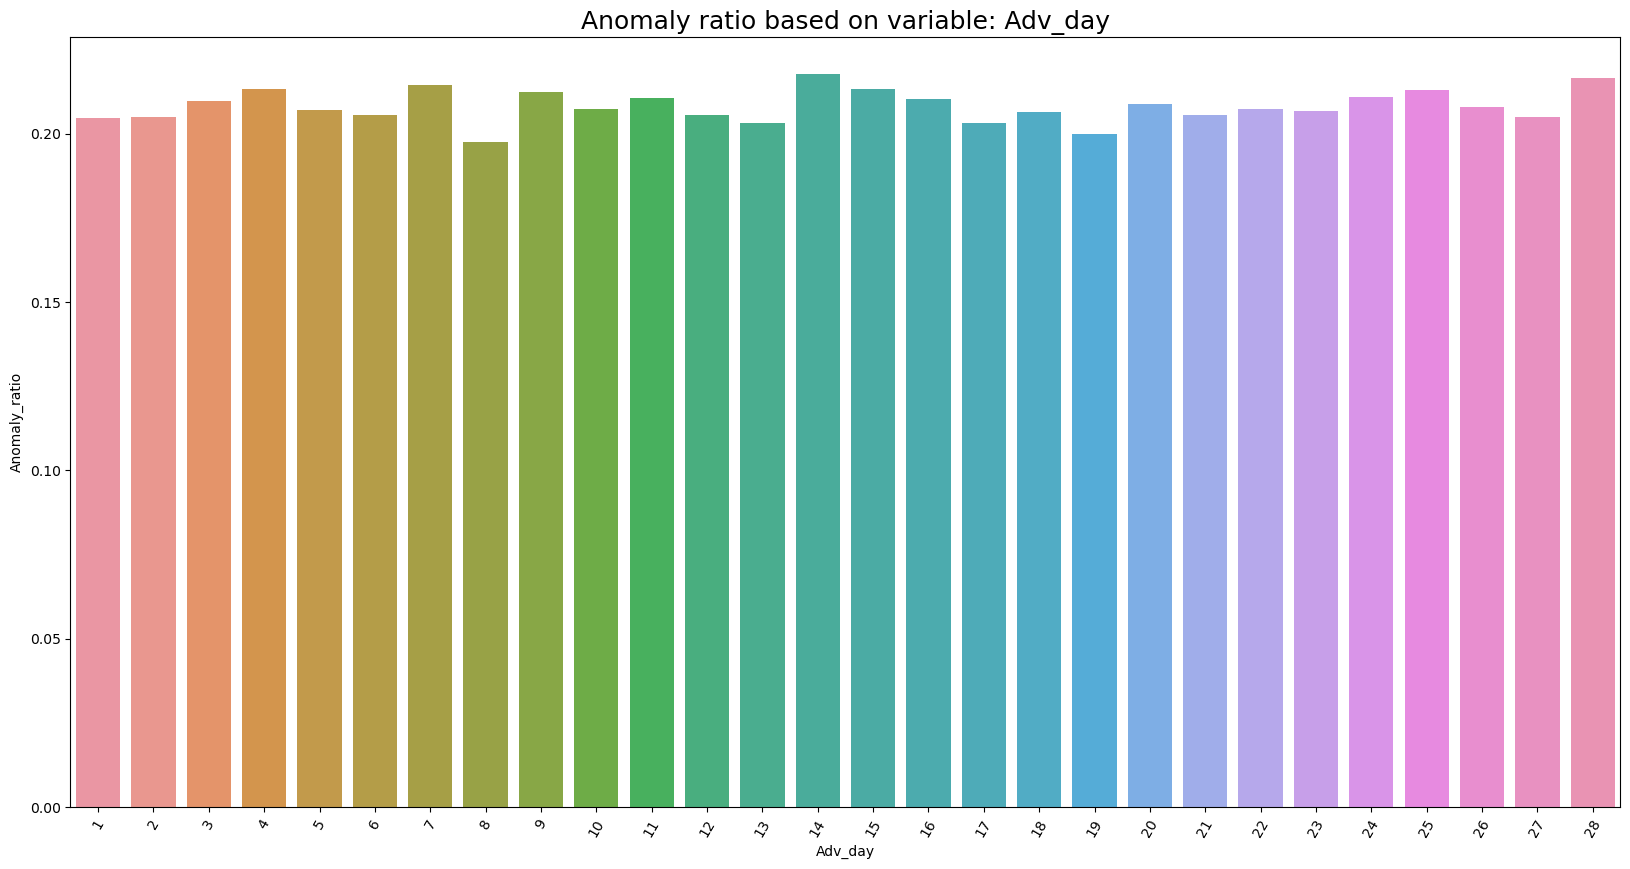

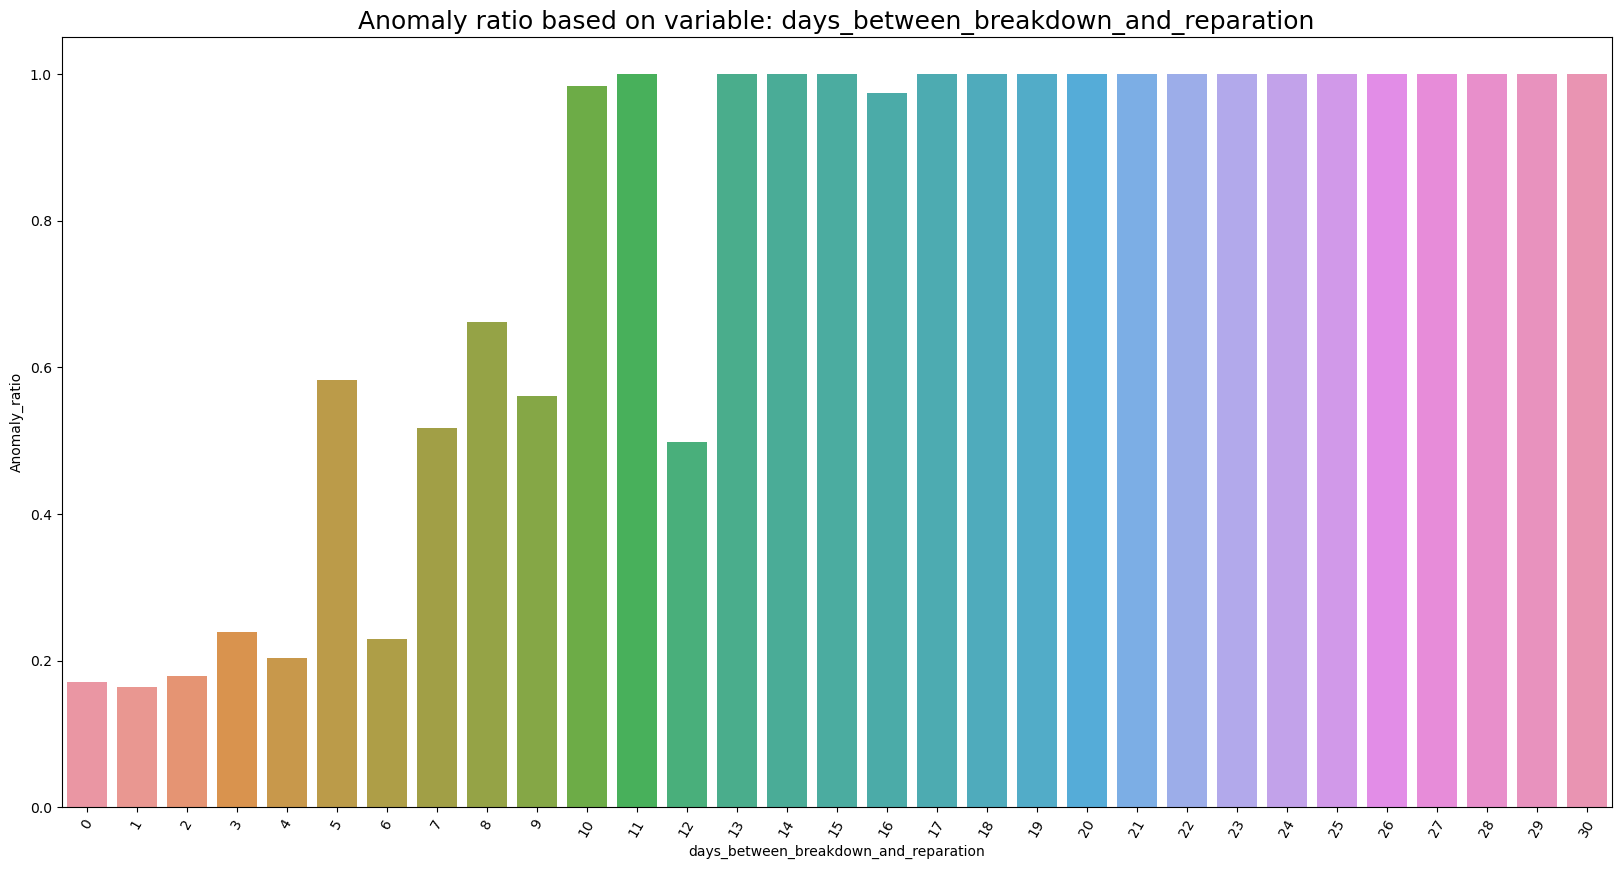

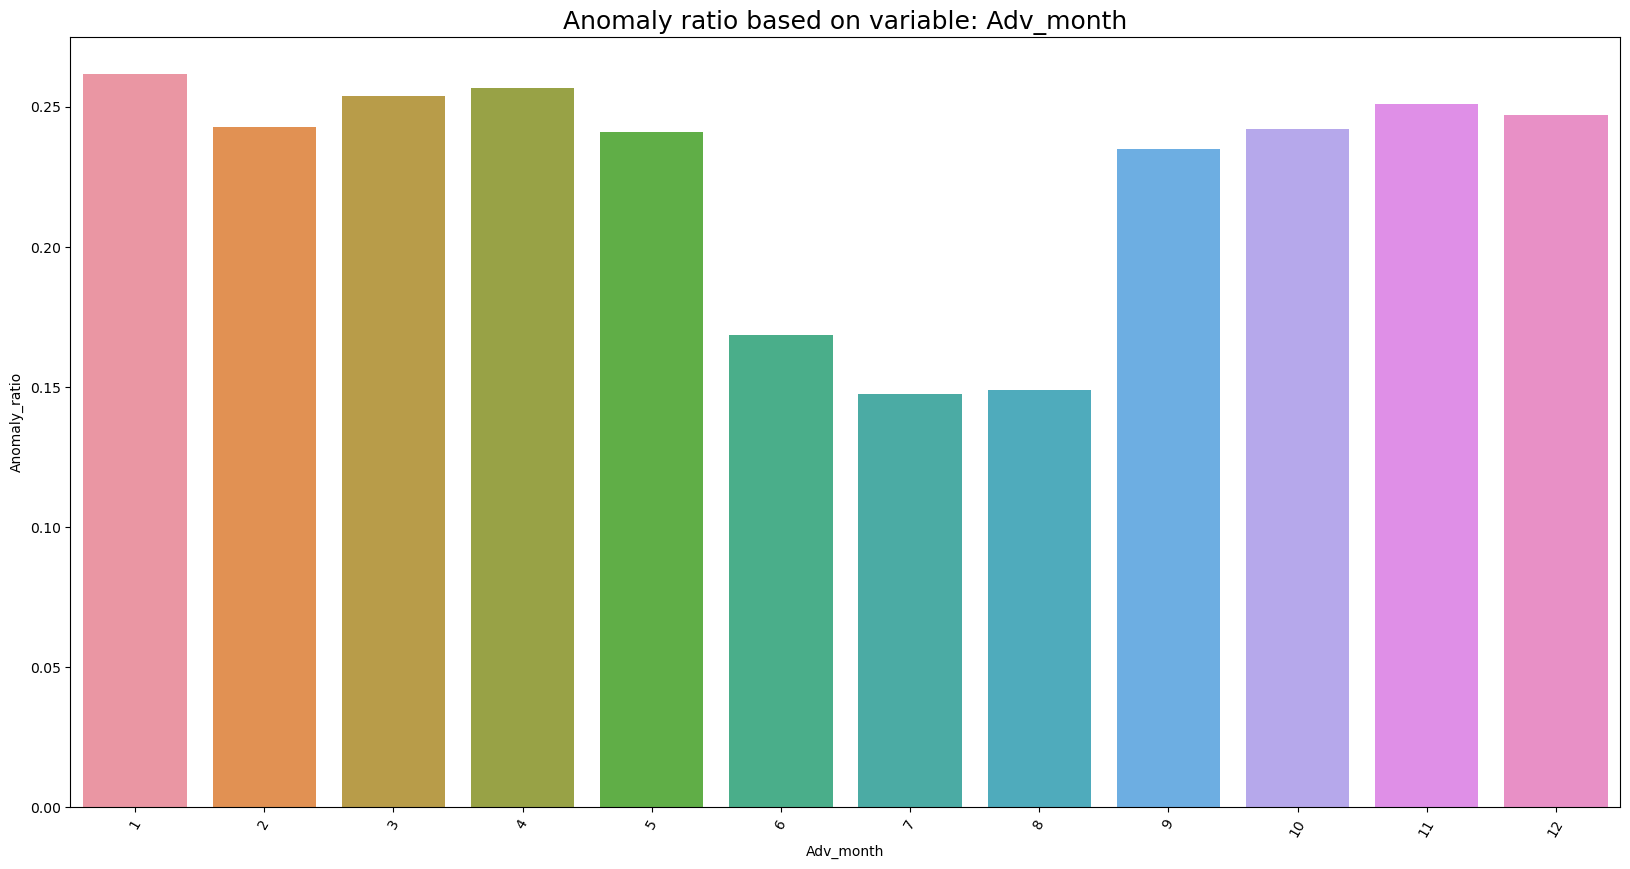

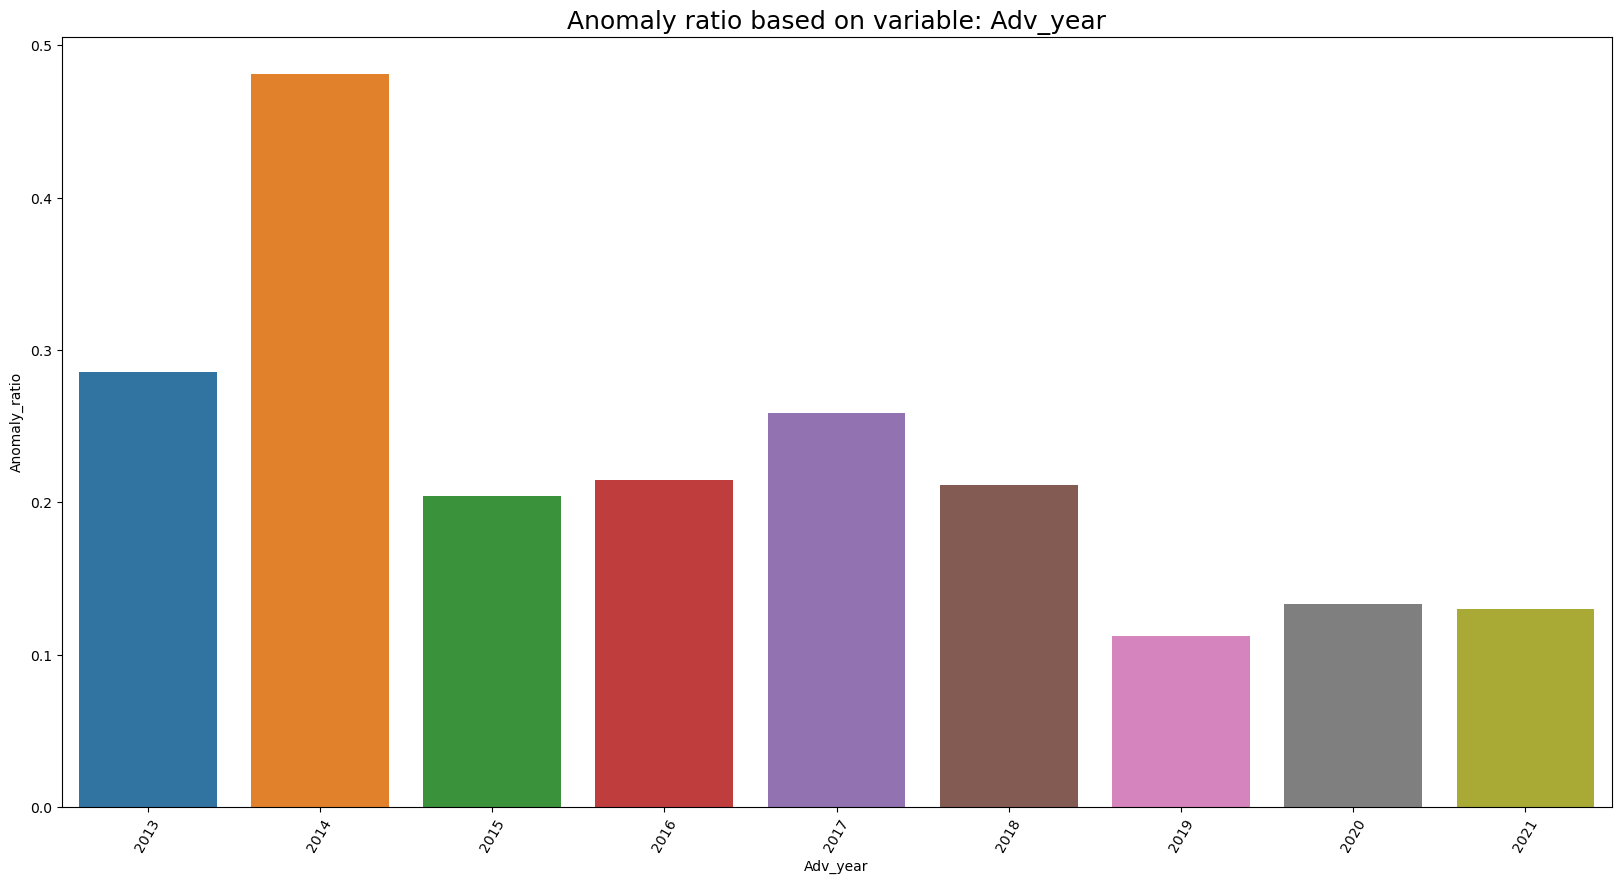

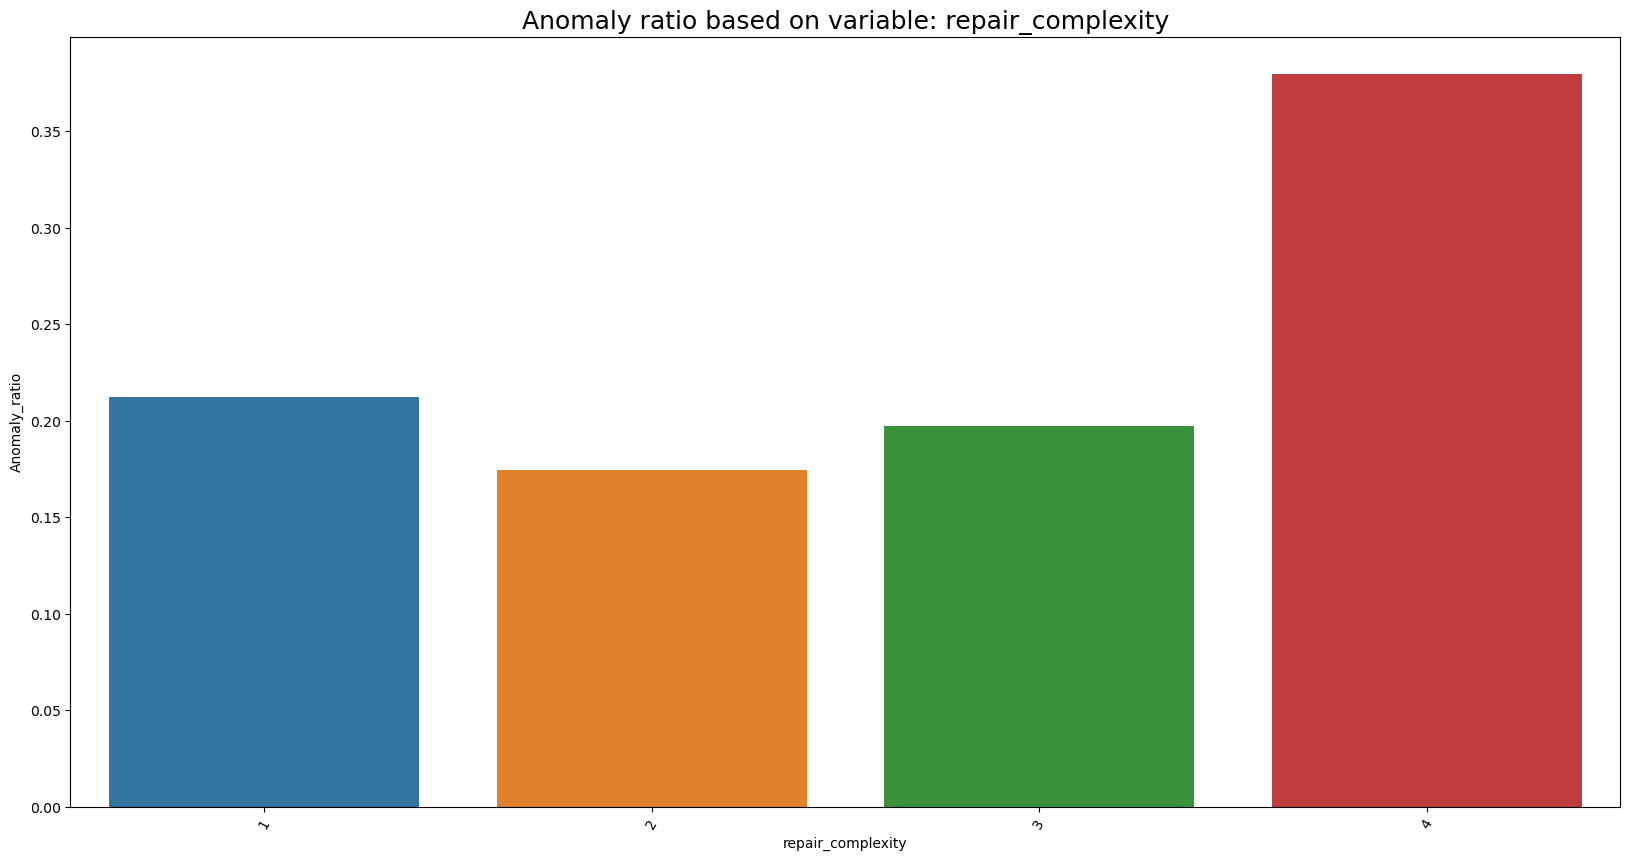

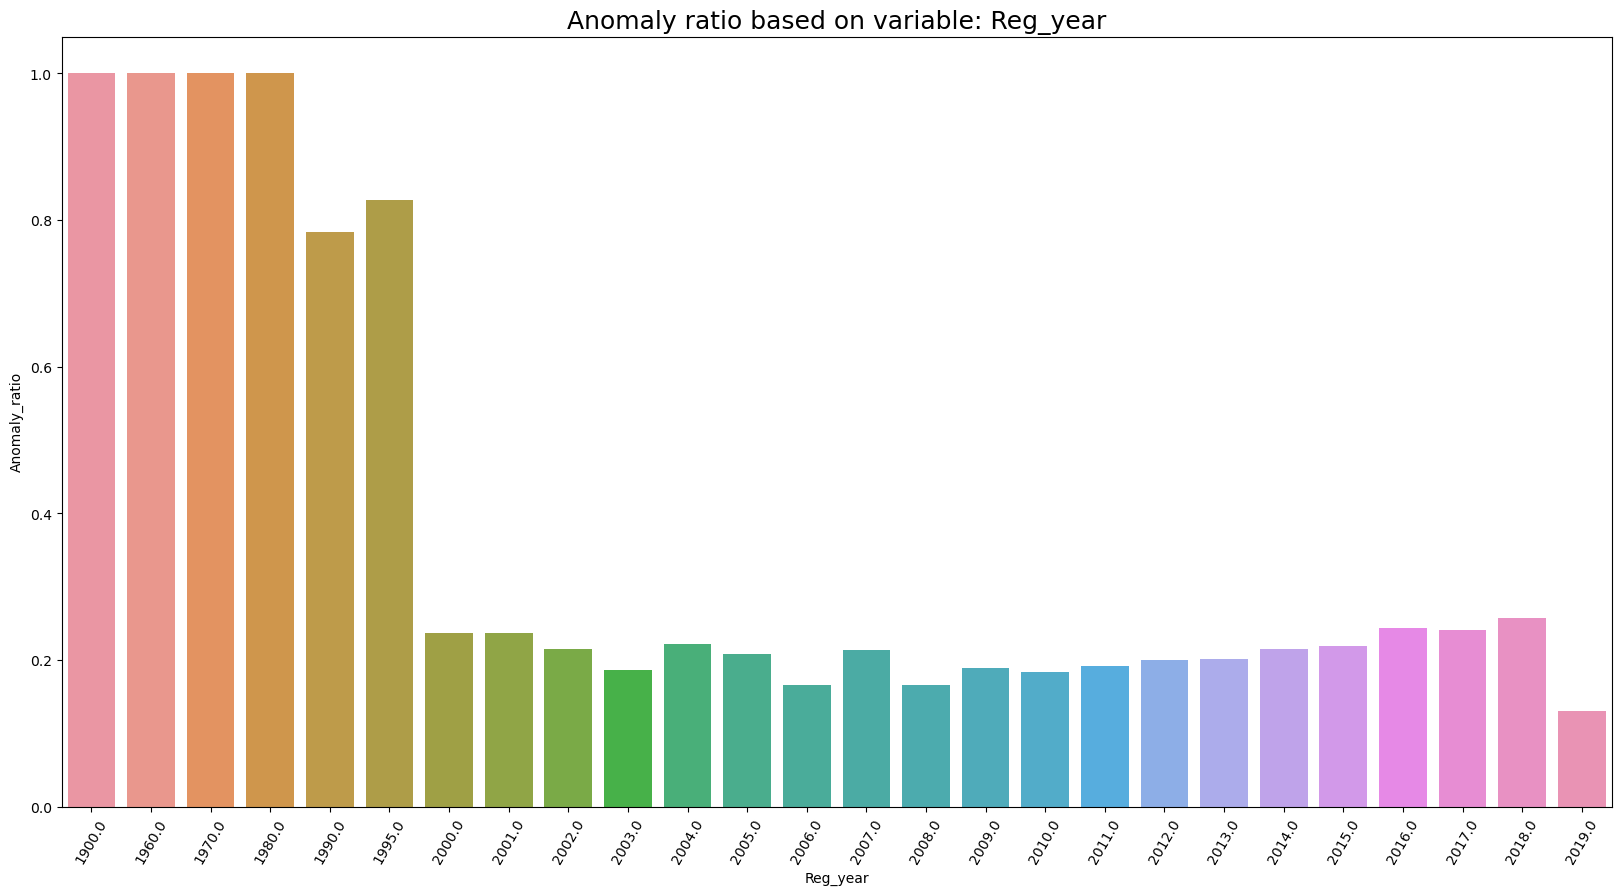

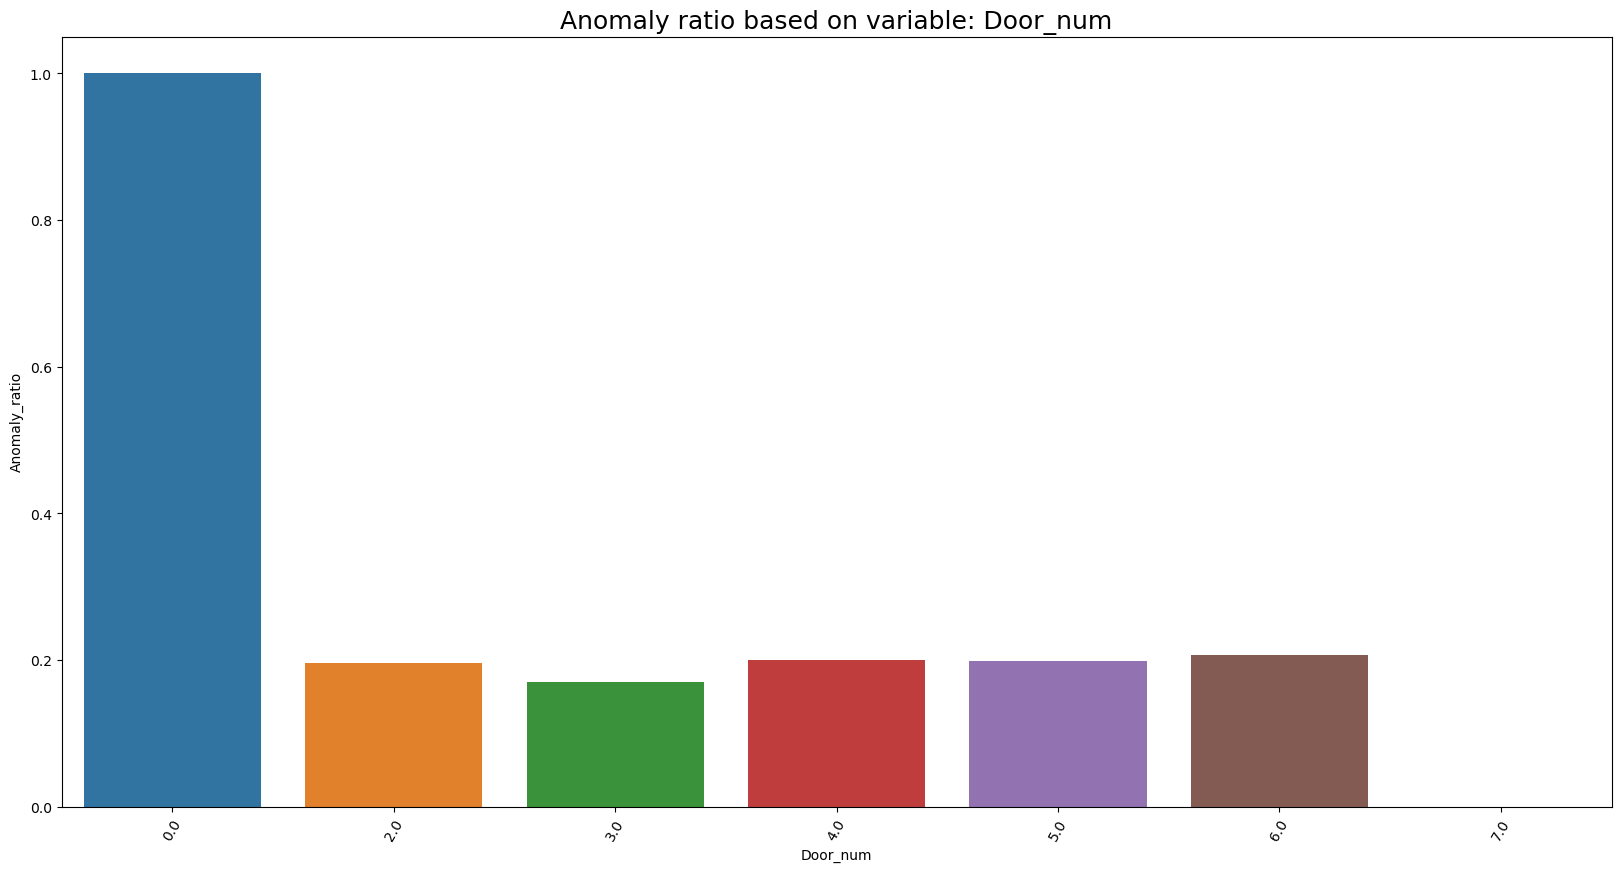

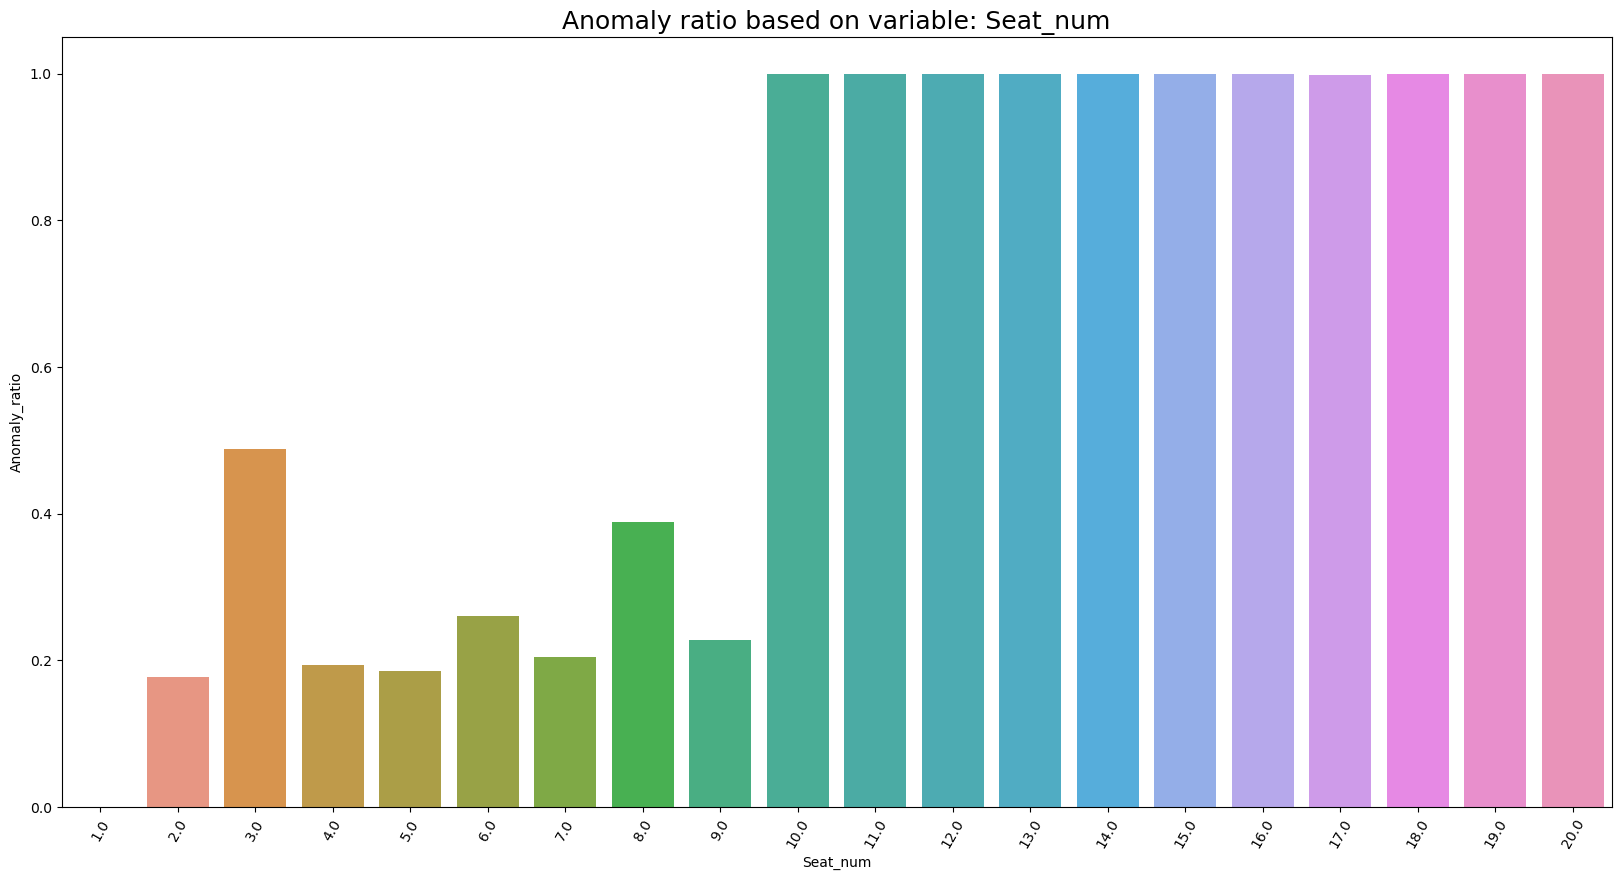

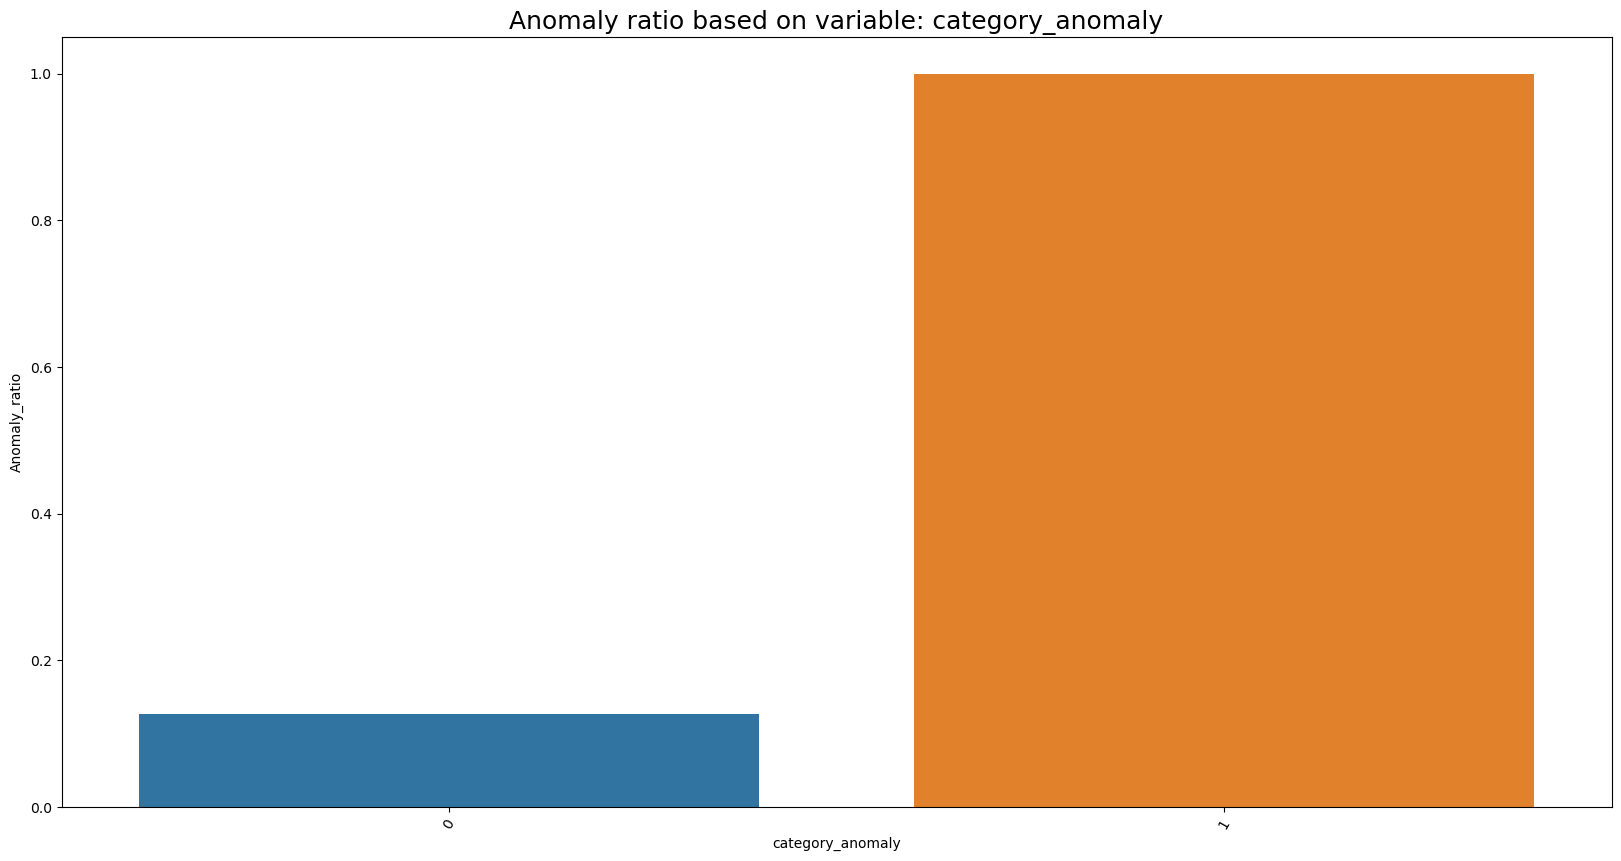

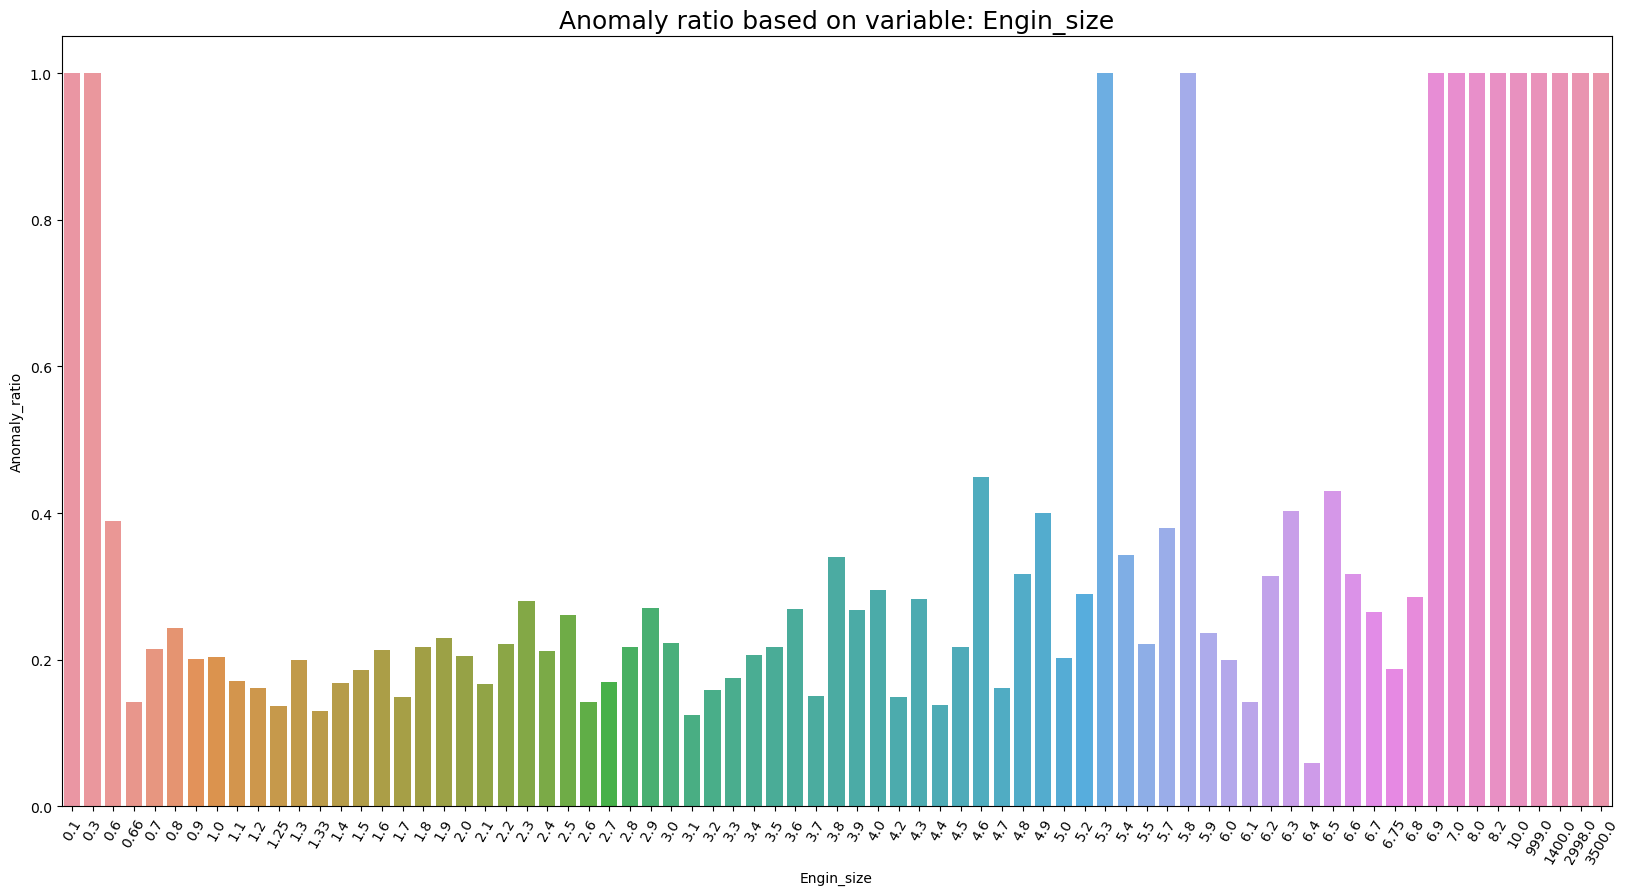

In [11]:
for col in cols_categorical + cols_numerical_discrete:
    plt.figure(figsize=(20, 10))
    df_col0 = df[[f"{col}", "Class"]][df['Class'] == 0].groupby(f"{col}").count().rename(columns={'Class': 'Class_count_0'})
    df_col1 = df[[f"{col}", "Class"]][df['Class'] == 1].groupby(f"{col}").count().rename(columns={'Class': 'Class_count_1'})
    df_col = pd.merge(df_col0, df_col1, left_index=True, right_index=True, how='outer').fillna(0)
    df_col['Class_count'] = df_col['Class_count_0'] + df_col['Class_count_1']
    df_col['Anomaly_ratio'] = df_col['Class_count_1'] / df_col['Class_count']
    sns.barplot(data=df_col, x=df_col.index, y="Anomaly_ratio")
    plt.title(f'Anomaly ratio based on variable: {col}', fontsize=18)
    plt.xticks(rotation=60, fontsize=10)
    plt.show()

### Datetime variables

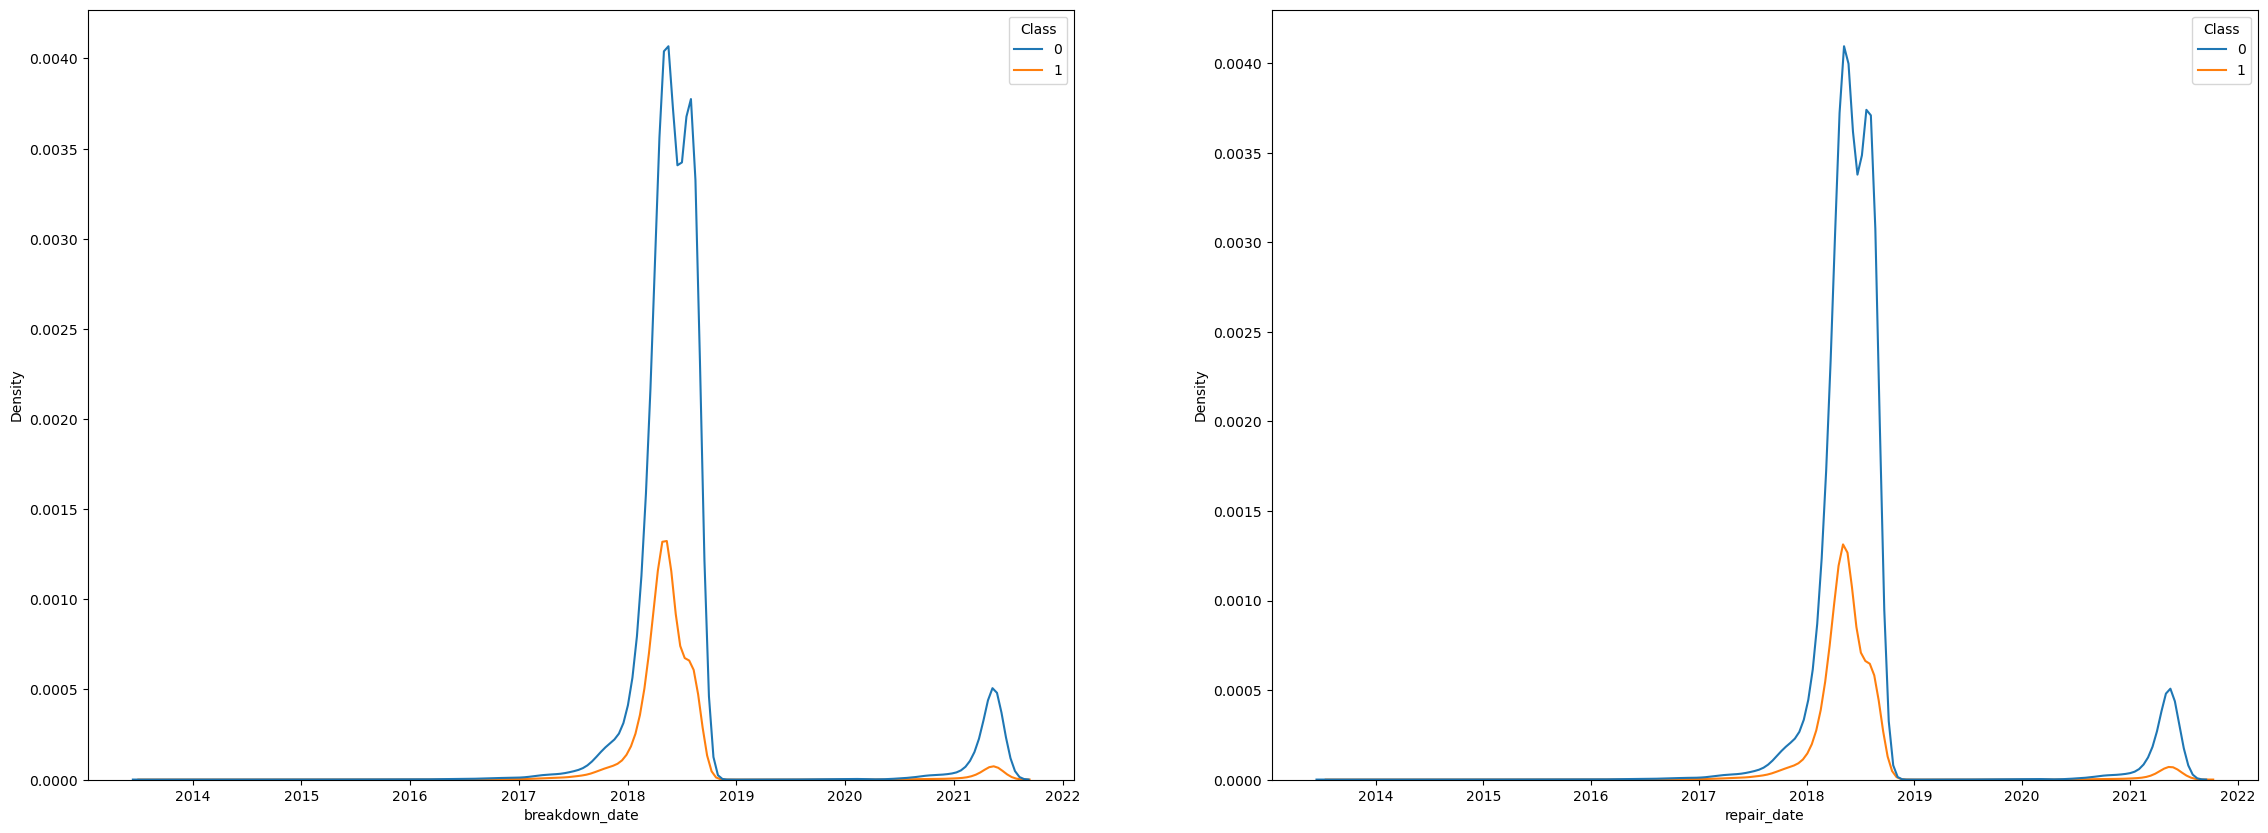

In [12]:
grid = gridspec.GridSpec(1, 2)
plt.figure(figsize=(28, 10))

for i, col in enumerate(cols_datetime):
    ax = plt.subplot(grid[i])
    sns.kdeplot(data=df.sort_values(by=col), x=df[col], hue="Class")
    # plt.xlim(0, np.quantile(df[f'{col}'], 0.95))

plt.show()

In [13]:
df_col.head()

Class_count_0  Class_count_1  Class_count  Anomaly_ratio
Engin_size                                                          
0.10                  0.0              1          1.0       1.000000
0.30                  0.0              1          1.0       1.000000
0.60                 22.0             14         36.0       0.388889
0.66                 12.0              2         14.0       0.142857
0.70                 62.0             17         79.0       0.215190

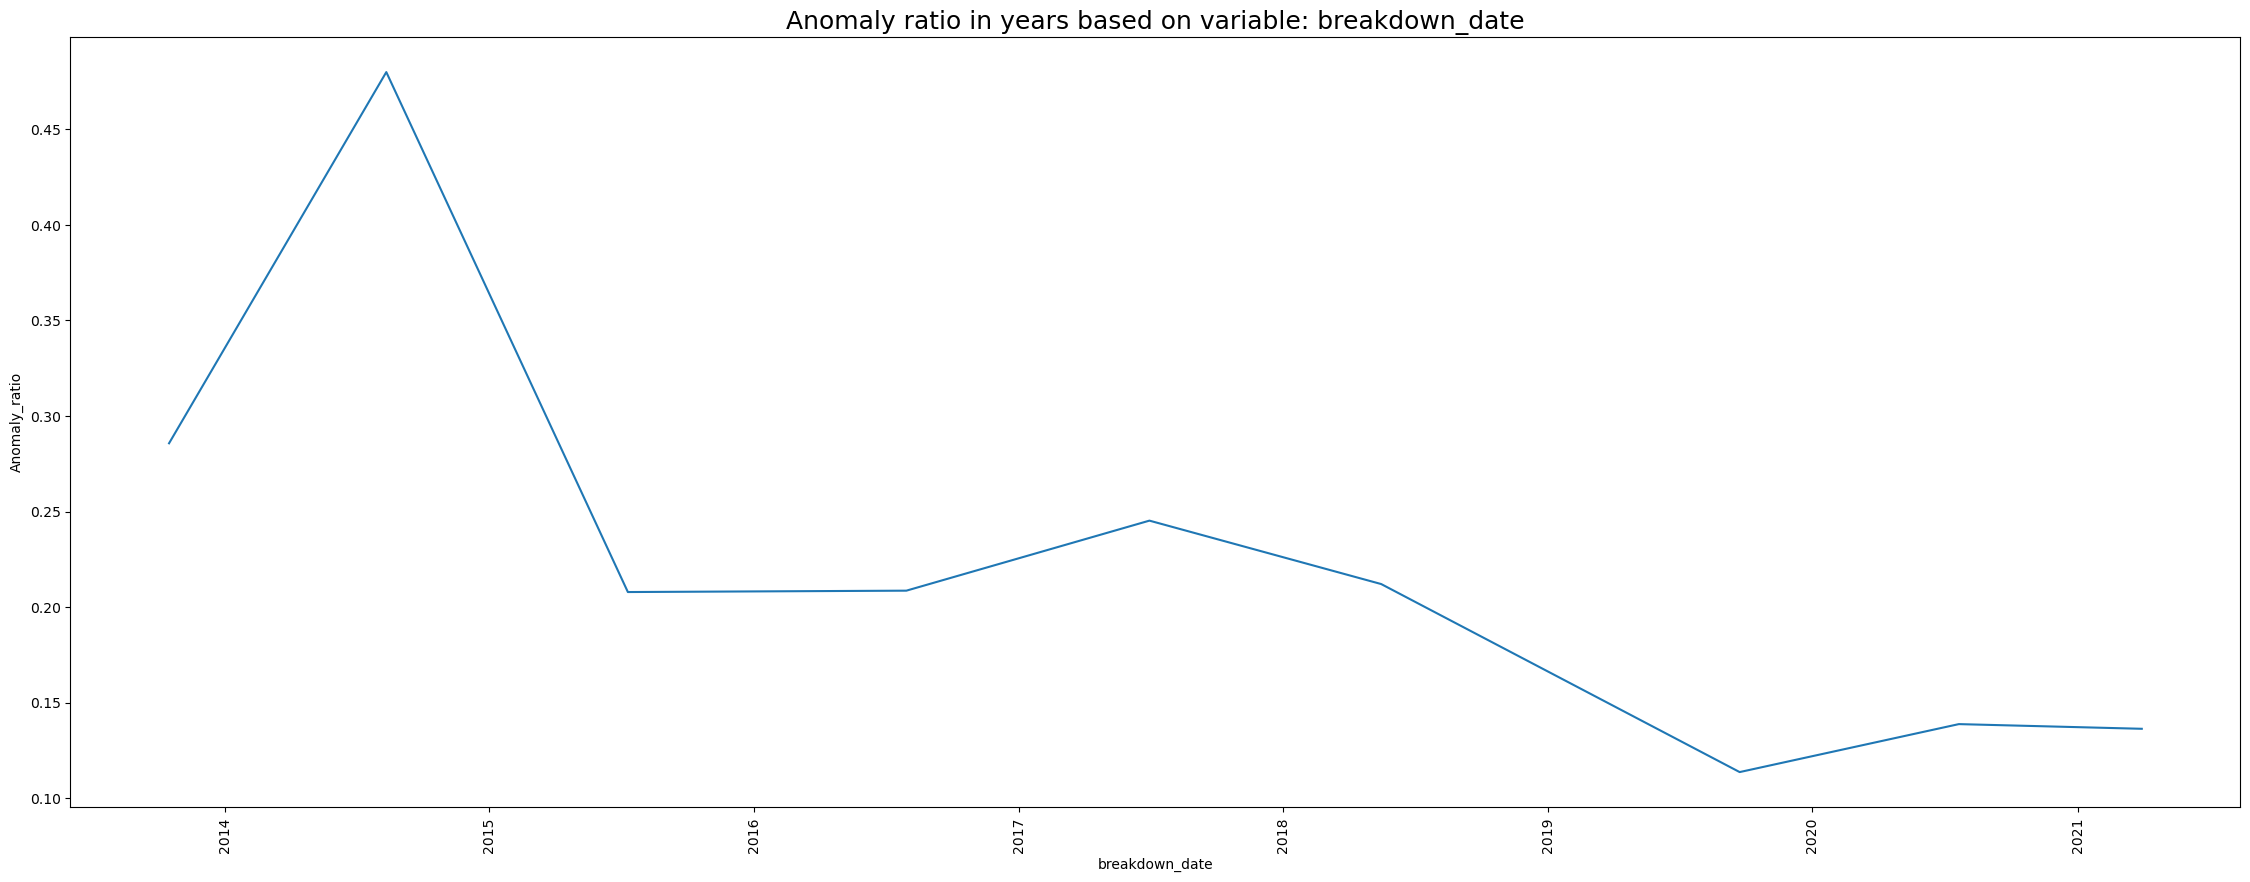

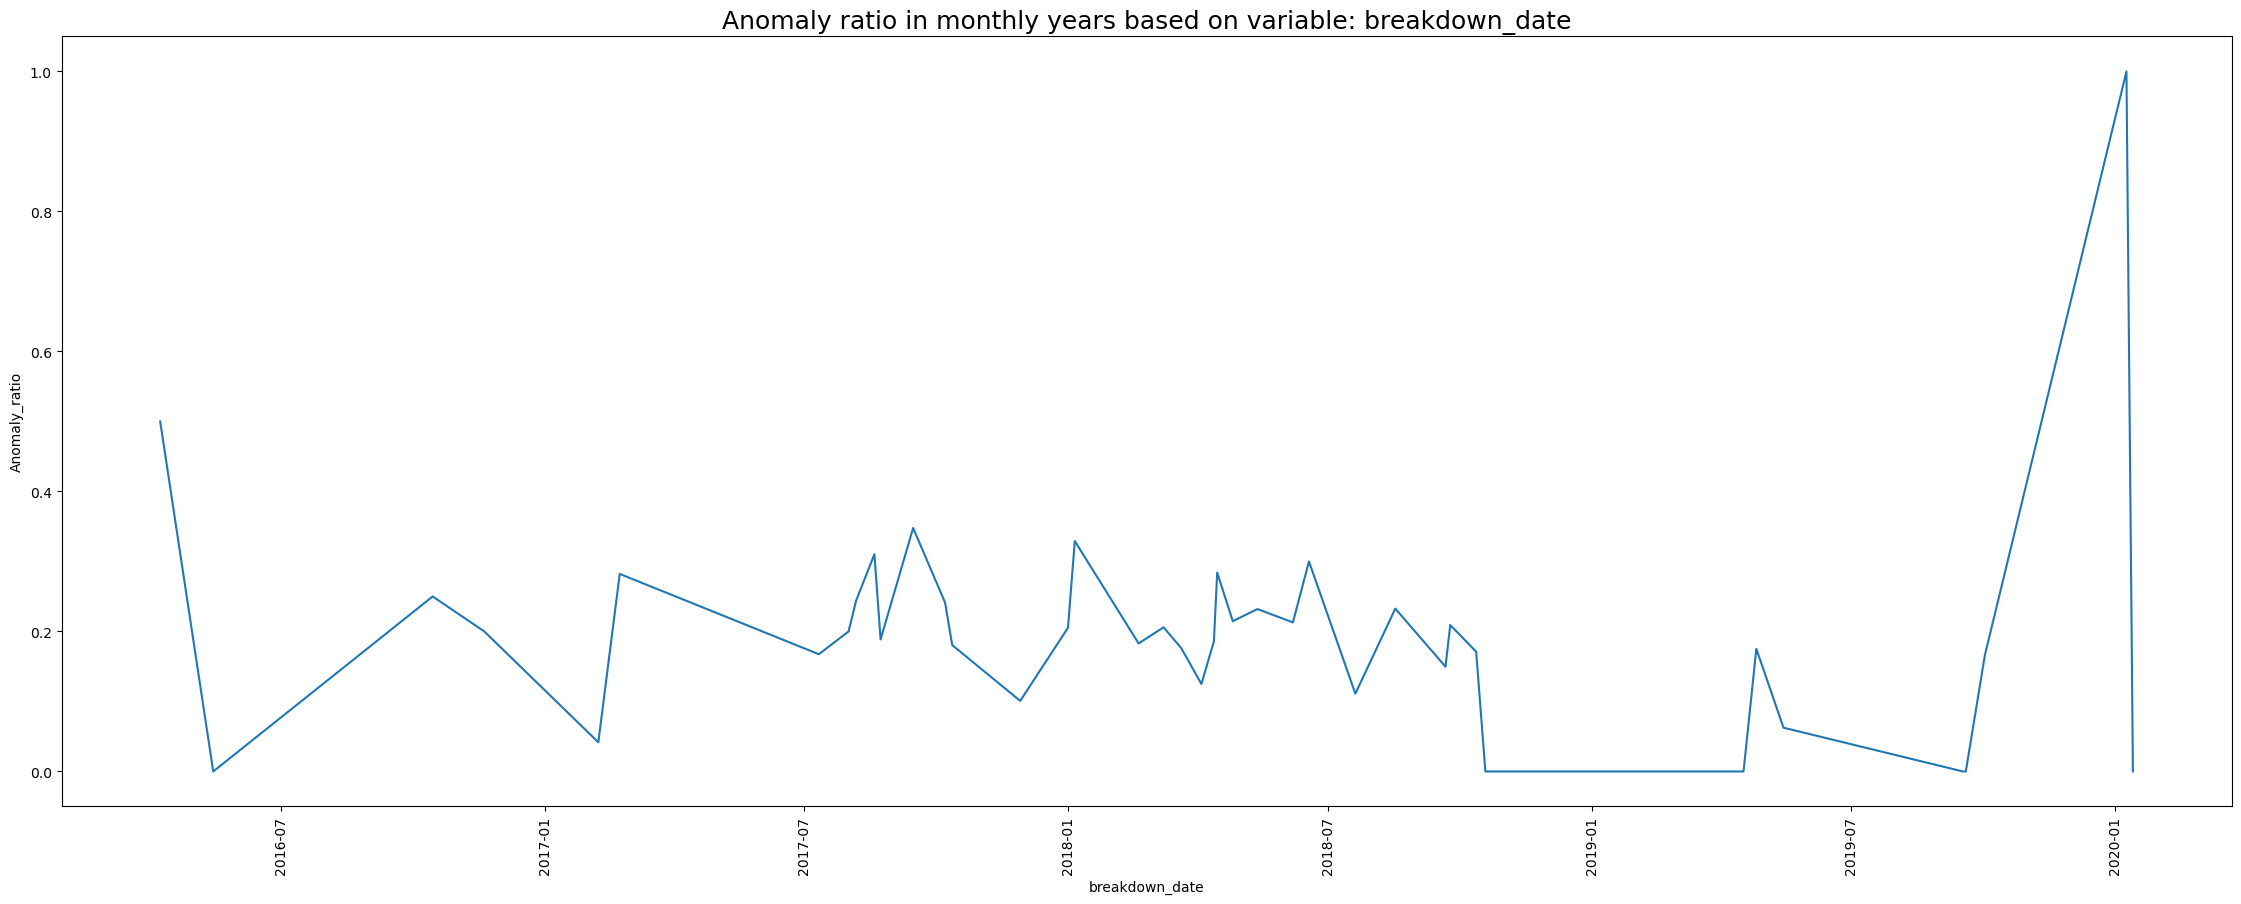

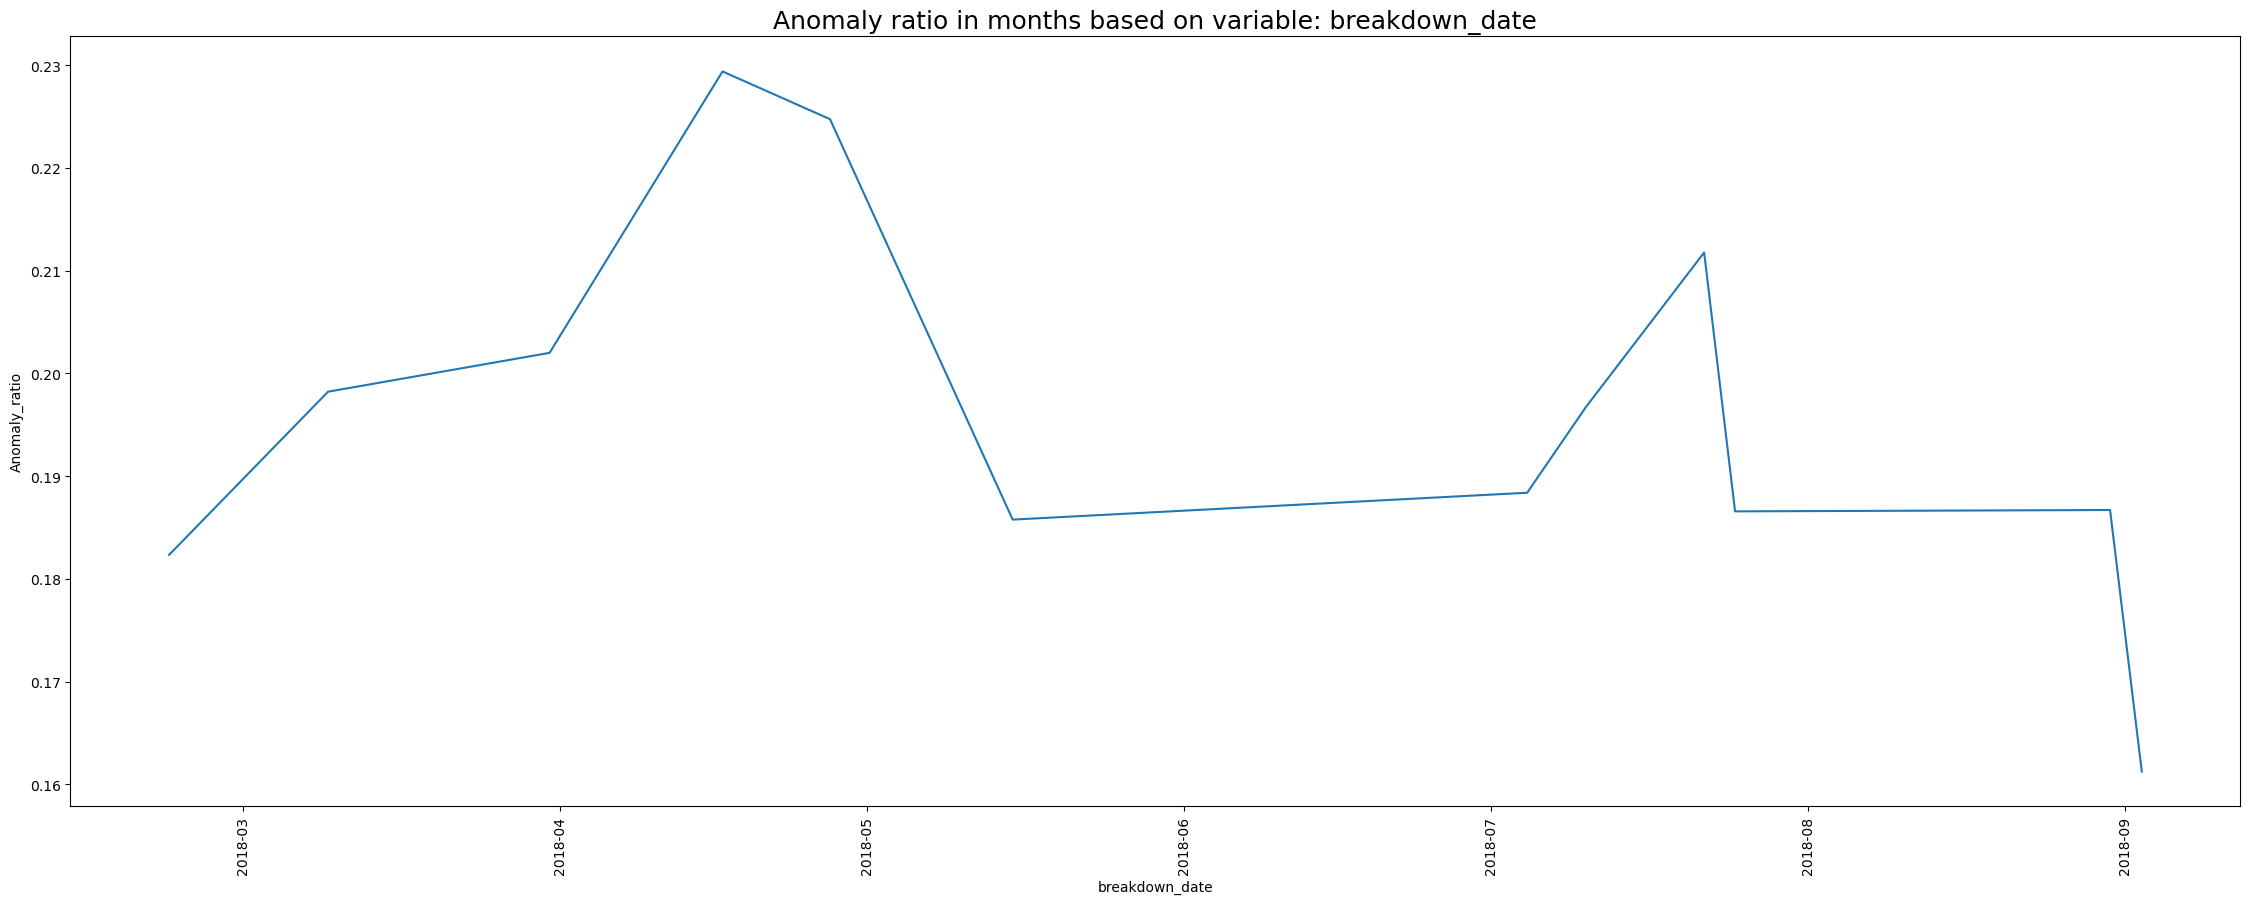

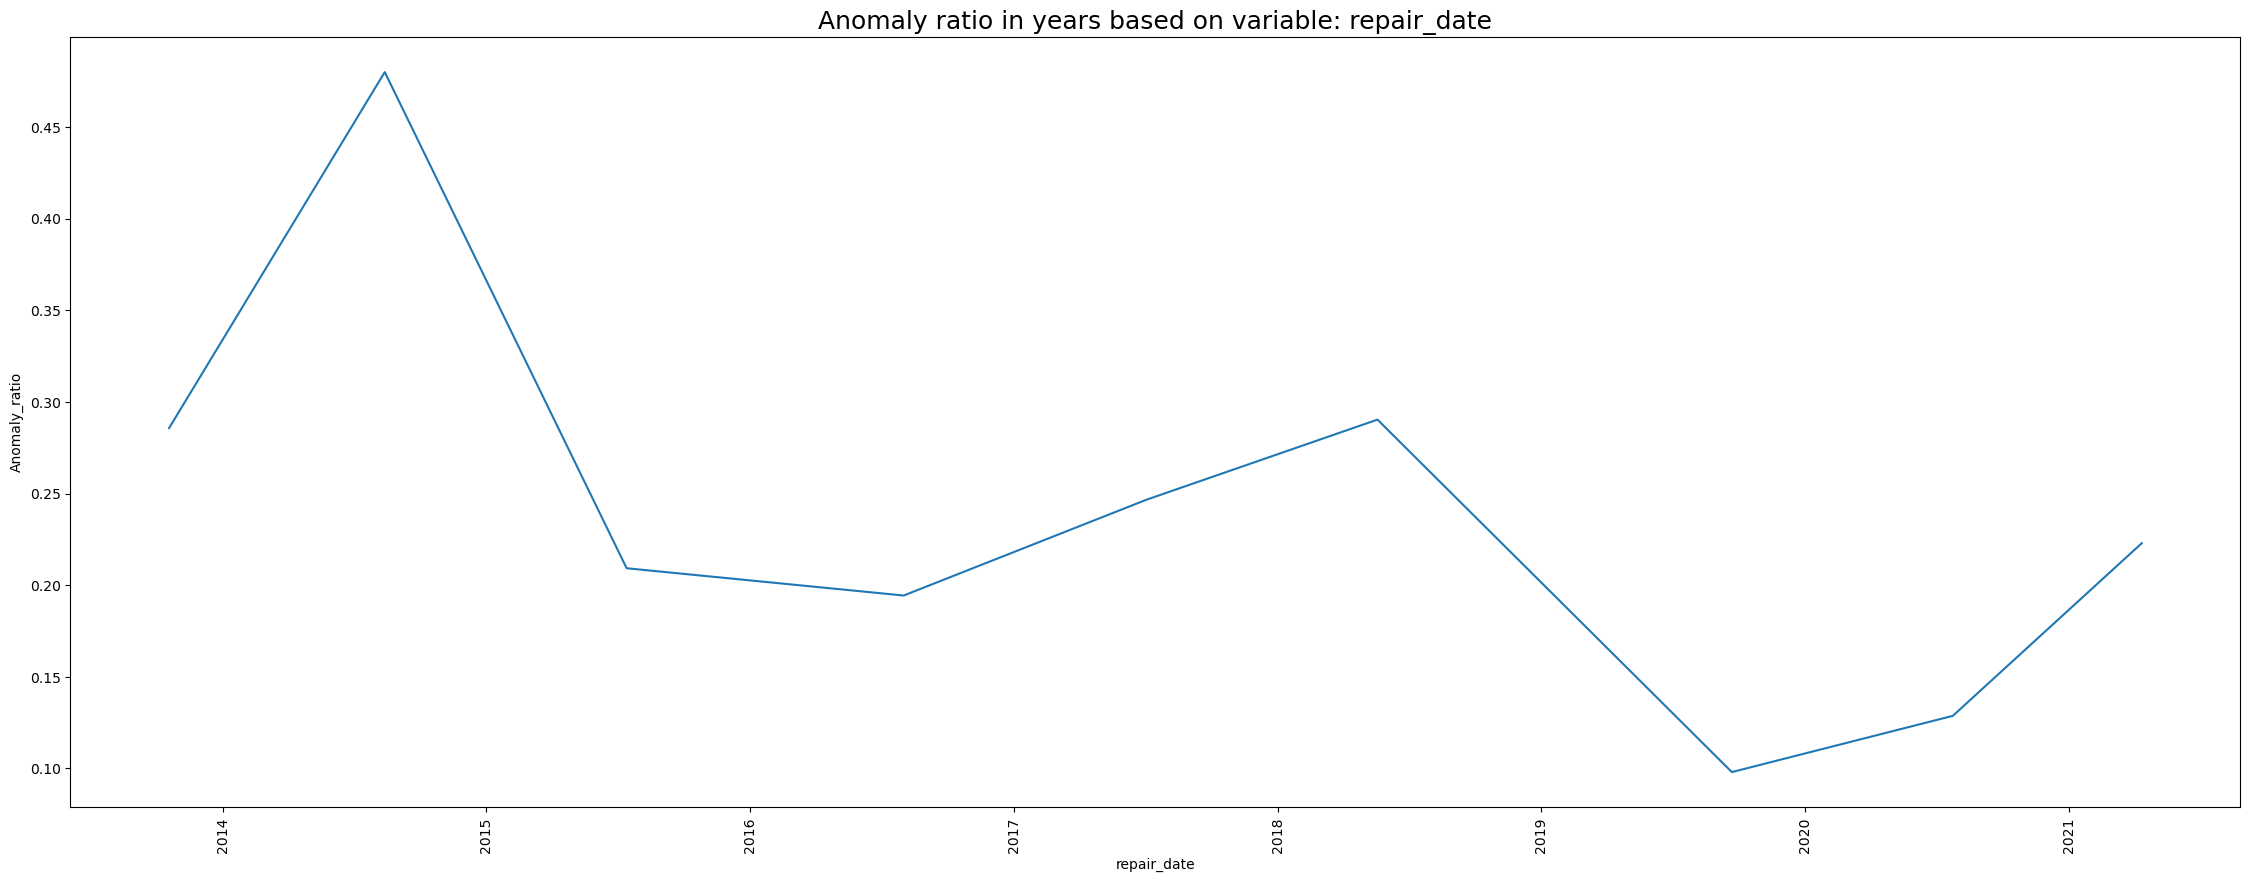

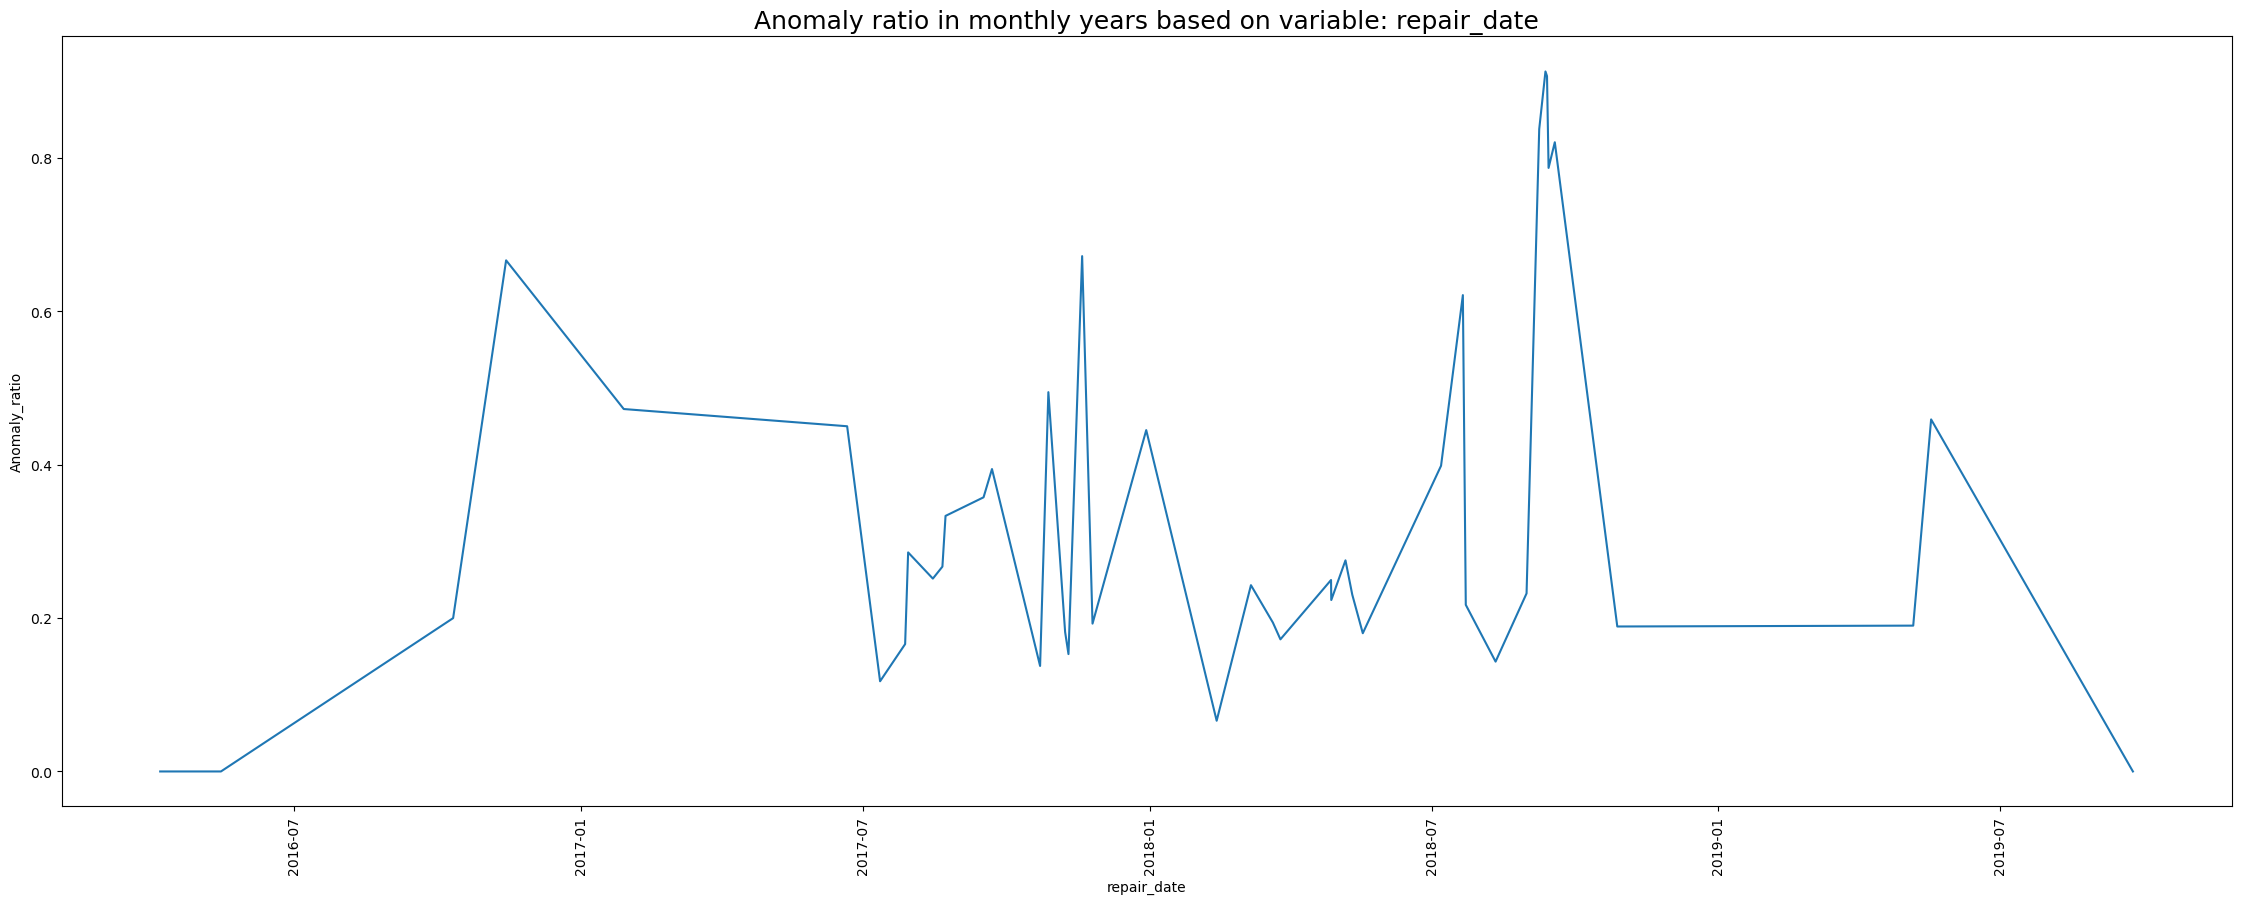

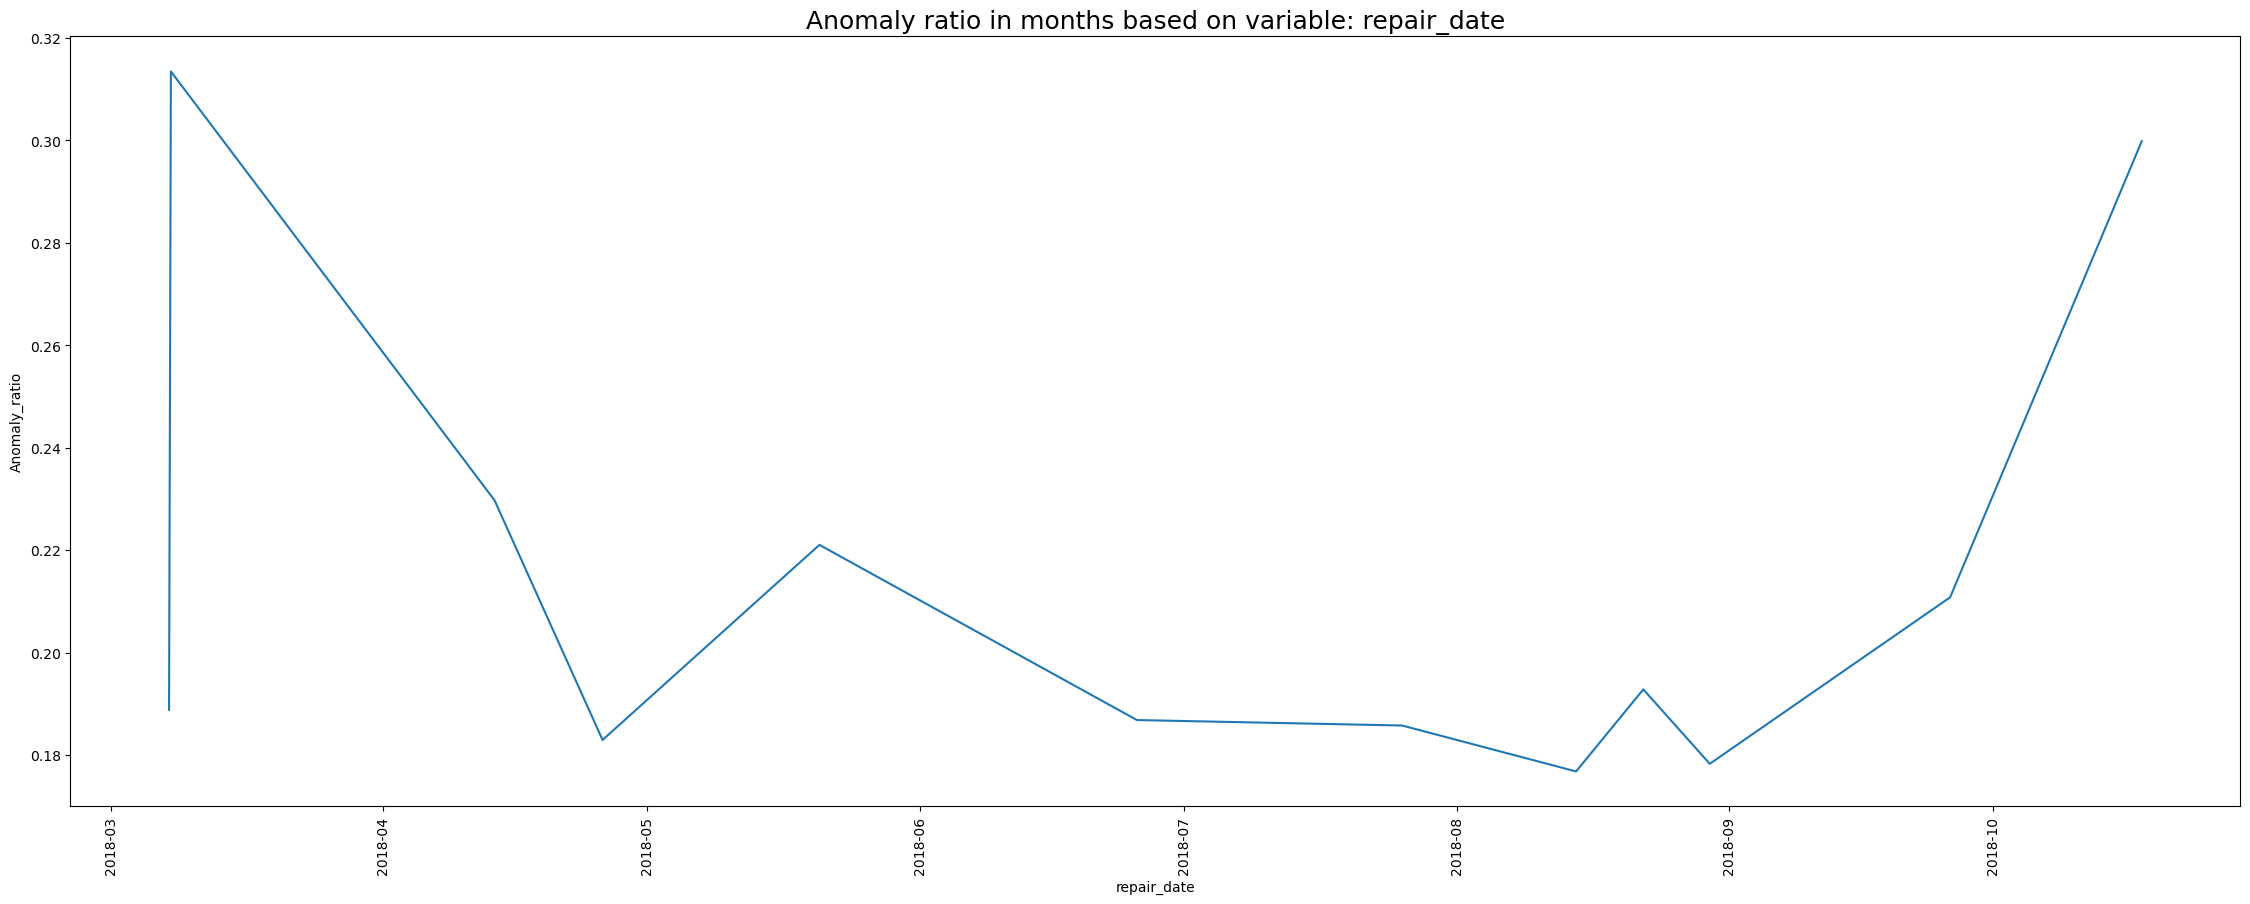

In [14]:
for col in cols_datetime:
    df_col0 = df[[f"{col}", "Class"]][df['Class'] == 0].groupby(f"{col}").count().rename(columns={'Class': 'Class_count_0'})
    df_col1 = df[[f"{col}", "Class"]][df['Class'] == 1].groupby(f"{col}").count().rename(columns={'Class': 'Class_count_1'})
    df_col = pd.merge(df_col0, df_col1, left_index=True, right_index=True, how='outer').fillna(0).reset_index()

    # Add anomaly ratio variable
    df_col[f'{col}_year'] = pd.DatetimeIndex(df_col[f'{col}']).year
    df_col[f'{col}_month'] = pd.DatetimeIndex(df_col[f'{col}']).month
    df_col['Class_count'] = df_col['Class_count_0'] + df_col['Class_count_1']
    df_col['Anomaly_ratio'] = df_col['Class_count_1'] / df_col['Class_count']

    # Add columns with month and year
    df_col[f'{col}_year'] = pd.DatetimeIndex(df_col[col]).year
    df_col[f'{col}_month'] = pd.DatetimeIndex(df_col[col]).month
    df_col[f'{col}_month_year'] = df[f'{col}'].dt.to_period('M')

    # Groupby year average anomaly ratio and plot
    df_col_year = df_col.groupby(f'{col}_year').mean()
    df_col_month = df_col.groupby(f'{col}_month').mean()
    df_col_month_year = df_col.groupby(f'{col}_month_year').mean()    # [f'{col}_monthly_year'].dt.to_period('M')

    # Show years
    plt.figure(figsize=(28, 10))
    sns.lineplot(data=df_col_year, x=col, y="Anomaly_ratio")
    plt.title(f'Anomaly ratio in years based on variable: {col}', fontsize=18)
    plt.xticks(rotation=90, fontsize=10)
    plt.show()

    # Show mohtly years
    plt.figure(figsize=(28, 10))
    sns.lineplot(data=df_col_month_year, x=col, y="Anomaly_ratio")
    plt.title(f'Anomaly ratio in monthly years based on variable: {col}', fontsize=18)
    plt.xticks(rotation=90, fontsize=10)
    plt.show()

    # Show months
    plt.figure(figsize=(28, 10))
    sns.lineplot(data=df_col_month, x=col, y="Anomaly_ratio")
    plt.title(f'Anomaly ratio in months based on variable: {col}', fontsize=18)
    plt.xticks(rotation=90, fontsize=10)
    plt.show()

In [15]:
for col in cols_datetime:    
    df[f'{col}_year'] = pd.DatetimeIndex(df[col]).year
    df[f'{col}_month'] = pd.DatetimeIndex(df[col]).month

df.drop(['breakdown_date', 'repair_date'],  axis=1, inplace=True)
df.columns

Index(['Maker', 'Adv_year', 'Adv_month', 'Color', 'Reg_year', 'Bodytype',
       'Runned_Miles', 'Engin_size', 'Gearbox', 'Fuel_type', 'Price',
       'Seat_num', 'Door_num', 'issue', 'Adv_day', 'repair_complexity',
       'repair_cost', 'repair_hours', 'category_anomaly', 'Class',
       'days_between_breakdown_and_reparation', 'breakdown_date_year',
       'breakdown_date_month', 'repair_date_year', 'repair_date_month'],
      dtype='object')

## Feature Engineering
- Transform all categorical variables to dummy variables (one-hot encoding)
- Scale and Transform for all variables
- Use standard scaler and PCA

### Features transformation
- categorical to label encoding or one hot encoding

In [16]:
df_encoded = pd.get_dummies(df, columns=cols_categorical, dtype=int)
cols_variables_dummies = list(set(df_encoded.columns).difference(set(["Class"])))
len(cols_variables_dummies)

181

### Explained Variance Ratio
- need to scale features

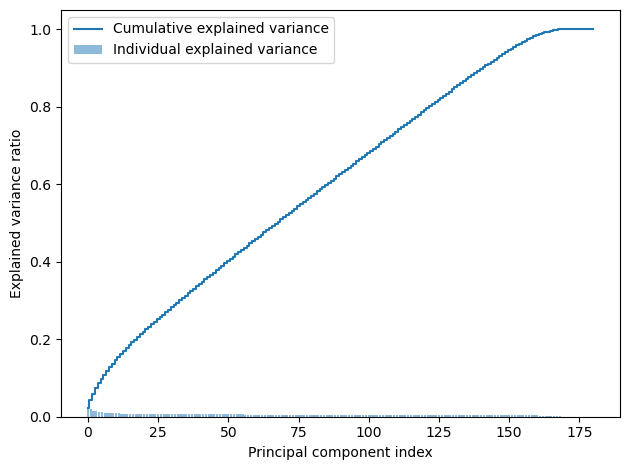

In [17]:
# models
sc = StandardScaler()
pca = PCA()

# prepare data to transform
X_train = df_encoded[cols_variables_dummies]

# transform SC and PCA
X_train_sc = sc.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_sc)

# compute explained variance ratio
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# create the visualization plot
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### PCA of all features for visualisation
- PCA for visualisation with two dimensions

<Axes: xlabel='pca_1', ylabel='pca_2'>

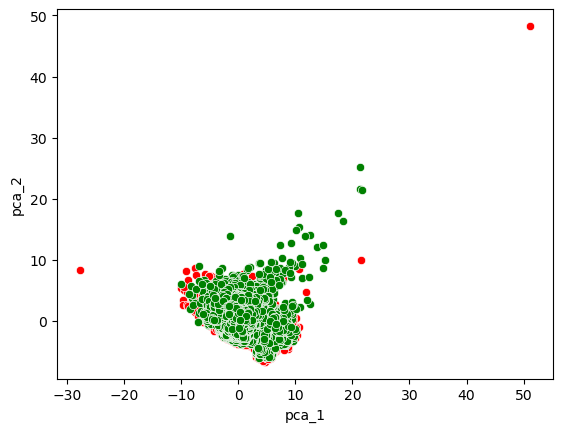

In [18]:
targets = df["Class"].to_numpy().reshape(-1, 1)
pca_n2 = PCA(n_components=2)
X_train_pca_n2 = pca_n2.fit_transform(X_train_sc)
result_np = np.concatenate((X_train_pca_n2, targets), axis=1)
result_df = pd.DataFrame(result_np, columns=['pca_1', 'pca_2', 'target'])

sns.scatterplot(data=result_df[result_df["target"]== 0], x="pca_1", y="pca_2", color='r')
sns.scatterplot(data=result_df[result_df["target"]== 1], x="pca_1", y="pca_2", color='g')

### tSNE of all features

In [19]:
tsne_compute = False

if tsne_compute:
    tsne = TSNE(n_components=2, learning_rate=100, perplexity=30, angle=0.2, verbose=2, n_iter=250, n_iter_without_progress=50, random_state=42).fit_transform(X_train_sc)
    tx, ty = tsne[:, 0], tsne[:, 1]
    tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))

    result_np = np.concatenate((tx.reshape(-1, 1), ty.reshape(-1, 1), targets), axis=1)
    result_df = pd.DataFrame(result_np, columns=['tsne_1', 'tsne_2', 'target'])

    sns.scatterplot(data=result_df[result_df["target"]== 0], x="tsne_1", y="tsne_2", color='r')
    sns.scatterplot(data=result_df[result_df["target"]== 1], x="tsne_1", y="tsne_2", color='g')

## 2. Features Selection
- in a case we know targets (if not, we use all variables)
- compute p-values
- H0: There is no difference (insignificant): p_value > 0.05
- H1: There is a difference (significant): p_value <= 0.05

In [33]:
pd.options.display.max_rows = 190
df_corr = pd.DataFrame(columns=['r', 'p_value'])

for col in cols_variables_dummies:
    r, p = pearsonr(df_encoded["Class"], df_encoded[col])
    df_corr.loc[col] = [round(r, 3), round(p, 3)]


df_corr.sort_values(by=['p_value'])

r  p_value
Maker_Ford                                 0.022    0.000
Maker_Volvo                               -0.008    0.000
Bodytype_Window_Van                        0.009    0.000
Color_Yellow                              -0.019    0.000
Maker_Infiniti                             0.007    0.000
Reg_year                                   0.018    0.000
Maker_Lincoln                              0.008    0.000
Color_Turquoise                           -0.007    0.000
Color_Blue                                -0.073    0.000
Gearbox_Manual                            -0.023    0.000
Maker_Tesla                                0.031    0.000
Door_num                                  -0.114    0.000
Maker_Mazda                                0.063    0.000
Maker_Jaguar                              -0.019    0.000
days_between_breakdown_and_reparation      0.358    0.000
Maker_Maserati                             0.007    0.000
Fuel_type_Hydrogen                         0.075    0.000
repair_complexity                         -0.012    0.000
Maker_Citroen                             -0.031    0.000
Maker_Fiat                                -0.027    0.000
Gearbox_Automatic                          0.019    0.000
repair_hours                               0.141    0.000
Maker_BMW                                  0.014    0.000
Maker_Vauxhall                            -0.009    0.000
Color_Brown                               -0.022    0.000
Maker_Morgan                               0.007    0.000
Adv_month                                 -0.082    0.000
Maker_McLaren                              0.014    0.000
Bodytype_Manual                            0.008    0.000
Maker_Alfa_Romeo                          -0.014    0.000
repair_date_year                          -0.052    0.000
Fuel_type_Hybrid__Petrol/Electric         -0.022    0.000
Adv_year                                  -0.053    0.000
Color_Red                                 -0.063    0.000
Fuel_type_Petrol_Plug-in_Hybrid           -0.008    0.000
Gearbox_Hybrid                             0.047    0.000
Bodytype_Minibus                           0.007    0.000
Maker_Jeep                                 0.013    0.000
Maker_DS                                  -0.007    0.000
Maker_Honda                               -0.022    0.000
Maker_Land_Rover                          -0.010    0.000
Maker_Volkswagen                           0.016    0.000
repair_date_month                         -0.064    0.000
Maker_Kia                                 -0.024    0.000
Maker_Porsche                              0.021    0.000
Color_Beige                               -0.020    0.000
Color_Multicolour                         -0.007    0.000
Fuel_type_Bi_Fuel                          0.007    0.000
Maker_Mercedes-Benz                       -0.019    0.000
Fuel_type_Electric                         0.136    0.000
Bodytype_Saloon                           -0.015    0.000
Color_Bronze                              -0.011    0.000
Color_Black                               -0.080    0.000
Maker_Isuzu                                0.040    0.000
Maker_Chrysler                            -0.008    0.000
Bodytype_Panel_Van                         0.024    0.000
Maker_Lamborghini                          0.023    0.000
Price                                      0.040    0.000
Fuel_type_Petrol                          -0.024    0.000
Color_Gold                                -0.013    0.000
Maker_SKODA                                0.010    0.000
Maker_Ferrari                              0.017    0.000
Bodytype_Hatchback                        -0.018    0.000
Color_Grey                                -0.070    0.000
Engin_size                                 0.171    0.000
breakdown_date_month                      -0.082    0.000
Color_Gelb                                 0.582    0.000
Fuel_type_Hybrid__Petrol/Electric_Plug-in  0.011    0.000
Bodytype_Combi_Van                         0.

In [47]:
df_corr_significant = df_corr[df_corr["p_value"] < 0.05]
significant_features = list(df_corr_significant.index)
df = df_encoded.copy()

print('Number of significant features:', df_corr_significant.shape[0])
print(significant_features)

Number of significant features: 122
['Maker_Ford', 'Bodytype_Pickup', 'Bodytype_MPV', 'Color_Green', 'category_anomaly', 'Color_Gold', 'Maker_SKODA', 'Bodytype_Hatchback', 'breakdown_date_month', 'Maker_Dacia', 'Bodytype_Combi_Van', 'breakdown_date_year', 'Maker_Hyundai', 'Maker_SEAT', 'Gearbox_Semi-Automatic', 'Color_White', 'Bodytype_Car_Derived_Van', 'Color_Grey', 'repair_cost', 'Maker_Lexus', 'Maker_Peugeot', 'Color_Orange', 'Color_Gelb', 'Engin_size', 'Maker_MINI', 'Maker_Ferrari', 'Color_Navy', 'Fuel_type_Petrol', 'Fuel_type_Hybrid__Petrol/Electric_Plug-in', 'Bodytype_Wood', 'Seat_num', 'Color_Purple', 'Maker_Lotus', 'Maker_Rolls-Royce', 'Maker_Nissan', 'Maker_Opel', 'Bodytype_Coupe', 'Fuel_type_Petrol_Hybrid', 'Color_Silver', 'Runned_Miles', 'Maker_Toyota', 'Bodytype_Panel_Van', 'Maker_Chrysler', 'Color_Brown', 'Maker_Vauxhall', 'Maker_BMW', 'Maker_Rover', 'repair_hours', 'Gearbox_Automatic', 'Maker_Fiat', 'Maker_Citroen', 'repair_complexity', 'Fuel_type_Hydrogen', 'Maker_Masera

## 3. Modeling

### Functions

In [49]:
def evaluate_metrics(prediction_column, print_metrics=True):

    precision, recall, thresholds = precision_recall_curve(df_significant["Class"], df_significant[prediction_column])
    auc_precision_recall = auc(recall, precision)
    f1 = f1_score(df_significant["Class"], df_significant[prediction_column])
    if print_metrics:
        print(f'AUC-PR:    {auc_precision_recall}')
        print(f'F1 score:  {f1}')

    return precision, recall, auc_precision_recall, f1


def show_precision_recall_curve(precision, recall):

    plt.plot(recall, precision)
    plt.title('Precision recall curve')
    plt.show()


def show_confusion_matrix(prediction_column):
    
    cm = confusion_matrix(df_significant["Class"], df_significant[prediction_column])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix')
    plt.show()


def evaluate_results(prediction_column):

    precision, recall, auc_precision_recall, f1 = evaluate_metrics(prediction_column)
    show_precision_recall_curve(precision, recall)
    show_confusion_matrix(prediction_column)


def evaluate_metrics_all(prediction_columns):

    final_results = np.zeros(shape=(2, len(prediction_columns)))

    for i, prediction_column in enumerate(prediction_columns):

        precision, recall, auc_precision_recall, f1 = evaluate_metrics(prediction_column, print_metrics=False)
        final_results[0, i] = auc_precision_recall
        final_results[1, i] = f1

    return final_results


def show_results_all(prediction_columns):

    fig, axs = plt.subplots(2, len(prediction_columns), figsize=(25, 10))

    for i, prediction_column in enumerate(prediction_columns):

        precision, recall, auc_precision_recall, f1 = evaluate_metrics(prediction_column, print_metrics=False)

        # Precision recall curve
        axs[0, i].plot(recall, precision)
        axs[0, i].set_title(f'AUC-PR {prediction_column}')

        # Confusion matrix
        cm = confusion_matrix(df_significant["Class"], df_significant[prediction_column])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axs[1, i])
        axs[1, i].set_title(f'Confusion matrix {prediction_column}')

    plt.show()

### Split train, test, valid

In [50]:
df_significant = df[significant_features + ["Class"]].copy()
X_train = df_significant[significant_features]
y_train = df_significant["Class"]

X_inliers = df_significant[df_significant["Class"] == 0].drop(["Class"], axis=1)
X_outliers = df_significant[df_significant["Class"] == 1].drop(["Class"], axis=1)

inliers_size = X_inliers.shape[0]
outliers_size = X_outliers.shape[0]

X_inliers_train = X_inliers[:inliers_size*60//100]
X_inliers_valid = X_inliers[(inliers_size*60//100)+1:(inliers_size*80//100)]
X_inliers_test = X_inliers[(inliers_size*80//100)+1:]

X_outliers_valid = X_outliers[:outliers_size*50//100]
X_outliers_test = X_outliers[(outliers_size*50//100)+1:]

X_valid = pd.concat([X_inliers_valid, X_outliers_valid])
X_test = pd.concat([X_inliers_test, X_outliers_test])

y_valid = (len(X_inliers_valid) * [0]) + (len(X_outliers_valid) * [1])
y_test = (len(X_inliers_test) * [0]) + (len(X_outliers_test) * [1])


print(f"Number of significant features: {df_significant.shape[1] - 1}")
print(f"Inliers: {inliers_size} Outliers: {outliers_size}")

Number of significant features: 122
Inliers: 211504 Outliers: 55603


### Gaussian Mixture

### Multivariate Gaussian Probability Distribution
- assumes data not correlated and identically distributed
    - check correlation matrix of inliers (not anomalous data)
    - check mean and standard deviation of columns
- compute PDF = probability density function

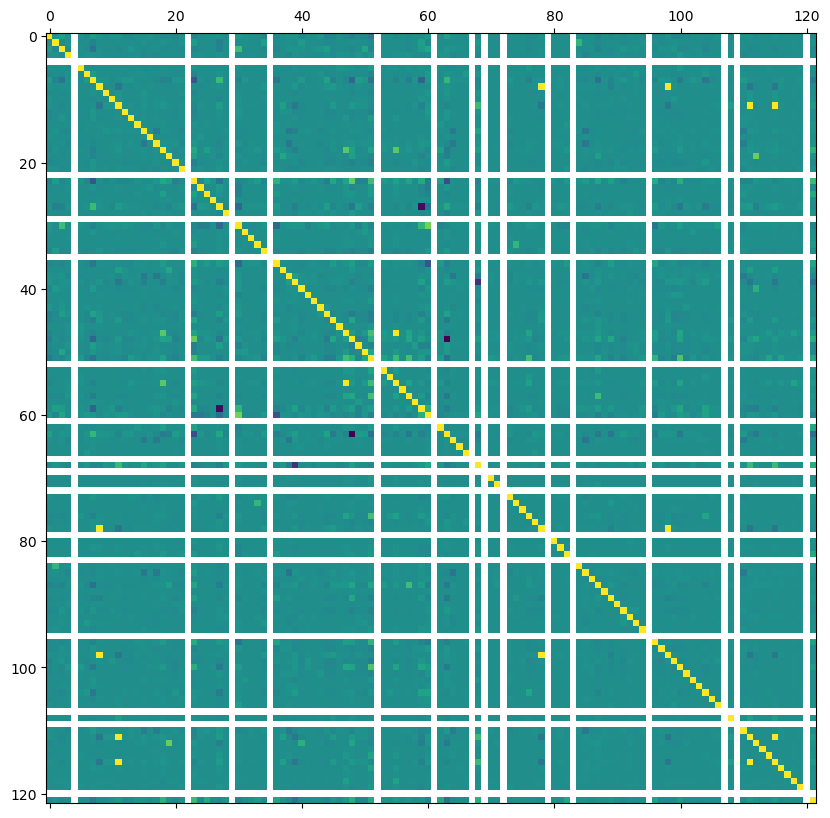

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(X_inliers.corr())
plt.show()

#### Evaluation on validation set

1e-29
AUC-PR:    0.7830530262160444
F1 score:  0.5418938637585438


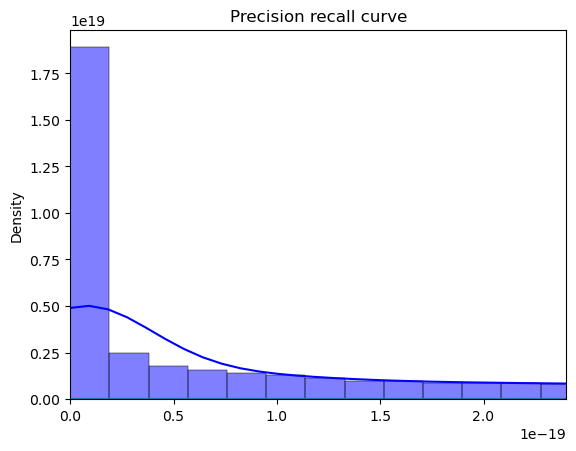

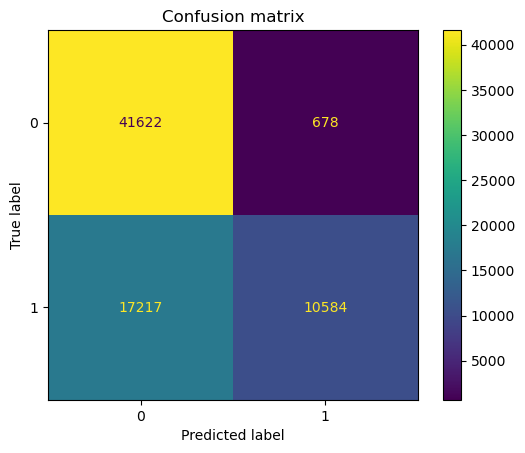

In [53]:
prediction_column = 'Pred_MG_PDF'
EPSILON = 1e-23
# for testing with for loop
EPSILONS = [10**(-x) for x in range(10, 30) ]

p = multivariate_normal(mean=np.mean(X_inliers_train, axis=0), cov=np.cov(X_inliers_train.T), allow_singular=True)
prob_density = p.pdf(X_valid)
sns.histplot(prob_density, color='b', kde=True, stat="density")
plt.xlim(0, prob_density.mean())

pred_valid = (prob_density < EPSILON).astype(int)

precision, recall, thresholds = precision_recall_curve(y_valid, pred_valid)
auc_precision_recall = auc(recall, precision)
f1 = f1_score(y_valid, pred_valid)
print(eps)
print(f'AUC-PR:    {auc_precision_recall}')
print(f'F1 score:  {f1}')

plt.plot(recall, precision)
plt.title('Precision recall curve')
plt.show()

cm = confusion_matrix(y_valid, pred_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion matrix')
plt.show()

#### Evaluation on whole dataset

AUC-PR:    0.7017551532023633
F1 score:  0.4112224106239581


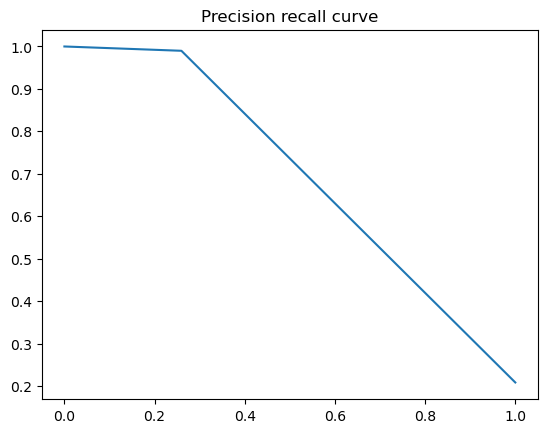

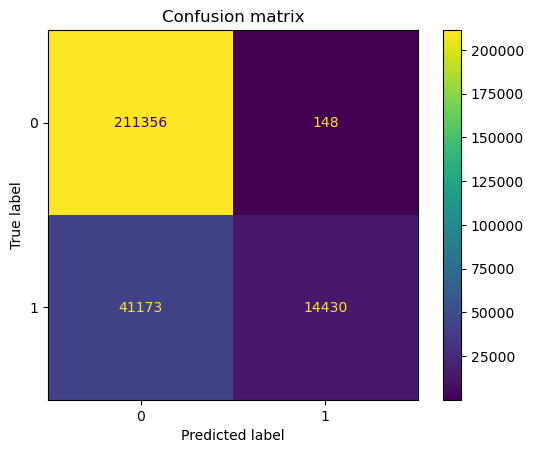

In [67]:
EPSILON = 1e-68

p = multivariate_normal(mean=np.mean(X_inliers, axis=0), cov=np.cov(X_inliers.T), allow_singular=True)
prob_density = p.pdf(X_train)
df_significant.loc[:, prediction_column] = (prob_density < EPSILON).astype(int)
evaluate_results(prediction_column)

### Isolation Forrest
- fast and accurate
- not need to scale features
- output is -1 for outliers and 1 for inliers -> transform to 1 and 0 by (x + 2) % 3
- pros is knowing contamination size
- evaluation: if contamination size not specified then generates many FP -> not reliable but for detecting fraud transactions it is not a big issue, if we specify contamination size then FP and TN almost the same and only 1/4 of FN revealed

In [77]:
prediction_column = 'Pred_ISF'
N_ESTIMATORS = [i for i in range(1, 60)]
AUC_PR = np.zeros(shape=(len(N_ESTIMATORS,)))
F1_SCORES = np.zeros(shape=(len(N_ESTIMATORS,)))


for i, n_estimators in enumerate(N_ESTIMATORS):
    
    ISF = IsolationForest(n_estimators=n_estimators, max_features=1.0, max_samples=1.0, bootstrap=False, random_state=42, contamination=CONTAMINATION)
    prediction_raw = ISF.fit_predict(X_train)
    prediction = (prediction_raw + 2) % 3

    precision, recall, thresholds = precision_recall_curve(df_significant["Class"], prediction)
    auc_precision_recall = auc(recall, precision)
    f1 = f1_score(df_significant["Class"], prediction)

    AUC_PR[i] = auc_precision_recall
    F1_SCORES[i] = f1

/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/ba

Text(0, 0.5, 'Value of metric')

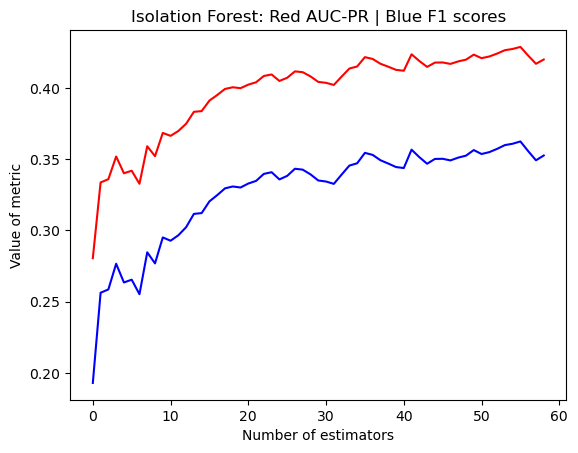

In [78]:
plt.plot(np.arange(len(N_ESTIMATORS)), AUC_PR, c='red')
plt.plot(np.arange(len(N_ESTIMATORS)), F1_SCORES, c='blue')
plt.title('Isolation Forest: Red AUC-PR | Blue F1 scores')
plt.xlabel('Number of estimators')
plt.ylabel('Value of metric')

/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


AUC-PR:    0.42878753410169673
F1 score:  0.36242648777943637


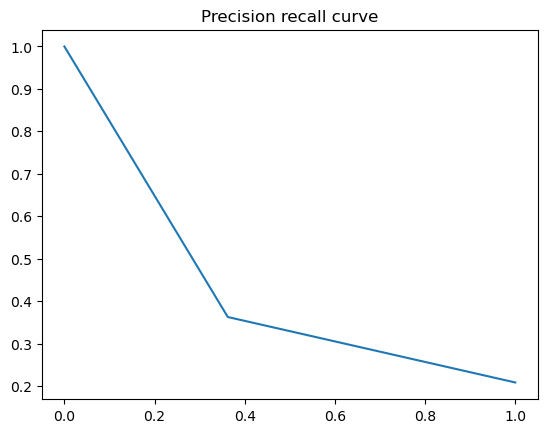

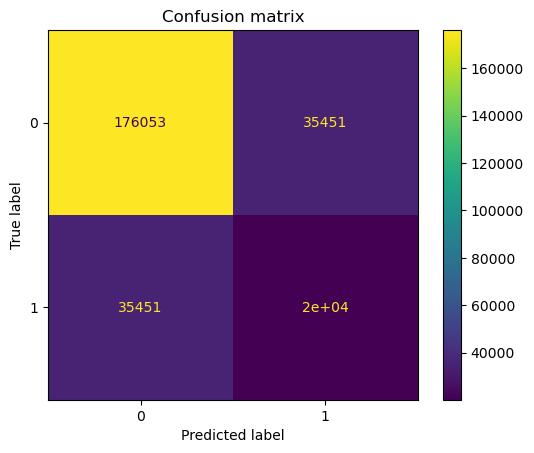

In [79]:
ISF = IsolationForest(n_estimators=np.argmax(AUC_PR)+1, max_features=1.0, max_samples=1.0, bootstrap=False, random_state=42, contamination=CONTAMINATION)
prediction_raw = ISF.fit_predict(X_train)
prediction = (prediction_raw + 2) % 3
df_significant.loc[:, prediction_column] = (prediction_raw + 2) % 3
evaluate_results(prediction_column)

### Local Outlier Factor
- very slow computation without PCA transformation

In [80]:
prediction_column = 'Pred_LOF'

N_NEIGHBORS = [i for i in range(100, 101)]
AUC_PR = np.zeros(shape=(len(N_NEIGHBORS,)))
F1_SCORES = np.zeros(shape=(len(N_NEIGHBORS,)))

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_sc)

for i, n_neighbors in enumerate(N_NEIGHBORS):

    print(i)

    LOF = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=CONTAMINATION)
    prediction_raw = LOF.fit_predict(X_train_pca)
    prediction = (prediction_raw + 2) % 3

    precision, recall, thresholds = precision_recall_curve(df_significant["Class"], prediction)
    auc_precision_recall = auc(recall, precision)
    f1 = f1_score(df_significant["Class"], prediction)

    AUC_PR[i] = auc_precision_recall
    F1_SCORES[i] = f1

0


Text(0, 0.5, 'Value of metric')

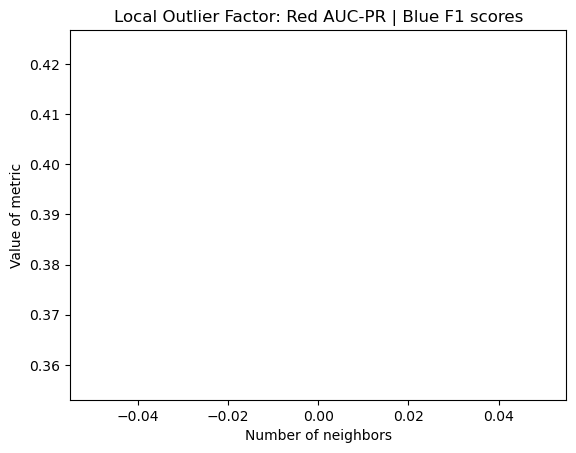

In [81]:
plt.plot(np.arange(len(N_NEIGHBORS)), AUC_PR, c='red')
plt.plot(np.arange(len(N_NEIGHBORS)), F1_SCORES, c='blue')
plt.title('Local Outlier Factor: Red AUC-PR | Blue F1 scores')
plt.xlabel('Number of neighbors')
plt.ylabel('Value of metric')

AUC-PR:    0.3353175751534003
F1 score:  0.25809758466269805


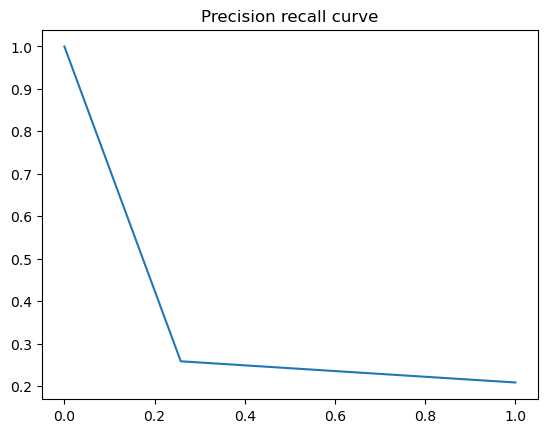

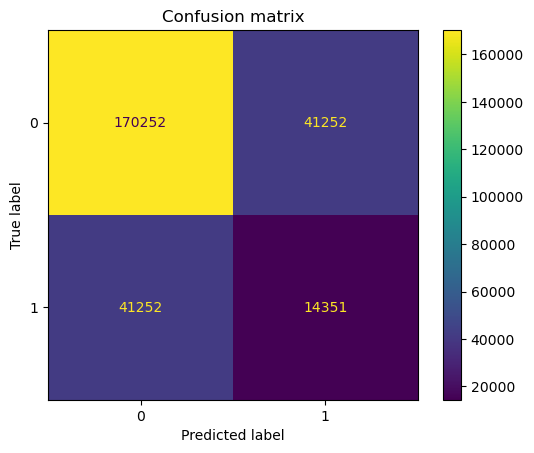

In [86]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train_sc)

LOF = LocalOutlierFactor(n_neighbors=np.argmax(AUC_PR)+1, contamination=CONTAMINATION)
prediction_raw = LOF.fit_predict(X_train_pca)
prediction = (prediction_raw + 2) % 3
df_significant.loc[:, prediction_column] = (prediction_raw + 2) % 3
evaluate_results(prediction_column)

### Robust Covariance (Elliptic Envelope)

In [94]:
prediction_column = 'Pred_ELE'
# SUPPORT_FRACTIONS = [0.5 + 0.08 * x for x in range(5)]
SUPPORT_FRACTION=0.58

ELE = EllipticEnvelope(support_fraction=SUPPORT_FRACTION, contamination=CONTAMINATION)
prediction_raw = ELE.fit_predict(X_train)
df_significant.loc[:, prediction_column] = (prediction_raw + 2) % 3

# 5118, 4551 for 0.48

/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


AUC-PR:    0.5422372808617304
F1 score:  0.48905634588061797


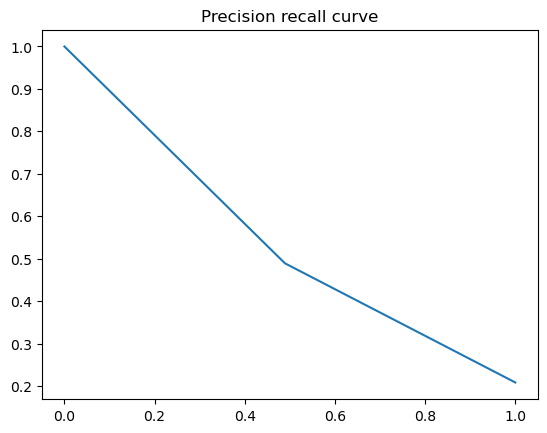

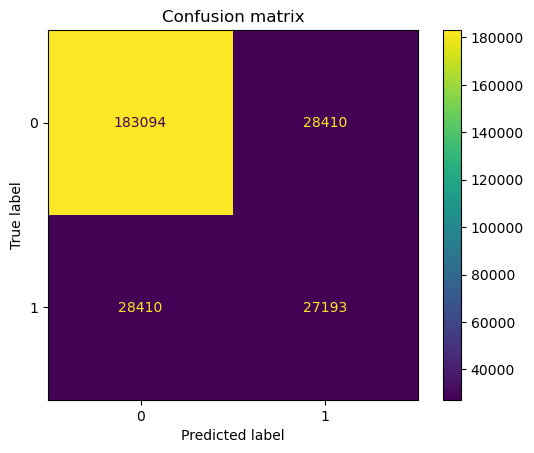

In [97]:
evaluate_results(prediction_column)

AUC-PR:    0.5422372808617304
F1 score:  0.48905634588061797


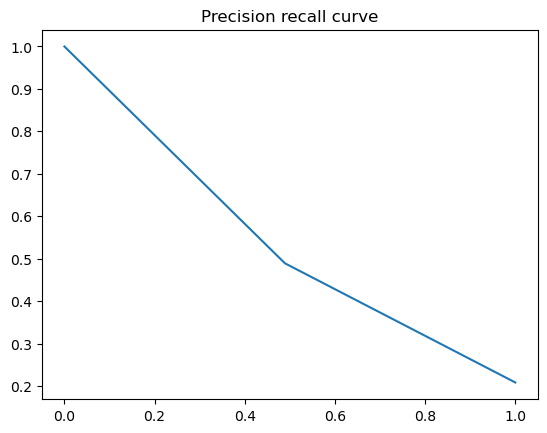

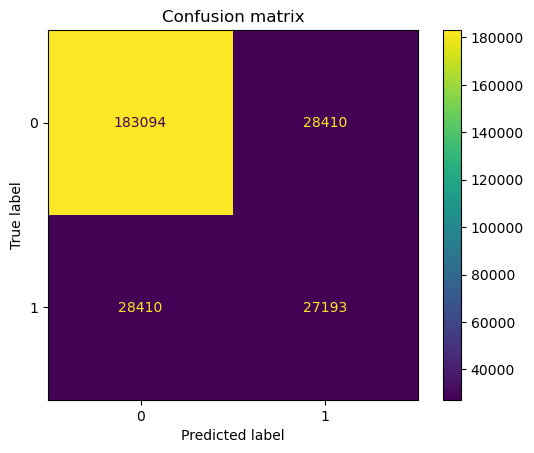

In [95]:
evaluate_results(prediction_column)

## 4.  Evaluation & Model Comparison 

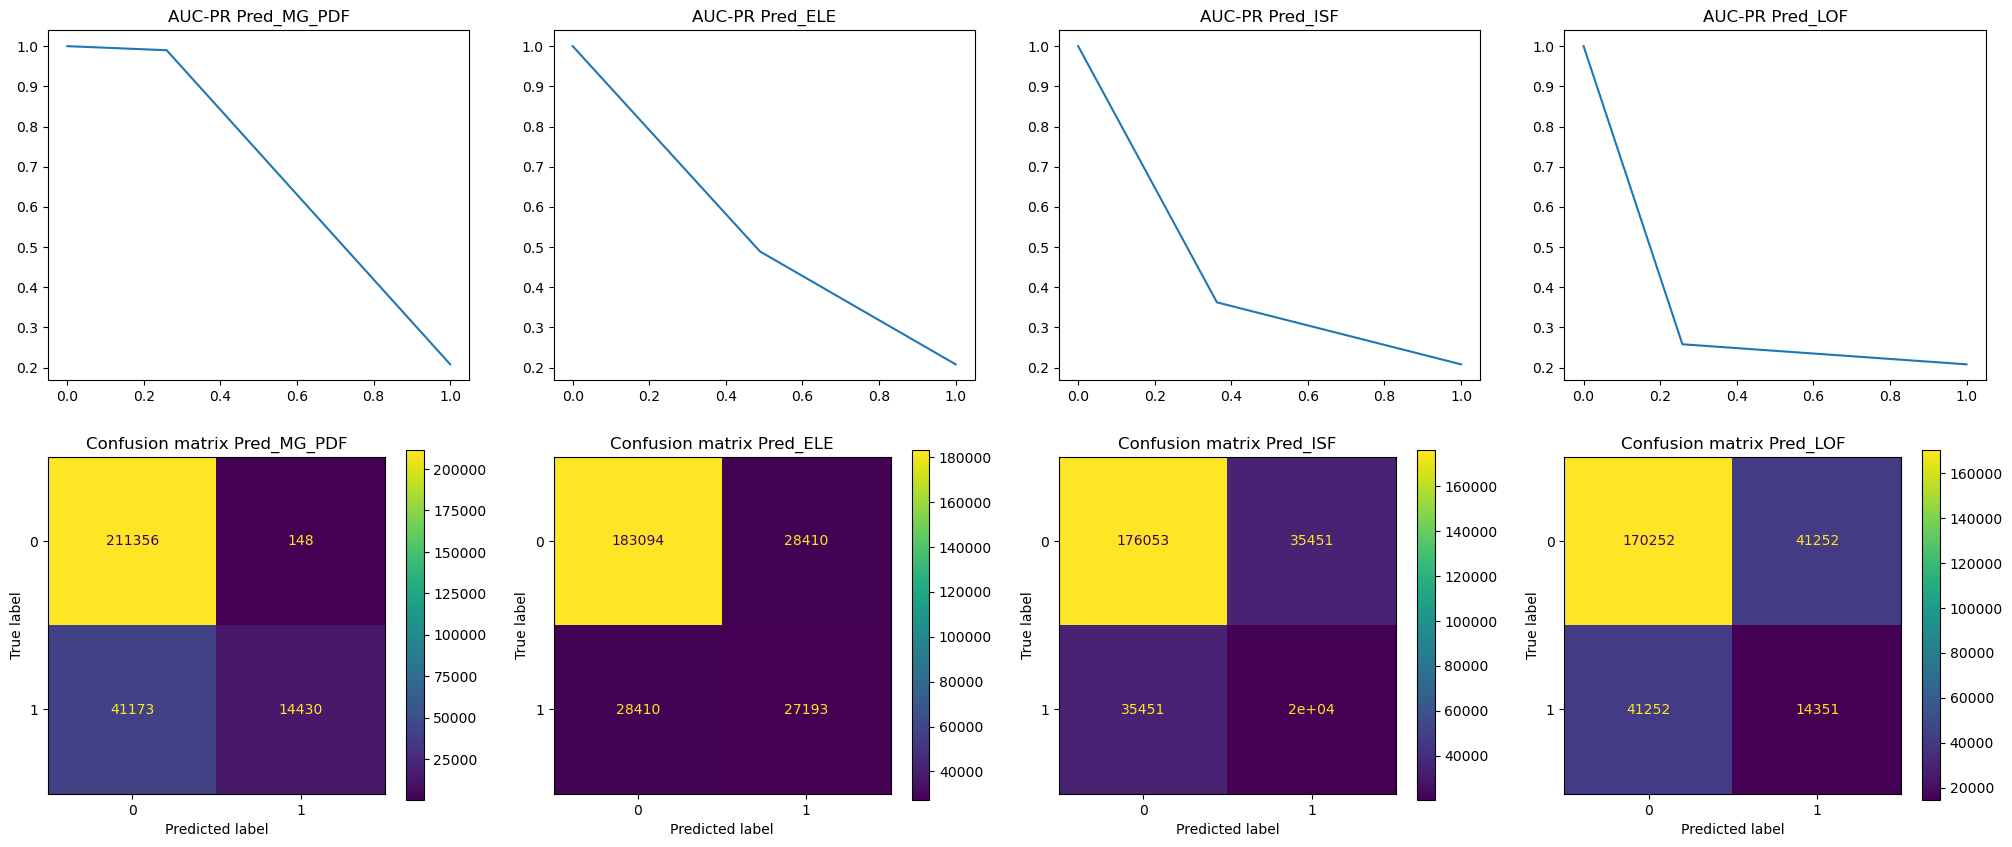

In [96]:
prediction_columns = ['Pred_MG_PDF', 'Pred_ELE', 'Pred_ISF', 'Pred_LOF']
show_results_all(prediction_columns)

Text(0.5, 1.0, 'Metrics results')

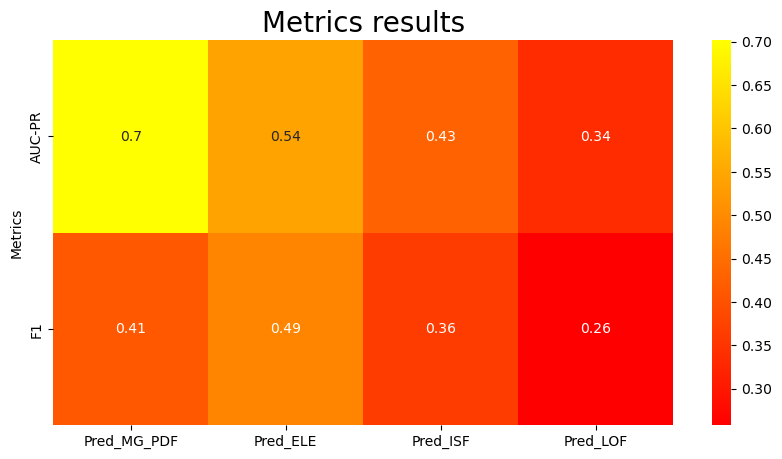

In [98]:
final_metrics_table = pd.DataFrame(evaluate_metrics_all(prediction_columns), columns=prediction_columns)
final_metrics_table["Metrics"] = ["AUC-PR", "F1"]
final_metrics_table.set_index("Metrics", inplace=True)
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(final_metrics_table, annot=True, cmap='autumn')
plt.title("Metrics results", fontsize=20)